# Temat testów:
### Czy istnieje istotna statystycznie różnica w czasie odpowiedzi w zależności od cech osobowych badanych? (grupy: wszystkie grafiki, grafiki A, grafiki B, grafiki 1,2,3)

In [1]:
import pandas as pd
import statsmodels.api as sm
from scipy.stats import shapiro, f_oneway, levene, kruskal
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df_quest = pd.read_csv(
    '/Users/martasolarz/Studies/Thesis/data/survey.csv',
).fillna('NO_VAL')

df_quest = df_quest[df_quest.ID != 6] # odrzucony uczestnik ze względu na metryki eye trackingowe

# zagregowane kolumny - podział na tych co pisali i nie pisali danej matury:
df_quest['MAT'] = df_quest['MAT_roz'].apply(lambda x: x if x == 'NO_VAL' else 'VAL' )
df_quest['POL'] = df_quest['JP_roz'].apply(lambda x: x if x == 'NO_VAL' else 'VAL' )
df_quest['HIST'] = df_quest['HIST_roz'].apply(lambda x: x if x == 'NO_VAL' else 'VAL')

def choose_dominant_kind(x):
    k = x['Kinestetyk']
    s = x['Słuchowiec']
    w = x['Wzrokowiec']
    if k > s and k > w:
        return 'Kinestetyk'
    elif s > k and s > w:
        return 'Słuchowiec'
    elif w > k and w > s:
        return 'Wzrokowiec'
    else:
        return "Brak dominującego"

df_quest['Typ_uczenia'] = df_quest.apply(choose_dominant_kind, axis=1)

df_time =  pd.read_csv('/Users/martasolarz/Studies/Thesis/data/metrics/times.csv',
    usecols=['ID', 'Duration_1a', 'Duration_1b', 'Duration_2a', 'Duration_2b', 'Duration_3a', 'Duration_3b']
)

df_time['Sum_all'] = df_time.apply(lambda x: x.sum(), axis=1)
a = df_time[['Duration_1a', 'Duration_2a', 'Duration_3a']]
b = df_time[['Duration_1b', 'Duration_2b', 'Duration_3b']]
df_time['Sum_a'] = a.apply(lambda x: x.sum(), axis=1)
df_time['Sum_b'] = b.apply(lambda x: x.sum(), axis=1)
gr1 = df_time[['Duration_1a', 'Duration_1b']]
gr2 = df_time[['Duration_2a', 'Duration_2b']]
gr3 = df_time[['Duration_3a', 'Duration_3b']]
df_time['Sum_1'] = gr1.apply(lambda x: x.sum(), axis=1)
df_time['Sum_2'] = gr2.apply(lambda x: x.sum(), axis=1)
df_time['Sum_3'] = gr3.apply(lambda x: x.sum(), axis=1)

df_merge = df_quest.merge(df_time, on='ID')
df_merge

ID Płeć  Rok_urodzenia                               Kierunek_studiów  \
0    1    M           2002  Geografia, w ramach studiów międzyobszarowych   
1    2    M           2003                        Gospodarka przestrzenna   
2    3    M           2001                                      Geografia   
3    4    K           2000                                      Geografia   
4    5    K           2002                                      Geografia   
5    7    K           2001  Geografia, w ramach studiów międzyobszarowych   
6   11    M           2003                                      Geografia   
7   12    K           2003                                      Geografia   
8   13    K           2004                                      Geografia   
9   14    M           2002  Geografia, w ramach studiów międzyobszarowych   
10  15    K           2002                                      Geografia   
11  16    M           2002                                      Geografia   
12  17    K           2002                                      Geografia   
13  18    K           2002                        Gospodarka przestrzenna   
14  19    M           2003                        Gospodarka przestrzenna   
15  20    K           2003                                      Geografia   
16  21    M           2002                                      Geografia   
17  22    K           2002                                      Geografia   
18  23    M           2003                                      Geografia   
19  24    M           2004                                      Geografia   
20  25    K           2001                                      Geografia   
21  26    K           2003                                      Geografia   
22  27    K           2001                        Gospodarka przestrzenna   
23  29    M           2003                                      Geografia   
24  30    K           2001                                      Geografia   
25  31    K           2001                                      Geografia   
26  32    K           2001                                      Geografia   
27  33    M           2003                                      Geografia   
28  34    M           2002                                      Geografia   
29  35    M           2001                                      Geografia   
30  37    K           2003                                      Geografia   
31  38    K           2004                                      Geografia   
32  39    K           2003                                      Geografia   
33  40    K           2003                                      Geografia   
34  41    M           2003                                      Geografia   
35  42    K           2003                                      Geografia   
36  43    M           2003                        Gospodarka przestrzenna   
37  44    K           2003                                      Geografia   
38  45    M           2003                                      Geografia   
39  46    K           2002                                      Geografia   

    Rok_studiów Specjalność  Wady_wzroku  Daltonizm Ilość_snu   JP_podst  ...  \
0             2    SPOŁ-EKO            0          1         6  90 - 100%  ...   
1             1      NO_VAL            1          1        <6   50 - 69%  ...   
2             3     GEOINF             0          1         8   50 - 69%  ...   
3             3     GEOINF             0          1         8   50 - 69%  ...   
4             3     GEOINF             0          1         7   50 - 69%  ...   
5             3     GEOINF             0          1         7   70 - 89%  ...   
6             1     GEOINF             0          1        8<   50 - 69%  ...   
7             1        FIZ             0          1        8<   30 - 49%  ...   
8             1        FIZ             0          1        8<   70 - 89%  ...   
9             2     GEOINF          

Funkcje:

In [3]:
def is_gaussian(data, alpha):
    stats, p = shapiro(data)
    print('Stats:', stats)
    print('P-value:', p)
    if p > alpha:
        print('Dane mają rozkład normalny.')
    else:
        print('Rozkład jest różny od normalnego.')

In [4]:
def make_decision(p_val, alpha):
    print('p-value: ', p_val)
    if p_val < alpha:
        print('Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.')
    else:
        print('Brak podstaw do odrzucenia H0.')
    
def homogeneity_var(df, col):
    groups = [df[df[col] == i]['czas'] for i in df[col].unique()]
    w, p_value = levene(*groups)
    print('W:', w)
    return p_value

def anova(df, col):
    groups = [df[df[col] == i]['czas'] for i in df[col].unique()]
    f_value, p_value = f_oneway(*groups)
    print('F-value:', f_value)
    make_decision(p_value, ALPHA)
    
def kruskal_wallis(df, col):
    groups = [df[df[col] == i]['czas'] for i in df[col].unique()]
    h, p_value = kruskal(*groups)
    print('H:', h)
    make_decision(p_value, ALPHA)

In [5]:
def test_parametr_gaussian(dfs, names):
    for i, df in enumerate(dfs):
        print('-----------------------------------------------')
        print(names[i+1])
        is_gaussian(df['czas'], ALPHA)

In [6]:
def test_for_gauss_variable(dfs, col):
    for i, df in enumerate(dfs):
        print('-----------------------------------------------')
        print(names_gauss[i+1])
        p_val = homogeneity_var(df, col)
        if p_val < ALPHA:
            print('Brak homogeniczności wariancji.')
            kruskal_wallis(df, col)
        else:
            print('Homogeniczność wariancji zachowana.')
            anova(df, col)

In [7]:
def test_for_non_gauss_variable(dfs, col):
    for i, df in enumerate(dfs):
        print('-----------------------------------------------')
        print(names_nogauss[i+1])
        kruskal_wallis(df, col)

In [8]:
def test_posthoc(df, independent_variable):
    posthoc = sm.stats.multicomp.MultiComparison(df['czas'], df[independent_variable])
    result = posthoc.tukeyhsd()
    print(result)

In [94]:
def plot_categorical_time_data(df, categorical_column_name, name):
    time_column_name = 'czas'
    categories = df[categorical_column_name].unique()

    plt.figure(figsize=(10, 6))
    for i, category in enumerate(categories):
        category_data = df[df[categorical_column_name] == category]
        plt.scatter(category_data[time_column_name], [i + 1] * len(category_data), label=category)

    plt.xlim([0, df[time_column_name].max()+10000])
    plt.yticks(range(1, len(categories) + 1), categories)
    plt.xlabel('czas [ms]')
    plt.ylabel(categorical_column_name)
    plt.title(f'{name} Rozkład czasu vs. {categorical_column_name}')
    plt.legend()
    plt.show()

In [10]:
def prepare_col(list_of_cols_popr):
    new_row_popr = list_of_cols_popr[0]
    for i in list_of_cols_popr[1:]:
        new_row_popr = pd.concat([new_row_popr, i], ignore_index=True)

    return new_row_popr

Przygotowanie zbiorów:

In [11]:
# suma wszystkich czasów
df_sumAll = df_merge.drop(columns=['Duration_1a', 'Duration_1b', 'Duration_2a', 'Duration_2b', 'Duration_3a', 'Duration_3b', 'Sum_a', 'Sum_b', 'Sum_1', 'Sum_2', 'Sum_3']).rename(columns={'Sum_all':'czas'})
df_sumAll

ID Płeć  Rok_urodzenia                               Kierunek_studiów  \
0    1    M           2002  Geografia, w ramach studiów międzyobszarowych   
1    2    M           2003                        Gospodarka przestrzenna   
2    3    M           2001                                      Geografia   
3    4    K           2000                                      Geografia   
4    5    K           2002                                      Geografia   
5    7    K           2001  Geografia, w ramach studiów międzyobszarowych   
6   11    M           2003                                      Geografia   
7   12    K           2003                                      Geografia   
8   13    K           2004                                      Geografia   
9   14    M           2002  Geografia, w ramach studiów międzyobszarowych   
10  15    K           2002                                      Geografia   
11  16    M           2002                                      Geografia   
12  17    K           2002                                      Geografia   
13  18    K           2002                        Gospodarka przestrzenna   
14  19    M           2003                        Gospodarka przestrzenna   
15  20    K           2003                                      Geografia   
16  21    M           2002                                      Geografia   
17  22    K           2002                                      Geografia   
18  23    M           2003                                      Geografia   
19  24    M           2004                                      Geografia   
20  25    K           2001                                      Geografia   
21  26    K           2003                                      Geografia   
22  27    K           2001                        Gospodarka przestrzenna   
23  29    M           2003                                      Geografia   
24  30    K           2001                                      Geografia   
25  31    K           2001                                      Geografia   
26  32    K           2001                                      Geografia   
27  33    M           2003                                      Geografia   
28  34    M           2002                                      Geografia   
29  35    M           2001                                      Geografia   
30  37    K           2003                                      Geografia   
31  38    K           2004                                      Geografia   
32  39    K           2003                                      Geografia   
33  40    K           2003                                      Geografia   
34  41    M           2003                                      Geografia   
35  42    K           2003                                      Geografia   
36  43    M           2003                        Gospodarka przestrzenna   
37  44    K           2003                                      Geografia   
38  45    M           2003                                      Geografia   
39  46    K           2002                                      Geografia   

    Rok_studiów Specjalność  Wady_wzroku  Daltonizm Ilość_snu   JP_podst  ...  \
0             2    SPOŁ-EKO            0          1         6  90 - 100%  ...   
1             1      NO_VAL            1          1        <6   50 - 69%  ...   
2             3     GEOINF             0          1         8   50 - 69%  ...   
3             3     GEOINF             0          1         8   50 - 69%  ...   
4             3     GEOINF             0          1         7   50 - 69%  ...   
5             3     GEOINF             0          1         7   70 - 89%  ...   
6             1     GEOINF             0          1        8<   50 - 69%  ...   
7             1        FIZ             0          1        8<   30 - 49%  ...   
8             1        FIZ             0          1        8<   70 - 89%  ...   
9             2     GEOINF          

In [12]:
# wszystkie grafiki
df_list = [df_quest] * 6
df_all = pd.concat(df_list, ignore_index=True)

czas = []
for col in df_time.columns.tolist():
    if col.startswith('Duration_'):
        czas.append(df_time[col])
colCzas = prepare_col(czas)

df_all['czas'] = colCzas
df_all

ID Płeć  Rok_urodzenia                               Kierunek_studiów  \
0     1    M           2002  Geografia, w ramach studiów międzyobszarowych   
1     2    M           2003                        Gospodarka przestrzenna   
2     3    M           2001                                      Geografia   
3     4    K           2000                                      Geografia   
4     5    K           2002                                      Geografia   
..   ..  ...            ...                                            ...   
235  42    K           2003                                      Geografia   
236  43    M           2003                        Gospodarka przestrzenna   
237  44    K           2003                                      Geografia   
238  45    M           2003                                      Geografia   
239  46    K           2002                                      Geografia   

     Rok_studiów Specjalność  Wady_wzroku  Daltonizm Ilość_snu   JP_podst  \
0              2    SPOŁ-EKO            0          1         6  90 - 100%   
1              1      NO_VAL            1          1        <6   50 - 69%   
2              3     GEOINF             0          1         8   50 - 69%   
3              3     GEOINF             0          1         8   50 - 69%   
4              3     GEOINF             0          1         7   50 - 69%   
..           ...         ...          ...        ...       ...        ...   
235            1        FIZ             0          1         7   70 - 89%   
236            1      NO_VAL            1          1         8   50 - 69%   
237            1        FIZ             1          1        <6   50 - 69%   
238            1     GEOINF             1          1        8<   30 - 49%   
239            1        FIZ             1          1         7   70 - 89%   

     ... Rank_txt Rank_plt Rank_tab        Data   Godzina     MAT     POL  \
0    ...        4        1        2  2023-05-24  11:44:20     VAL     VAL   
1    ...        3        1        4  2023-05-24  12:21:03     VAL     VAL   
2    ...        4        3        2  2023-05-24  12:41:09     VAL  NO_VAL   
3    ...        4        3        1  2023-05-24  13:15:20  NO_VAL     VAL   
4    ...        4        1        3  2023-05-24  13:35:17  NO_VAL  NO_VAL   
..   ...      ...      ...      ...         ...       ...     ...     ...   
235  ...        4        1        3  2023-06-07  11:42:55  NO_VAL  NO_VAL   
236  ...        3        1        2  2023-06-07  13:04:51  NO_VAL  NO_VAL   
237  ...        1        2        1  2023-06-07  14:13:38     VAL  NO_VAL   
238  ...        4        3        1  2023-06-07  14:27:37     VAL  NO_VAL   
239  ...        3        3        3  2023-06-07  15:19:52  NO_VAL  NO_VAL   

       HIST        Typ_uczenia    czas  
0    NO_VAL         Kinestetyk   34682  
1    NO_VAL  Brak dominującego   53564  
2    NO_VAL         Wzrokowiec   85546  
3    NO_VAL  Brak dominującego   61197  
4    NO_VAL         Wzrokowiec   42031  
..      ...                ...     ...  
235  NO_VAL         Wzrokowiec   33732  
236  NO_VAL  Brak dominującego   75830  
237  NO_VAL  Brak dominującego  130660  
238  NO_VAL         Słuchowiec  129427  
239  NO_VAL  Brak dominującego  139343  

[240 rows x 39 columns]

In [13]:
# suma grafiki A
df_sumA = df_merge.drop(columns=['Duration_1a', 'Duration_1b', 'Duration_2a', 'Duration_2b', 'Duration_3a', 'Duration_3b', 'Sum_b', 'Sum_all', 'Sum_1', 'Sum_2', 'Sum_3']).rename(columns={'Sum_a':'czas'})

# suma grafiki B
df_sumB = df_merge.drop(columns=['Duration_1a', 'Duration_1b', 'Duration_2a', 'Duration_2b', 'Duration_3a', 'Duration_3b', 'Sum_a', 'Sum_all', 'Sum_1', 'Sum_2', 'Sum_3']).rename(columns={'Sum_b':'czas'})
df_sumB

ID Płeć  Rok_urodzenia                               Kierunek_studiów  \
0    1    M           2002  Geografia, w ramach studiów międzyobszarowych   
1    2    M           2003                        Gospodarka przestrzenna   
2    3    M           2001                                      Geografia   
3    4    K           2000                                      Geografia   
4    5    K           2002                                      Geografia   
5    7    K           2001  Geografia, w ramach studiów międzyobszarowych   
6   11    M           2003                                      Geografia   
7   12    K           2003                                      Geografia   
8   13    K           2004                                      Geografia   
9   14    M           2002  Geografia, w ramach studiów międzyobszarowych   
10  15    K           2002                                      Geografia   
11  16    M           2002                                      Geografia   
12  17    K           2002                                      Geografia   
13  18    K           2002                        Gospodarka przestrzenna   
14  19    M           2003                        Gospodarka przestrzenna   
15  20    K           2003                                      Geografia   
16  21    M           2002                                      Geografia   
17  22    K           2002                                      Geografia   
18  23    M           2003                                      Geografia   
19  24    M           2004                                      Geografia   
20  25    K           2001                                      Geografia   
21  26    K           2003                                      Geografia   
22  27    K           2001                        Gospodarka przestrzenna   
23  29    M           2003                                      Geografia   
24  30    K           2001                                      Geografia   
25  31    K           2001                                      Geografia   
26  32    K           2001                                      Geografia   
27  33    M           2003                                      Geografia   
28  34    M           2002                                      Geografia   
29  35    M           2001                                      Geografia   
30  37    K           2003                                      Geografia   
31  38    K           2004                                      Geografia   
32  39    K           2003                                      Geografia   
33  40    K           2003                                      Geografia   
34  41    M           2003                                      Geografia   
35  42    K           2003                                      Geografia   
36  43    M           2003                        Gospodarka przestrzenna   
37  44    K           2003                                      Geografia   
38  45    M           2003                                      Geografia   
39  46    K           2002                                      Geografia   

    Rok_studiów Specjalność  Wady_wzroku  Daltonizm Ilość_snu   JP_podst  ...  \
0             2    SPOŁ-EKO            0          1         6  90 - 100%  ...   
1             1      NO_VAL            1          1        <6   50 - 69%  ...   
2             3     GEOINF             0          1         8   50 - 69%  ...   
3             3     GEOINF             0          1         8   50 - 69%  ...   
4             3     GEOINF             0          1         7   50 - 69%  ...   
5             3     GEOINF             0          1         7   70 - 89%  ...   
6             1     GEOINF             0          1        8<   50 - 69%  ...   
7             1        FIZ             0          1        8<   30 - 49%  ...   
8             1        FIZ             0          1        8<   70 - 89%  ...   
9             2     GEOINF          

In [14]:
# grafiki A
df_list = [df_quest] * 3
df_a = pd.concat(df_list, ignore_index=True)

czas = []
for col in df_time.columns.tolist():
    if col.startswith('Duration_') and col.endswith('a'):
        czas.append(df_time[col])
colCzas = prepare_col(czas)

df_a['czas'] = colCzas

# grafiki B
df_list = [df_quest] * 3
df_b = pd.concat(df_list, ignore_index=True)

czas = []
for col in df_time.columns.tolist():
    if col.startswith('Duration_') and col.endswith('b'):
        czas.append(df_time[col])
colCzas = prepare_col(czas)

df_b['czas'] = colCzas
df_b

ID Płeć  Rok_urodzenia                               Kierunek_studiów  \
0     1    M           2002  Geografia, w ramach studiów międzyobszarowych   
1     2    M           2003                        Gospodarka przestrzenna   
2     3    M           2001                                      Geografia   
3     4    K           2000                                      Geografia   
4     5    K           2002                                      Geografia   
..   ..  ...            ...                                            ...   
115  42    K           2003                                      Geografia   
116  43    M           2003                        Gospodarka przestrzenna   
117  44    K           2003                                      Geografia   
118  45    M           2003                                      Geografia   
119  46    K           2002                                      Geografia   

     Rok_studiów Specjalność  Wady_wzroku  Daltonizm Ilość_snu   JP_podst  \
0              2    SPOŁ-EKO            0          1         6  90 - 100%   
1              1      NO_VAL            1          1        <6   50 - 69%   
2              3     GEOINF             0          1         8   50 - 69%   
3              3     GEOINF             0          1         8   50 - 69%   
4              3     GEOINF             0          1         7   50 - 69%   
..           ...         ...          ...        ...       ...        ...   
115            1        FIZ             0          1         7   70 - 89%   
116            1      NO_VAL            1          1         8   50 - 69%   
117            1        FIZ             1          1        <6   50 - 69%   
118            1     GEOINF             1          1        8<   30 - 49%   
119            1        FIZ             1          1         7   70 - 89%   

     ... Rank_txt Rank_plt Rank_tab        Data   Godzina     MAT     POL  \
0    ...        4        1        2  2023-05-24  11:44:20     VAL     VAL   
1    ...        3        1        4  2023-05-24  12:21:03     VAL     VAL   
2    ...        4        3        2  2023-05-24  12:41:09     VAL  NO_VAL   
3    ...        4        3        1  2023-05-24  13:15:20  NO_VAL     VAL   
4    ...        4        1        3  2023-05-24  13:35:17  NO_VAL  NO_VAL   
..   ...      ...      ...      ...         ...       ...     ...     ...   
115  ...        4        1        3  2023-06-07  11:42:55  NO_VAL  NO_VAL   
116  ...        3        1        2  2023-06-07  13:04:51  NO_VAL  NO_VAL   
117  ...        1        2        1  2023-06-07  14:13:38     VAL  NO_VAL   
118  ...        4        3        1  2023-06-07  14:27:37     VAL  NO_VAL   
119  ...        3        3        3  2023-06-07  15:19:52  NO_VAL  NO_VAL   

       HIST        Typ_uczenia    czas  
0    NO_VAL         Kinestetyk   96628  
1    NO_VAL  Brak dominującego   33598  
2    NO_VAL         Wzrokowiec   33632  
3    NO_VAL  Brak dominującego   30882  
4    NO_VAL         Wzrokowiec   30282  
..      ...                ...     ...  
115  NO_VAL         Wzrokowiec   33732  
116  NO_VAL  Brak dominującego   75830  
117  NO_VAL  Brak dominującego  130660  
118  NO_VAL         Słuchowiec  129427  
119  NO_VAL  Brak dominującego  139343  

[120 rows x 39 columns]

In [15]:
# suma grafiki 1, 2, 3
df_sum1 = df_merge.drop(columns=['Duration_1a', 'Duration_1b', 'Duration_2a', 'Duration_2b', 'Duration_3a', 'Duration_3b', 'Sum_a', 'Sum_all', 'Sum_b', 'Sum_2', 'Sum_3']).rename(columns={'Sum_1':'czas'})

df_sum2 = df_merge.drop(columns=['Duration_1a', 'Duration_1b', 'Duration_2a', 'Duration_2b', 'Duration_3a', 'Duration_3b', 'Sum_a', 'Sum_all', 'Sum_b', 'Sum_1', 'Sum_3']).rename(columns={'Sum_2':'czas'})

df_sum3 = df_merge.drop(columns=['Duration_1a', 'Duration_1b', 'Duration_2a', 'Duration_2b', 'Duration_3a', 'Duration_3b', 'Sum_a', 'Sum_all', 'Sum_b', 'Sum_2', 'Sum_1']).rename(columns={'Sum_3':'czas'})

df_sum3

ID Płeć  Rok_urodzenia                               Kierunek_studiów  \
0    1    M           2002  Geografia, w ramach studiów międzyobszarowych   
1    2    M           2003                        Gospodarka przestrzenna   
2    3    M           2001                                      Geografia   
3    4    K           2000                                      Geografia   
4    5    K           2002                                      Geografia   
5    7    K           2001  Geografia, w ramach studiów międzyobszarowych   
6   11    M           2003                                      Geografia   
7   12    K           2003                                      Geografia   
8   13    K           2004                                      Geografia   
9   14    M           2002  Geografia, w ramach studiów międzyobszarowych   
10  15    K           2002                                      Geografia   
11  16    M           2002                                      Geografia   
12  17    K           2002                                      Geografia   
13  18    K           2002                        Gospodarka przestrzenna   
14  19    M           2003                        Gospodarka przestrzenna   
15  20    K           2003                                      Geografia   
16  21    M           2002                                      Geografia   
17  22    K           2002                                      Geografia   
18  23    M           2003                                      Geografia   
19  24    M           2004                                      Geografia   
20  25    K           2001                                      Geografia   
21  26    K           2003                                      Geografia   
22  27    K           2001                        Gospodarka przestrzenna   
23  29    M           2003                                      Geografia   
24  30    K           2001                                      Geografia   
25  31    K           2001                                      Geografia   
26  32    K           2001                                      Geografia   
27  33    M           2003                                      Geografia   
28  34    M           2002                                      Geografia   
29  35    M           2001                                      Geografia   
30  37    K           2003                                      Geografia   
31  38    K           2004                                      Geografia   
32  39    K           2003                                      Geografia   
33  40    K           2003                                      Geografia   
34  41    M           2003                                      Geografia   
35  42    K           2003                                      Geografia   
36  43    M           2003                        Gospodarka przestrzenna   
37  44    K           2003                                      Geografia   
38  45    M           2003                                      Geografia   
39  46    K           2002                                      Geografia   

    Rok_studiów Specjalność  Wady_wzroku  Daltonizm Ilość_snu   JP_podst  ...  \
0             2    SPOŁ-EKO            0          1         6  90 - 100%  ...   
1             1      NO_VAL            1          1        <6   50 - 69%  ...   
2             3     GEOINF             0          1         8   50 - 69%  ...   
3             3     GEOINF             0          1         8   50 - 69%  ...   
4             3     GEOINF             0          1         7   50 - 69%  ...   
5             3     GEOINF             0          1         7   70 - 89%  ...   
6             1     GEOINF             0          1        8<   50 - 69%  ...   
7             1        FIZ             0          1        8<   30 - 49%  ...   
8             1        FIZ             0          1        8<   70 - 89%  ...   
9             2     GEOINF          

In [16]:
# grafiki 1,2,3
df_list = [df_quest] * 2
df_1 = pd.concat(df_list, ignore_index=True)

czas = []
for col in df_time.columns.tolist():
    if col.startswith('Duration_1'):
        czas.append(df_time[col])
colCzas = prepare_col(czas)

df_1['czas'] = colCzas

df_list = [df_quest] * 2
df_2 = pd.concat(df_list, ignore_index=True)

czas = []
for col in df_time.columns.tolist():
    if col.startswith('Duration_2'):
        czas.append(df_time[col])
colCzas = prepare_col(czas)

df_2['czas'] = colCzas

df_list = [df_quest] * 2
df_3 = pd.concat(df_list, ignore_index=True)

czas = []
for col in df_time.columns.tolist():
    if col.startswith('Duration_3'):
        czas.append(df_time[col])
colCzas = prepare_col(czas)

df_3['czas'] = colCzas
df_3

ID Płeć  Rok_urodzenia                               Kierunek_studiów  \
0    1    M           2002  Geografia, w ramach studiów międzyobszarowych   
1    2    M           2003                        Gospodarka przestrzenna   
2    3    M           2001                                      Geografia   
3    4    K           2000                                      Geografia   
4    5    K           2002                                      Geografia   
..  ..  ...            ...                                            ...   
75  42    K           2003                                      Geografia   
76  43    M           2003                        Gospodarka przestrzenna   
77  44    K           2003                                      Geografia   
78  45    M           2003                                      Geografia   
79  46    K           2002                                      Geografia   

    Rok_studiów Specjalność  Wady_wzroku  Daltonizm Ilość_snu   JP_podst  ...  \
0             2    SPOŁ-EKO            0          1         6  90 - 100%  ...   
1             1      NO_VAL            1          1        <6   50 - 69%  ...   
2             3     GEOINF             0          1         8   50 - 69%  ...   
3             3     GEOINF             0          1         8   50 - 69%  ...   
4             3     GEOINF             0          1         7   50 - 69%  ...   
..          ...         ...          ...        ...       ...        ...  ...   
75            1        FIZ             0          1         7   70 - 89%  ...   
76            1      NO_VAL            1          1         8   50 - 69%  ...   
77            1        FIZ             1          1        <6   50 - 69%  ...   
78            1     GEOINF             1          1        8<   30 - 49%  ...   
79            1        FIZ             1          1         7   70 - 89%  ...   

   Rank_txt Rank_plt Rank_tab        Data   Godzina     MAT     POL    HIST  \
0         4        1        2  2023-05-24  11:44:20     VAL     VAL  NO_VAL   
1         3        1        4  2023-05-24  12:21:03     VAL     VAL  NO_VAL   
2         4        3        2  2023-05-24  12:41:09     VAL  NO_VAL  NO_VAL   
3         4        3        1  2023-05-24  13:15:20  NO_VAL     VAL  NO_VAL   
4         4        1        3  2023-05-24  13:35:17  NO_VAL  NO_VAL  NO_VAL   
..      ...      ...      ...         ...       ...     ...     ...     ...   
75        4        1        3  2023-06-07  11:42:55  NO_VAL  NO_VAL  NO_VAL   
76        3        1        2  2023-06-07  13:04:51  NO_VAL  NO_VAL  NO_VAL   
77        1        2        1  2023-06-07  14:13:38     VAL  NO_VAL  NO_VAL   
78        4        3        1  2023-06-07  14:27:37     VAL  NO_VAL  NO_VAL   
79        3        3        3  2023-06-07  15:19:52  NO_VAL  NO_VAL  NO_VAL   

          Typ_uczenia    czas  
0          Kinestetyk   67997  
1   Brak dominującego   49081  
2          Wzrokowiec   21316  
3   Brak dominującego   19899  
4          Wzrokowiec   44914  
..                ...     ...  
75         Wzrokowiec   33732  
76  Brak dominującego   75830  
77  Brak dominującego  130660  
78         Słuchowiec  129427  
79  Brak dominującego  139343  

[80 rows x 39 columns]

In [77]:
dfs = [df_sumAll, df_sumA, df_sumB, df_sum1, df_sum2, df_sum3, df_all, df_a, df_b, df_1, df_2, df_3]
names = {
    1: 'Zsumowany wynik wszystkie grafiki:',
    2: 'Zsumowany wynik grafiki A:',
    3: 'Zsumowany wynik grafiki B:',
    4: 'Zsumowany wynik grafiki 1:',
    5: 'Zsumowany wynik grafiki 2:',
    6: 'Zsumowany wynik grafiki 3:',
    7: 'Wszystkie grafiki:',
    8: 'Grafiki A:',
    9: 'Grafiki B:',
    10: 'Grafiki 1:',
    11: 'Grafiki 2:',
    12: 'Grafiki 3:',
}

**H0:** Nie ma istotnej statystycznie zależności między czasem odpowiedzi a wartością cechy X.
**H1:** Istnieje istotna statystycznie zależność między czasem odpowiedzi a wartością cechy X.
**Poziom istotności:** $\alpha=0.05$

In [18]:
ALPHA = 0.05

In [19]:
test_parametr_gaussian(dfs, names)

-----------------------------------------------
Zsumowany wynik wszystkie grafiki:
Stats: 0.9428179264068604
P-value: 0.04306798800826073
Rozkład jest różny od normalnego.
-----------------------------------------------
Zsumowany wynik grafiki A:
Stats: 0.9695298671722412
P-value: 0.3477451503276825
Dane mają rozkład normalny.
-----------------------------------------------
Zsumowany wynik grafiki B:
Stats: 0.9566497802734375
P-value: 0.12853074073791504
Dane mają rozkład normalny.
-----------------------------------------------
Zsumowany wynik grafiki 1:
Stats: 0.9734835624694824
P-value: 0.46059495210647583
Dane mają rozkład normalny.
-----------------------------------------------
Zsumowany wynik grafiki 2:
Stats: 0.954514741897583
P-value: 0.10850125551223755
Dane mają rozkład normalny.
-----------------------------------------------
Zsumowany wynik grafiki 3:
Stats: 0.9476866722106934
P-value: 0.0631483718752861
Dane mają rozkład normalny.
-----------------------------------------

In [20]:
dfs_gauss = [df_sumA, df_sumB, df_sum1, df_sum2, df_sum3]
dfs_nogauss = [df_sumAll, df_all, df_a, df_b, df_1, df_2, df_3]
names_gauss = {
    1: 'Zsumowany wynik grafiki A:',
    2: 'Zsumowany wynik grafiki B:',
    3: 'Zsumowany wynik grafiki 1:',
    4: 'Zsumowany wynik grafiki 2:',
    5: 'Zsumowany wynik grafiki 3:',
}
names_nogauss = {
    1: 'Zsumowany wynik wszystkie grafiki:',
    2: 'Wszystkie grafiki:',
    3: 'Grafiki A:',
    4: 'Grafiki B:',
    5: 'Grafiki 1:',
    6: 'Grafiki 2:',
    7: 'Grafiki 3:',
}

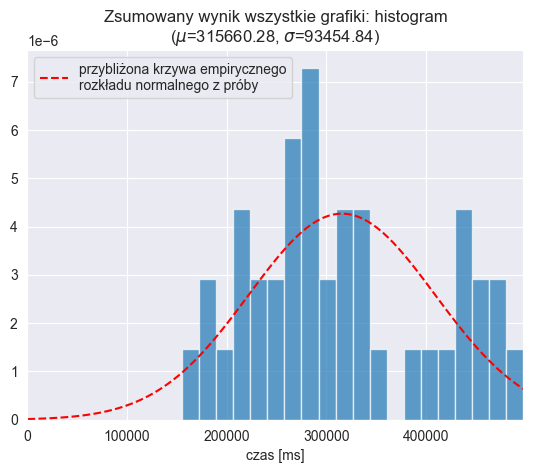

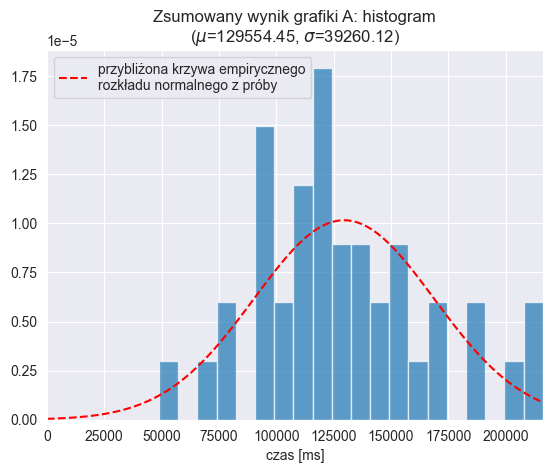

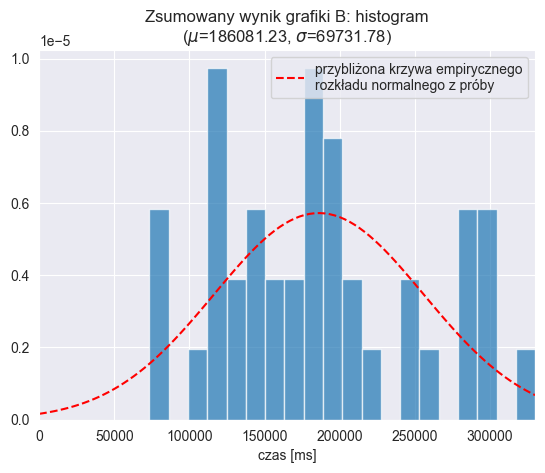

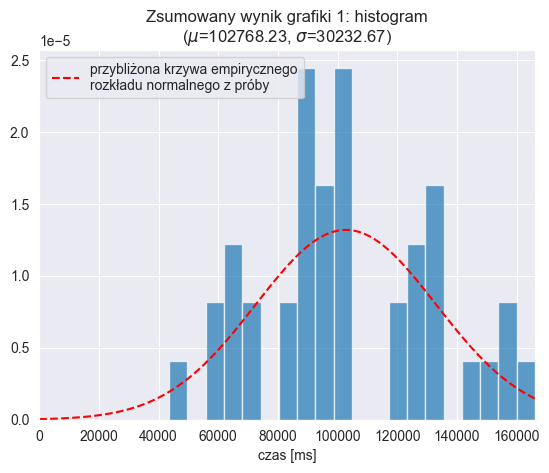

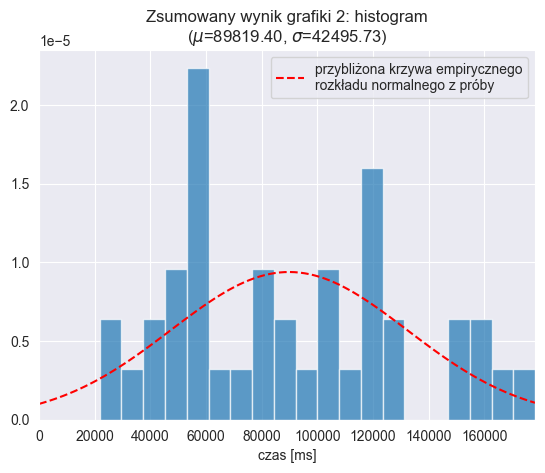

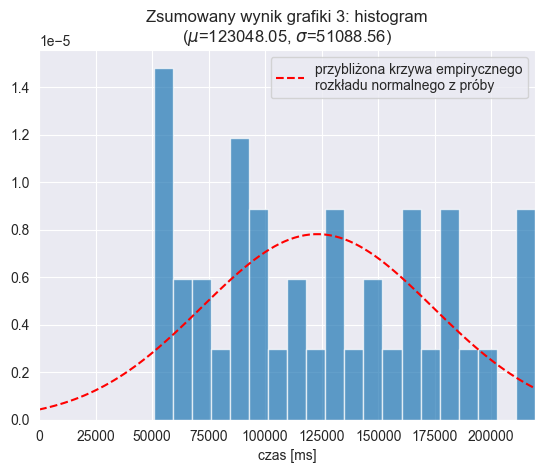

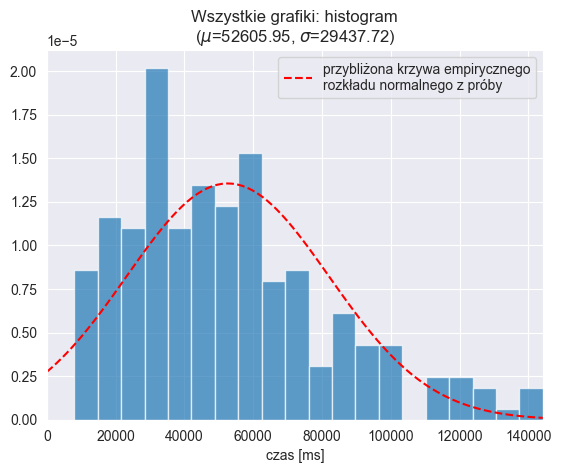

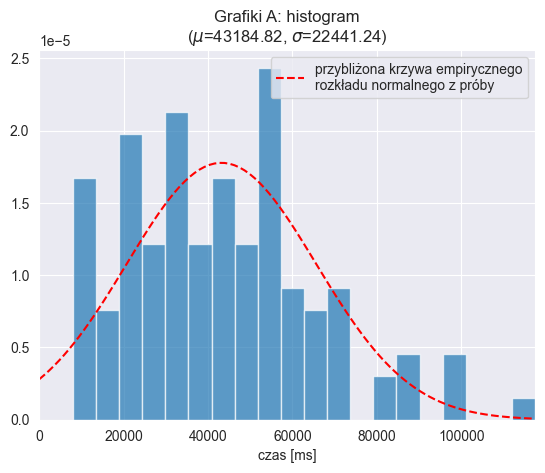

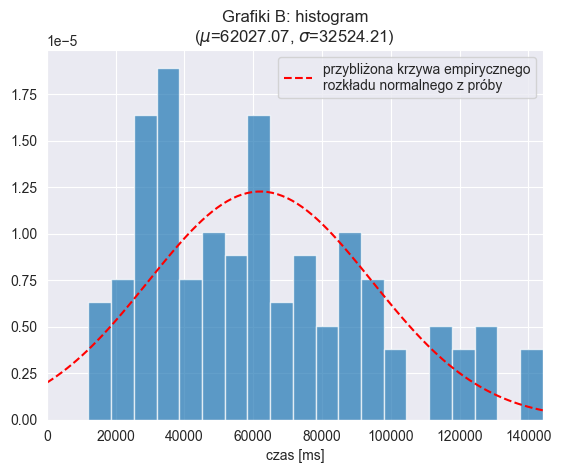

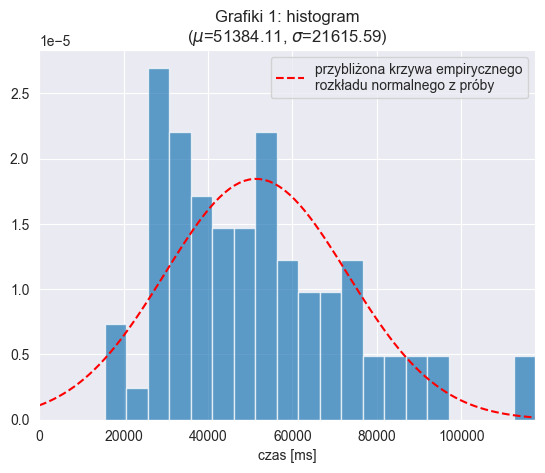

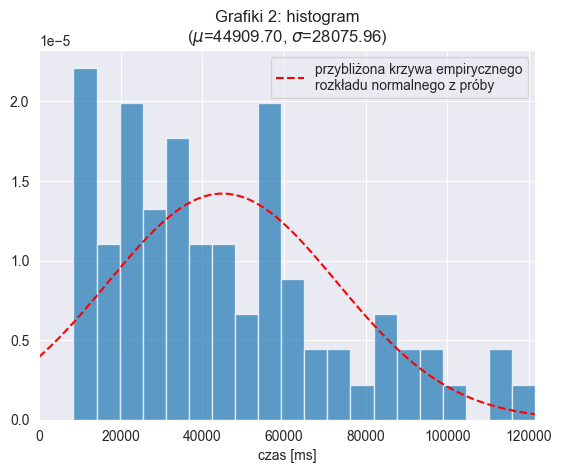

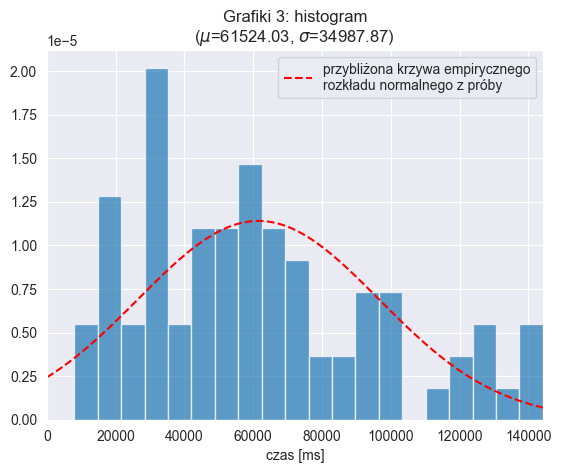

In [21]:
for i, df in enumerate(dfs):
    mu, sigma = df['czas'].mean(), df['czas'].std() # Parametry rozkładu normalnego
    x = np.linspace(0, max(df['czas']), 100)
    y = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    plt.xlim([0, max(df['czas'])])
    plt.xlabel('czas [ms]')

    plt.hist(df['czas'], 20, density=True, alpha=0.7)  # Użycie density=True, aby znormalizować histogram
    plt.plot(x, y, '--r', label='przybliżona krzywa empirycznego\nrozkładu normalnego z próby')  # Dodanie linii przybliżającej
    plt.title(f"{names[i+1]} histogram\n($\mu$={mu:.2f}, $\sigma$={sigma:.2f})")
    plt.legend()
    plt.show()

Testy:

In [22]:
# płeć
test_for_gauss_variable(dfs_gauss, 'Płeć')
test_for_non_gauss_variable(dfs_nogauss, 'Płeć')

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 0.00014318732834280872
Homogeniczność wariancji zachowana.
F-value: 0.029687230126633275
p-value:  0.8641162144260376
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 0.7501358785239255
Homogeniczność wariancji zachowana.
F-value: 0.8324573239868427
p-value:  0.367315313234041
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 0.6167973756279626
Homogeniczność wariancji zachowana.
F-value: 0.6005247560372188
p-value:  0.4431735195920957
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 1.4575268856622896
Homogeniczność wariancji zachowana.
F-value: 0.5644496720701586
p-value:  0.45710082216356207
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 2.5716996798879763
Homogenicznoś

In [23]:
# Rok urodzenia
test_for_gauss_variable(dfs_gauss, 'Rok_urodzenia')
test_for_non_gauss_variable(dfs_nogauss, 'Rok_urodzenia')

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 0.6095853589647343
Homogeniczność wariancji zachowana.
F-value: 1.2163710309698064
p-value:  0.32143658410207326
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 1.7301740978757556
Homogeniczność wariancji zachowana.
F-value: 0.39234504219546723
p-value:  0.812685766353709
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 1.1185980982852974
Homogeniczność wariancji zachowana.
F-value: 1.638404199084763
p-value:  0.18651980573509072
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 2.063937601474633
Homogeniczność wariancji zachowana.
F-value: 2.470231275340687
p-value:  0.0625316076688252
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 0.6969561823172983
Homogeniczność waria

In [24]:
test_posthoc(df_all, 'Rok_urodzenia')

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj     lower      upper    reject
-------------------------------------------------------------
  2000   2001 10368.1458 0.9239 -24333.8855 45070.1771  False
  2000   2002 22428.2879 0.3735 -11743.9103 56600.4861  False
  2000   2003 21022.4412 0.4257 -12643.4742 54688.3566  False
  2000   2004 13051.1111  0.877 -24727.6754 50829.8977  False
  2001   2002  12060.142 0.1906   -3142.326 27262.6101  False
  2001   2003 10654.2953 0.2287  -3373.1694 24681.7601  False
  2001   2004  2682.9653 0.9973 -19466.8117 24832.7423  False
  2002   2003 -1405.8467 0.9981 -14065.9383 11254.2449  False
  2002   2004 -9377.1768 0.7458 -30687.2864 11932.9329  False
  2003   2004 -7971.3301  0.822 -28459.7537 12517.0936  False
-------------------------------------------------------------


In [25]:
# kierunek studiów
test_for_gauss_variable(dfs_gauss, 'Kierunek_studiów')
test_for_non_gauss_variable(dfs_nogauss, 'Kierunek_studiów')

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 0.9591902369915043
Homogeniczność wariancji zachowana.
F-value: 0.0554039903562695
p-value:  0.9461811919855011
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 0.3918841052218947
Homogeniczność wariancji zachowana.
F-value: 1.9244734524754623
p-value:  0.1602824220076326
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 1.9677145356864485
Homogeniczność wariancji zachowana.
F-value: 0.20026841903127646
p-value:  0.8193923957368512
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 1.3718300770111833
Homogeniczność wariancji zachowana.
F-value: 0.9004117922700111
p-value:  0.41512073927242776
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 0.3044198149328592
Homogeniczność wa

In [26]:
# rok studiów
test_for_gauss_variable(dfs_gauss, 'Rok_studiów')
test_for_non_gauss_variable(dfs_nogauss, 'Rok_studiów')

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 0.2836372451751105
Homogeniczność wariancji zachowana.
F-value: 0.048093123881102706
p-value:  0.9531045073661524
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 2.17317755056557
Homogeniczność wariancji zachowana.
F-value: 0.2562582024254322
p-value:  0.7753043588528918
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 1.0497366081545163
Homogeniczność wariancji zachowana.
F-value: 2.404307163366381
p-value:  0.10430739007340309
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 1.2526172739063663
Homogeniczność wariancji zachowana.
F-value: 1.0954905513067779
p-value:  0.3449756049599485
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 1.8137349654267918
Homogeniczność wari

In [27]:
test_posthoc(df_all, 'Rok_studiów')
test_posthoc(df_b, 'Rok_studiów')

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower      upper    reject
--------------------------------------------------------------
     1      2   2138.4783 0.9004  -9418.9471 13695.9036  False
     1      3   -9558.244 0.1058 -20629.0433  1512.5554  False
     2      3 -11696.7222 0.1105 -25378.6526  1985.2081  False
--------------------------------------------------------------
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj     lower      upper    reject
-------------------------------------------------------------
     1      2   1126.962 0.9881 -16995.0606 19248.9845  False
     1      3 -14292.876 0.1282 -31651.8698  3066.1178  False
     2      3 -15419.838 0.2071 -36873.0806  6033.4046  False
-------------------------------------------------------------


In [28]:
# specjalność
param = 'Specjalność'
test_for_gauss_variable(dfs_gauss, param)
test_for_non_gauss_variable(dfs_nogauss, param)

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 0.29468421682165924
Homogeniczność wariancji zachowana.
F-value: 0.561242509265832
p-value:  0.6440610242592689
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 0.6017139307330875
Homogeniczność wariancji zachowana.
F-value: 1.9104587607350165
p-value:  0.14533339379286872
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 1.9606823221393794
Homogeniczność wariancji zachowana.
F-value: 0.16745017539393908
p-value:  0.9176330511688179
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 1.0054114966997114
Homogeniczność wariancji zachowana.
F-value: 1.1007672089445646
p-value:  0.36143495465040415
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 0.37401329331799404
Homogeniczność 

In [29]:
# wady wzroku
param = 'Wady_wzroku'
test_for_gauss_variable(dfs_gauss, param)
test_for_non_gauss_variable(dfs_nogauss, param)

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 2.2140964496761644
Homogeniczność wariancji zachowana.
F-value: 0.12092940184084218
p-value:  0.7299476048649709
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 0.00718053155418329
Homogeniczność wariancji zachowana.
F-value: 0.7758262678099918
p-value:  0.38395779469159474
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 0.02285662303435562
Homogeniczność wariancji zachowana.
F-value: 0.3340401621626884
p-value:  0.566699168425985
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 2.138721434267953
Homogeniczność wariancji zachowana.
F-value: 0.9332129038804038
p-value:  0.3401375868355422
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 0.5581820132714425
Homogeniczność wa

In [30]:
# ilość snu
param = 'Ilość_snu'
test_for_gauss_variable(dfs_gauss, param)
test_for_non_gauss_variable(dfs_nogauss, param)

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 0.4119904034671979
Homogeniczność wariancji zachowana.
F-value: 0.9322897950231643
p-value:  0.4565367780834809
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 0.8221446354406353
Homogeniczność wariancji zachowana.
F-value: 0.7733386717485782
p-value:  0.5499694560647042
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 1.413766245128924
Homogeniczność wariancji zachowana.
F-value: 0.5073683817375803
p-value:  0.730584369759171
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 0.7222741140924692
Homogeniczność wariancji zachowana.
F-value: 0.31424827314183784
p-value:  0.8665054559145202
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 0.9384874985407857
Homogeniczność waria

In [31]:
# matura - j.pol - podst
param = 'JP_podst'
test_for_gauss_variable(dfs_gauss, param)
test_for_non_gauss_variable(dfs_nogauss, param)

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 2.1169322769769128
Homogeniczność wariancji zachowana.
F-value: 0.5911886144054932
p-value:  0.6247900614874617
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 0.7587077662859419
Homogeniczność wariancji zachowana.
F-value: 1.762381383739451
p-value:  0.17178890090856502
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 0.6563583677571697
Homogeniczność wariancji zachowana.
F-value: 3.782689828102383
p-value:  0.018595298561510713
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 0.5345595171411331
Homogeniczność wariancji zachowana.
F-value: 0.1891637991264788
p-value:  0.9030864771446512
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 1.20636

In [32]:
test_posthoc(df_sum1, param)

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
 group1    group2    meandiff  p-adj     lower      upper    reject
-------------------------------------------------------------------
30 - 49%  50 - 69%   8619.9538 0.9323 -30267.5672 47507.4748  False
30 - 49%  70 - 89%   9127.7412 0.9135 -28467.4729 46722.9552  False
30 - 49% 90 - 100%    -35662.0 0.1874 -82398.9836 11074.9836  False
50 - 69%  70 - 89%    507.7873    1.0 -26718.9233 27734.4979  False
50 - 69% 90 - 100% -44281.9538 0.0204 -83169.4748 -5394.4328   True
70 - 89% 90 - 100% -44789.7412 0.0142 -82384.9552 -7194.5271   True
-------------------------------------------------------------------


In [33]:
# matura - mat - podst
param = 'MAT_podst'
test_for_gauss_variable(dfs_gauss, param)
test_for_non_gauss_variable(dfs_nogauss, param)

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 2.1868334264282185
Homogeniczność wariancji zachowana.
F-value: 0.5725605726099333
p-value:  0.6367313708755638
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 1.276136761728165
Homogeniczność wariancji zachowana.
F-value: 0.62111986645299
p-value:  0.6059295385440209
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 0.7251227210611334
Homogeniczność wariancji zachowana.
F-value: 0.328704889559788
p-value:  0.8045965080061852
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 0.940592027566409
Homogeniczność wariancji zachowana.
F-value: 0.38946047151817825
p-value:  0.7612740629495411
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 2.6343694421649246
Homogeniczność wariancj

In [34]:
test_posthoc(df_all, param)
test_posthoc(df_a, param)
test_posthoc(df_3, param)

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
 group1    group2    meandiff  p-adj     lower      upper    reject
-------------------------------------------------------------------
30 - 49%  50 - 69%  38487.8889 0.0273   3050.1676 73925.6102   True
30 - 49%  70 - 89%  21604.1667 0.3004 -10338.9637  53547.297  False
30 - 49% 90 - 100%  21200.4514 0.2997 -10122.3649 52523.2677  False
50 - 69%  70 - 89% -16883.7222 0.1248 -36694.0107  2926.5662  False
50 - 69% 90 - 100% -17287.4375 0.0837 -36081.1273  1506.2523  False
70 - 89% 90 - 100%   -403.7153 0.9997 -11254.2571 10446.8266  False
-------------------------------------------------------------------
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
 group1    group2   meandiff  p-adj     lower      upper    reject
------------------------------------------------------------------
30 - 49%  50 - 69% 37290.5556 0.0572   -787.4524 75368.5635  False
30 - 49%  70 - 89% 31264.1667 0.0878  -3058.8858 655

In [35]:
# matura - pol - roz
param = 'JP_roz'
test_for_gauss_variable(dfs_gauss, param)
test_for_non_gauss_variable(dfs_nogauss, param)

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 0.5373447434787216
Homogeniczność wariancji zachowana.
F-value: 2.272004831810854
p-value:  0.09675707689380272
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 0.7972980294675608
Homogeniczność wariancji zachowana.
F-value: 4.262464331876314
p-value:  0.011255749408375523
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 0.8772493495518289
Homogeniczność wariancji zachowana.
F-value: 6.773968066279236
p-value:  0.0009725087353372898
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 0.6957754954659704
Homogeniczność wariancji zachowana.
F-value: 0.4772872809109613
p-value:  0.7000740228305846
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumo

In [36]:
test_posthoc(df_sumAll, param)
test_posthoc(df_sumB, param)
test_posthoc(df_sum1, param)
test_posthoc(df_sum3, param)
test_posthoc(df_all, param)
test_posthoc(df_b, param)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
 group1     group2     meandiff   p-adj     lower        upper    reject
------------------------------------------------------------------------
20 - 49%    50 - 70%    -108809.8 0.6253 -351217.6704 133598.0704  False
20 - 49%      NO_VAL -189368.0968 0.1246 -414196.0131  35459.8195  False
20 - 49% powyżej 70% -291536.3333 0.0201 -547056.6644 -36016.0022   True
50 - 70%      NO_VAL  -80558.2968 0.1945 -187203.5414  26086.9478  False
50 - 70% powyżej 70% -182726.5333 0.0215 -344331.7803 -21121.2864   True
  NO_VAL powyżej 70% -102168.2366 0.1869 -235967.6093  31631.1362  False
------------------------------------------------------------------------
          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
 group1     group2     meandiff   p-adj     lower        upper    reject
------------------------------------------------------------------------
20 - 49%    50 - 70%     -50174.2 0.8825 -234112.78

In [37]:
# matura - mat - roz
param = 'MAT_roz'
test_for_gauss_variable(dfs_gauss, param)
test_for_non_gauss_variable(dfs_nogauss, param)

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 0.2792067261407582
Homogeniczność wariancji zachowana.
F-value: 0.29416650629730573
p-value:  0.8797693514102655
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 0.7696249985969693
Homogeniczność wariancji zachowana.
F-value: 0.7335292989150055
p-value:  0.5753021278320312
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 1.5373602473844659
Homogeniczność wariancji zachowana.
F-value: 0.7374733203176032
p-value:  0.5727599994881016
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 0.5186754031459024
Homogeniczność wariancji zachowana.
F-value: 0.5670463309368098
p-value:  0.6881867981384112
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 1.080519942304595
Homogeniczność wari

In [38]:
# matura - hist - roz
param = 'HIST_roz'
test_for_gauss_variable(dfs_gauss, param)
test_for_non_gauss_variable(dfs_nogauss, param)

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 1.0088321587606663
Homogeniczność wariancji zachowana.
F-value: 0.3149980690880136
p-value:  0.7317280117655023
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 0.697195325163255
Homogeniczność wariancji zachowana.
F-value: 1.1175628716236568
p-value:  0.3378652237291926
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 0.7957096924355919
Homogeniczność wariancji zachowana.
F-value: 1.489199463258253
p-value:  0.2387602610884553
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 3.0663989283572057
Homogeniczność wariancji zachowana.
F-value: 0.8439003339755445
p-value:  0.4381392155660573
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 1.5560554764847476
Homogeniczność warian

In [39]:
# samopoczucie
param = 'Samopocz'
test_for_gauss_variable(dfs_gauss, param)
test_for_non_gauss_variable(dfs_nogauss, param)

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 0.9846428965156512
Homogeniczność wariancji zachowana.
F-value: 1.7950134068280652
p-value:  0.16557063186381643
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 2.020616971626786
Homogeniczność wariancji zachowana.
F-value: 2.5149527916350984
p-value:  0.07375781178936505
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 0.350936682869387
Homogeniczność wariancji zachowana.
F-value: 0.4547824234466561
p-value:  0.7155363579088478
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 1.1751750477030323
Homogeniczność wariancji zachowana.
F-value: 5.591502759171825
p-value:  0.0029693786231123486
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 2.0694

In [40]:
test_posthoc(df_sumAll, param)
test_posthoc(df_sum2, param)
test_posthoc(df_sum3, param)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff   p-adj     lower        upper    reject
-----------------------------------------------------------------
     2      3      41569.6  0.857  -99538.2368 182677.4368  False
     2      4      -3582.3 0.9998 -120098.2614 112933.6614  False
     2      5  -88161.8444 0.2778  -218140.841  41817.1521  False
     3      4     -45151.9 0.6791  -153622.357   63318.557  False
     3      5 -129731.4444 0.0351 -252550.0517  -6912.8371   True
     4      5  -84579.5444 0.0884 -178115.4091   8956.3202  False
-----------------------------------------------------------------
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
group1 group2   meandiff  p-adj     lower        upper    reject
----------------------------------------------------------------
     2      3  30073.6333 0.5322  -29502.7529  89650.0195  False
     2      4   -28305.05 0.4195  -77498.6318  20888.5318  False
     2      5 -

In [41]:
# zmęczenie
param = 'Zmęcz'
test_for_gauss_variable(dfs_gauss, param)
test_for_non_gauss_variable(dfs_nogauss, param)

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 0.7435274393505366
Homogeniczność wariancji zachowana.
F-value: 0.4149349683174681
p-value:  0.7966855211137795
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 2.0546633456503227
Homogeniczność wariancji zachowana.
F-value: 1.3304751559765096
p-value:  0.2779826847694705
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 2.6191704276381382
Homogeniczność wariancji zachowana.
F-value: 0.6145213709281385
p-value:  0.6550226818496347
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 0.5567051083854175
Homogeniczność wariancji zachowana.
F-value: 0.4819756816403173
p-value:  0.7487582470025687
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 3.215798321738391
Brak homogeniczności

In [42]:
test_posthoc(df_all, param)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower      upper    reject
--------------------------------------------------------------
     1      2  11162.9583 0.3315  -5168.8003  27494.717  False
     1      3  10753.4056  0.404  -6113.9622 27620.7734  False
     1      4  -2002.6667 0.9977 -19217.8518 15212.5185  False
     1      5   7362.6111 0.9054 -15733.9835 30459.2057  False
     2      3   -409.5528    1.0 -14395.2353 13576.1298  False
     2      4  -13165.625 0.0912 -27568.8823  1237.6323  False
     2      5  -3800.3472 0.9877  -24884.557 17283.8625  False
     3      4 -12756.0722 0.1371 -27763.9227  2251.7783  False
     3      5  -3390.7944 0.9926 -24892.5538 18110.9649  False
     4      5   9365.2778 0.7615 -12410.4004  31140.956  False
--------------------------------------------------------------


In [43]:
# czytanie map
param = 'Czyt_map'
test_for_gauss_variable(dfs_gauss, param)
test_for_non_gauss_variable(dfs_nogauss, param)

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 0.8004026872436566
Homogeniczność wariancji zachowana.
F-value: 1.4880474268624158
p-value:  0.23901497263836138
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 2.5498049659105755
Homogeniczność wariancji zachowana.
F-value: 0.33250947196036906
p-value:  0.7192425573168513
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 3.1959760453853128
Homogeniczność wariancji zachowana.
F-value: 0.008266917717905196
p-value:  0.9917689906063979
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 1.565324943571208
Homogeniczność wariancji zachowana.
F-value: 1.465569207979098
p-value:  0.2440425731332461
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 1.3865917419108202
Homogeniczność wa

In [44]:
# podzielność uwagi
param = 'Podziel_uwg'
test_for_gauss_variable(dfs_gauss, param)
test_for_non_gauss_variable(dfs_nogauss, param)

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 0.9486765925686509
Homogeniczność wariancji zachowana.
F-value: 1.299183751439874
p-value:  0.2893311646487883
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 0.5231396618524977
Homogeniczność wariancji zachowana.
F-value: 1.05034441491811
p-value:  0.3954925387378661
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 0.32154241708735243
Homogeniczność wariancji zachowana.
F-value: 3.2474596081877447
p-value:  0.022895709735807464
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 2.3801022487423817
Homogeniczność wariancji zachowana.
F-value: 0.5769989179469104
p-value:  0.6811843959071643
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 0.911666

In [45]:
test_posthoc(df_sum1, param)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower       upper    reject
---------------------------------------------------------------
     1      2 -19542.6429 0.8971  -82368.4963 43283.2106  False
     1      3 -22370.9286 0.8125  -81603.7113 36861.8541  False
     1      4   2238.2778    1.0  -59016.6808 63493.2363  False
     1      5    -43270.5 0.2833 -105217.6269 18676.6269  False
     2      3  -2828.2857 0.9994  -39100.8091 33444.2377  False
     2      4  21780.9206  0.516  -17707.6012 61269.4424  False
     2      5 -23727.8571 0.4576  -64281.7712 16826.0569  False
     3      4  24609.2063 0.2373   -8868.8168 58087.2295  False
     3      5 -20899.5714 0.4294  -55627.8686 13828.7258  False
     4      5 -45508.7778 0.0125  -83583.7305 -7433.8251   True
---------------------------------------------------------------


In [46]:
# analityczne myślenie
param = 'Analit_myśl'
test_for_gauss_variable(dfs_gauss, param)
test_for_non_gauss_variable(dfs_nogauss, param)

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 0.5096951425202504
Homogeniczność wariancji zachowana.
F-value: 1.1410467867636724
p-value:  0.34561854854268437
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 3.7463086139512995
Brak homogeniczności wariancji.
H: 2.503403742171386
p-value:  0.4746762649646228
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 0.6970940410782832
Homogeniczność wariancji zachowana.
F-value: 2.2744101280387024
p-value:  0.09649656510537709
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 0.8278481070854261
Homogeniczność wariancji zachowana.
F-value: 0.19790947622632646
p-value:  0.8971279476249183
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 0.8452678180819668
Homogeniczność wariancji za

In [47]:
# spostrzegawczość
param = 'Spostrzeg'
test_for_gauss_variable(dfs_gauss, param)
test_for_non_gauss_variable(dfs_nogauss, param)

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 1.5411756515368733
Homogeniczność wariancji zachowana.
F-value: 2.1472032056001042
p-value:  0.11130856155865912
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 0.32535576907232827
Homogeniczność wariancji zachowana.
F-value: 0.5188815196437379
p-value:  0.6719745807428523
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 0.8530588141431095
Homogeniczność wariancji zachowana.
F-value: 0.4107669634434521
p-value:  0.7462326268253512
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 0.9637475704932817
Homogeniczność wariancji zachowana.
F-value: 0.46185762291179416
p-value:  0.7106569033646521
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 0.8890434098005217
Homogeniczność w

In [49]:
# czytanie ze zrozumieniem
param = 'Czyt_ze_zroz'
test_for_gauss_variable(dfs_gauss, param)
test_for_non_gauss_variable(dfs_nogauss, param)

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 3.1090700936610514
Brak homogeniczności wariancji.
H: 3.8576245132199034
p-value:  0.4256170464798683
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 0.34758539067447136
Homogeniczność wariancji zachowana.
F-value: 0.1436942823031876
p-value:  0.9645903361285598
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 1.4731120006531533
Homogeniczność wariancji zachowana.
F-value: 3.2124393197221974
p-value:  0.023940510230785295
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 1.206620065565594
Homogeniczność wariancji zachowana.
F-value: 0.08663972896952961
p-value:  0.9860250792477966
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 1.0763717619508

In [50]:
test_posthoc(df_sum1, param)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower       upper    reject
---------------------------------------------------------------
     1      2 -11887.2143 0.9821  -74804.9626  51030.534  False
     1      3    -21429.5 0.8703  -85501.7987 42642.7987  False
     1      4   -741.1471    1.0  -59402.6623 57920.3682  False
     1      5    -40998.0 0.3362 -103035.7364 21039.7364  False
     2      3  -9542.2857 0.9694  -53200.1982 34115.6267  False
     2      4  11146.0672 0.8914  -24094.9207 46387.0552  False
     2      5 -29110.7857 0.2596  -69724.0176 11502.4462  False
     3      4  20688.3529 0.5096  -16574.8144 57951.5203  False
     3      5    -19568.5 0.6763   -61948.342  22811.342  False
     4      5 -40256.8529 0.0124  -73901.5393 -6612.1665   True
---------------------------------------------------------------


In [51]:
# wzrokowiec
param = 'Wzrokowiec'
test_for_gauss_variable(dfs_gauss, param)
test_for_non_gauss_variable(dfs_nogauss, param)

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 1.4000553727674723
Homogeniczność wariancji zachowana.
F-value: 1.8366219009333649
p-value:  0.15796871065759274
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 1.7414045873022868
Homogeniczność wariancji zachowana.
F-value: 0.19546995714376275
p-value:  0.8987951378876803
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 1.0844832952283043
Homogeniczność wariancji zachowana.
F-value: 1.1271463020896926
p-value:  0.3510020364367735
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 1.0690724505966172
Homogeniczność wariancji zachowana.
F-value: 0.636229790353757
p-value:  0.5965645747422872
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 0.29897727801476054
Homogeniczność wa

In [52]:
# słuchowiec
param = 'Słuchowiec'
test_for_gauss_variable(dfs_gauss, param)
test_for_non_gauss_variable(dfs_nogauss, param)

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 0.5403346744807191
Homogeniczność wariancji zachowana.
F-value: 0.8657077459989375
p-value:  0.49412456364455015
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 0.8362861123023206
Homogeniczność wariancji zachowana.
F-value: 0.5829890235556006
p-value:  0.6769817733712401
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 0.8428043930842901
Homogeniczność wariancji zachowana.
F-value: 1.8874388632851435
p-value:  0.13452856640537939
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 0.7403506910834231
Homogeniczność wariancji zachowana.
F-value: 0.2135011731361649
p-value:  0.9291798177752449
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 0.27087894945254715
Homogeniczność w

In [53]:
# kinestetyk
param = 'Kinestetyk'
test_for_gauss_variable(dfs_gauss, param)
test_for_non_gauss_variable(dfs_nogauss, param)

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 0.950257944924464
Homogeniczność wariancji zachowana.
F-value: 0.8214791446160457
p-value:  0.5203386488127362
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 1.2802005469675388
Homogeniczność wariancji zachowana.
F-value: 2.555322110613841
p-value:  0.055946953647781836
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 0.3775619901963137
Homogeniczność wariancji zachowana.
F-value: 1.905232275694174
p-value:  0.13141590889647073
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 1.204254666074738
Homogeniczność wariancji zachowana.
F-value: 1.9094013631152658
p-value:  0.13069698742452363
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 1.315835244748855
Homogeniczność waria

In [54]:
test_posthoc(df_all, param)
test_posthoc(df_b, param)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj     lower      upper    reject
-------------------------------------------------------------
     1      2   9784.866 0.2666  -3628.5724 23198.3044  False
     1      3    16493.0 0.2278  -5199.4148 38185.4148  False
     1      4 10455.3778 0.3083  -4495.0874 25405.8429  False
     1      5 34840.1111 0.0445    541.3917 69138.8305   True
     2      3   6708.134 0.8948 -13668.3416 27084.6096  False
     2      4   670.5118 0.9999 -12296.9979 13638.0215  False
     2      5 25055.2451 0.2424  -8426.7209 58537.2111  False
     3      4 -6037.6222 0.9376 -27457.1656 15381.9212  False
     3      5 18347.1111  0.665 -19225.2535 55919.4757  False
     4      5 24384.7333 0.2868  -9742.0616 58511.5282  False
-------------------------------------------------------------
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower       upper    reject
----

In [55]:
# MAT - pisał / nie pisał matury rozszerzonej
param = 'MAT'
test_for_gauss_variable(dfs_gauss, param)
test_for_non_gauss_variable(dfs_nogauss, param)

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 0.1618881233934377
Homogeniczność wariancji zachowana.
F-value: 0.00042237053101808994
p-value:  0.9837108426108083
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 0.07223354882868288
Homogeniczność wariancji zachowana.
F-value: 0.1420096074627871
p-value:  0.7083875484566803
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 1.4701615475131942
Homogeniczność wariancji zachowana.
F-value: 0.12583816793979108
p-value:  0.7247480408000657
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 2.769488129570476
Homogeniczność wariancji zachowana.
F-value: 0.5078060453148455
p-value:  0.4804431877422044
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 0.13817416147674946
Homogenicznoś

In [56]:
# POL - pisał / nie pisał matury rozszerzonej
param = 'POL'
test_for_gauss_variable(dfs_gauss, param)
test_for_non_gauss_variable(dfs_nogauss, param)

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 1.0164190110400324
Homogeniczność wariancji zachowana.
F-value: 1.2011545288066723
p-value:  0.27998854298796755
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 3.4373716288564764
Homogeniczność wariancji zachowana.
F-value: 0.3386897949873181
p-value:  0.5640234726251102
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 6.133730212569425
Brak homogeniczności wariancji.
H: 0.1639129294518824
p-value:  0.6855792330490789
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 0.014045848832622373
Homogeniczność wariancji zachowana.
F-value: 0.017492680161098548
p-value:  0.8954765781757674
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 0.2075252942812199
Homogeniczność wariancji 

In [57]:
# HIST - pisał / nie pisał matury rozszerzonej
param = 'HIST'
test_for_gauss_variable(dfs_gauss, param)
test_for_non_gauss_variable(dfs_nogauss, param)

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 0.4306429716982918
Homogeniczność wariancji zachowana.
F-value: 1.8570115525566334e-05
p-value:  0.996584226115867
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 0.7930057662346043
Homogeniczność wariancji zachowana.
F-value: 1.0403693634159288
p-value:  0.31418574190518167
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 1.0871825880762416
Homogeniczność wariancji zachowana.
F-value: 2.256816969354989
p-value:  0.14129252392173888
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 1.2893174944172574
Homogeniczność wariancji zachowana.
F-value: 0.46179618737280137
p-value:  0.5009045643352248
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 0.17685921528533516
Homogenicznoś

In [58]:
# dominujący typ uczenia
param = 'Typ_uczenia'
test_for_gauss_variable(dfs_gauss, param)
test_for_non_gauss_variable(dfs_nogauss, param)

-----------------------------------------------
Zsumowany wynik grafiki A:
W: 0.8939579066656674
Homogeniczność wariancji zachowana.
F-value: 0.5131747628523877
p-value:  0.6757908393596446
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki B:
W: 1.1260820010333927
Homogeniczność wariancji zachowana.
F-value: 2.4355535168963476
p-value:  0.08058240683414272
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 1:
W: 0.5714929487653133
Homogeniczność wariancji zachowana.
F-value: 2.0315812148515335
p-value:  0.12677799042679053
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 2:
W: 0.7492578796167388
Homogeniczność wariancji zachowana.
F-value: 0.24593201840670684
p-value:  0.8636750881425609
Brak podstaw do odrzucenia H0.
-----------------------------------------------
Zsumowany wynik grafiki 3:
W: 0.6347905333377853
Homogeniczność w

Podsumowanie:
Istotne statystycznie:
- rok urodzenia: wszystkie grafiki (słabo się różnicuje parami)
- rok studiów: wszystkie grafiki, grafiki B (słabo się różnicują parami)
- matura polski podst: zsumowane grafiki 1: (50-69 vs 90-100) oraz (70-89 vs 90-100)
- matura mat podst: wszystkie grafiki (słabo się różnicuje parami), grafiki A (słabo się różnicuje parami), grafiki 3 (50-69 vs 70-89)
- matura polski roz: zsumowane wszystkie grafiki, zsumowane grafiki B, zsumowane grafiki 1, zsumowane grafiki 3, wszystkie grafiki, grafiki B (jeśli różnicuje parami to 20-49 vs powyzej 70)
- samopoczucie: zsumowane wszystkie grafiki (4 vs 5), zsaumowane grafiki 2 (3 vs 5, 4 vs 5), zsumowane grafiki 3 (4 vs 5)
- zmęczenie: wszystkie grafiki (słabo się róznicuje parami)
- podzielność uwagi: zsumowane grafiki 1 (4 vs 5)
- czytanie ze zrozumieniem: zsumowane grafiki 1 (4 vs 5)
- kinestetyk: wszystkie grafiki, grafiki B (dla obu 1 vs 5) --> fajny wniosek będzie

In [109]:
columns = df_sumAll.columns.to_list()
columns_to_remove = ['Daltonizm', 'Rank_map', 'Rank_txt', 'Rank_plt', 'Rank_tab', 'Data', 'Godzina', 'FIZ_roz', 'czas', 'Quest1_after', 'Quest2_after', 'ID']
for col in columns_to_remove:
    if col in columns:
        columns.remove(col)
columns

['Płeć',
 'Rok_urodzenia',
 'Kierunek_studiów',
 'Rok_studiów',
 'Specjalność',
 'Wady_wzroku',
 'Ilość_snu',
 'JP_podst',
 'MAT_podst',
 'JP_roz',
 'MAT_roz',
 'HIST_roz',
 'Samopocz',
 'Stres',
 'Zmęcz',
 'Czyt_map',
 'Podziel_uwg',
 'Analit_myśl',
 'Spostrzeg',
 'Czyt_ze_zroz',
 'Wzrokowiec',
 'Słuchowiec',
 'Kinestetyk',
 'MAT',
 'POL',
 'HIST',
 'Typ_uczenia']

-------- Płeć ---------


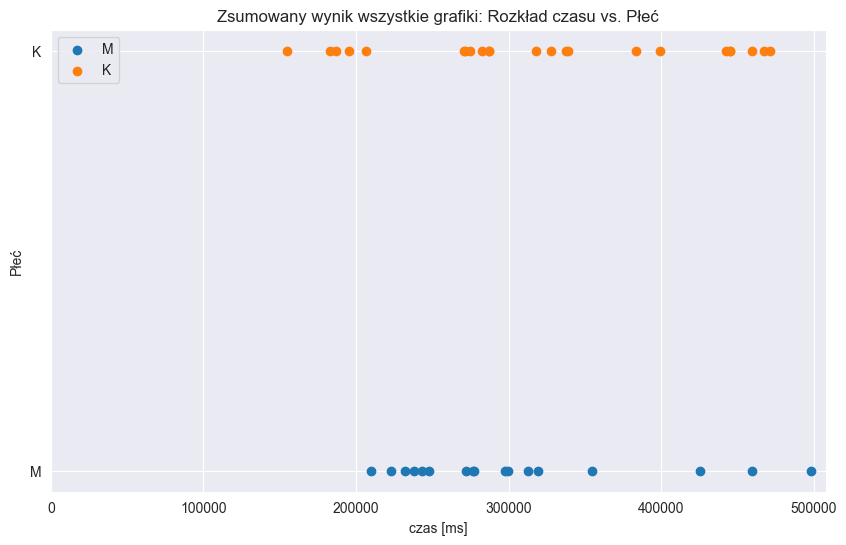

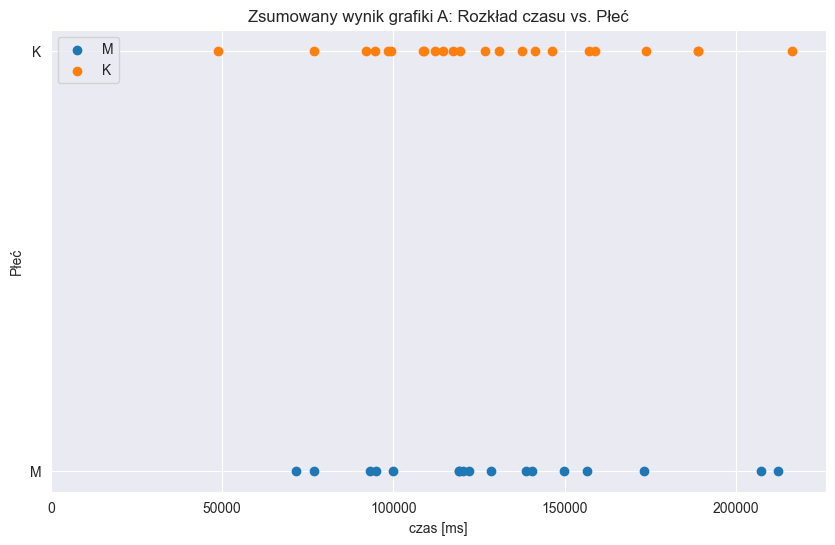

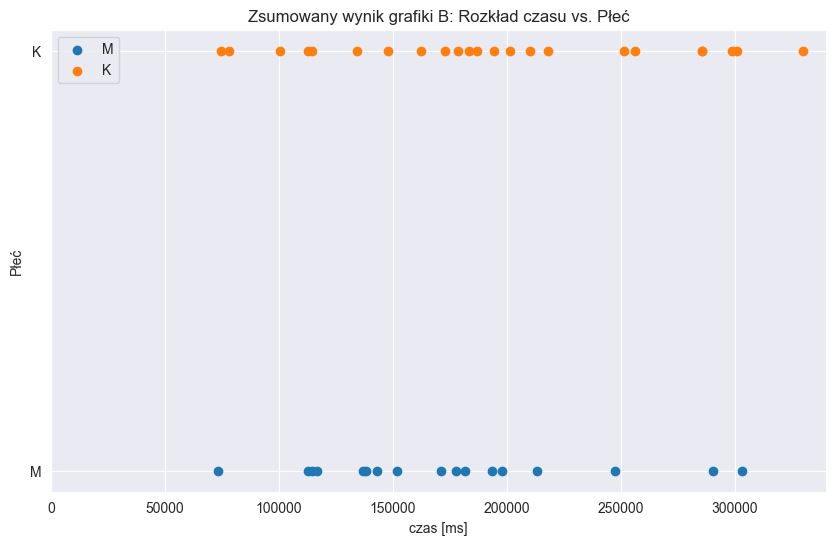

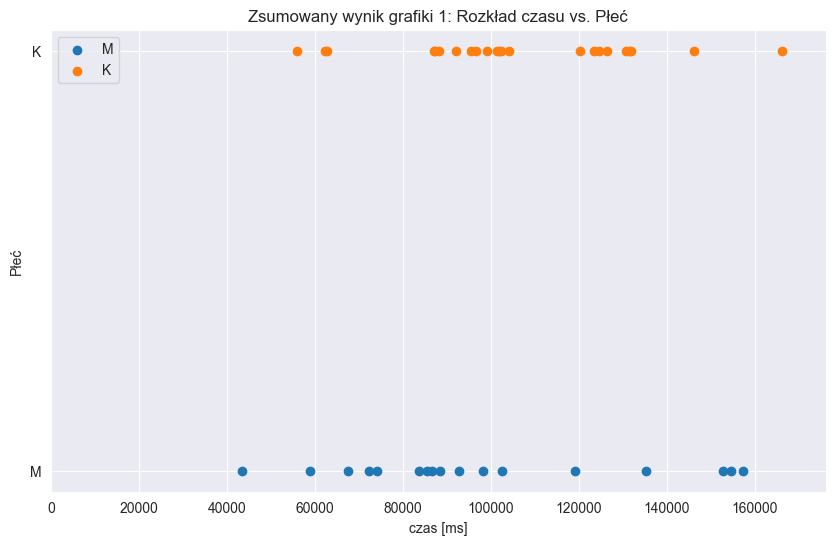

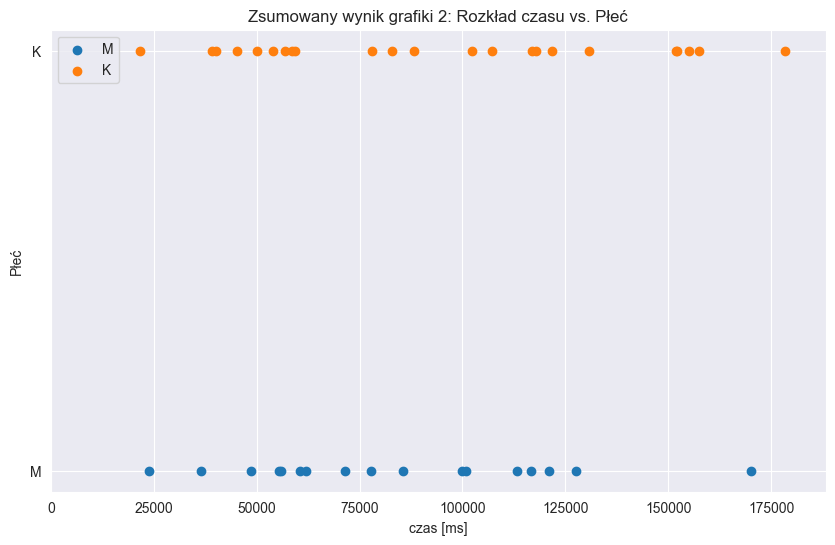

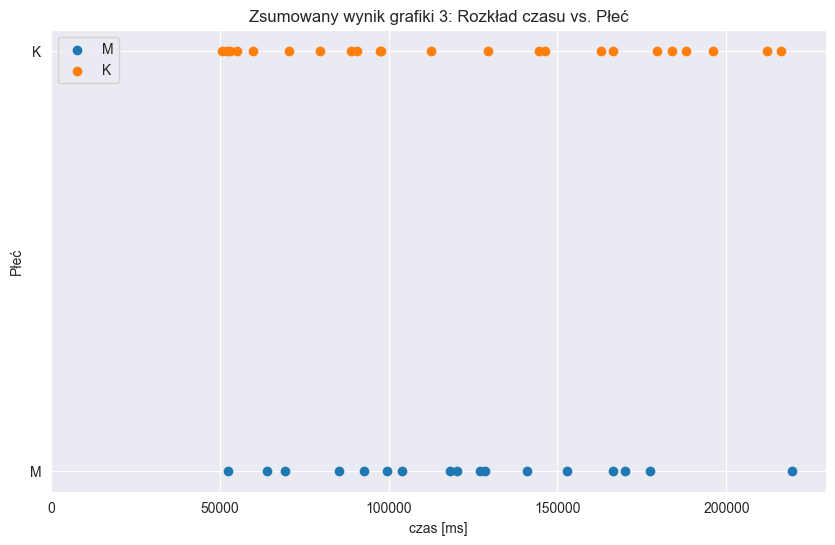

-------- Rok_urodzenia ---------


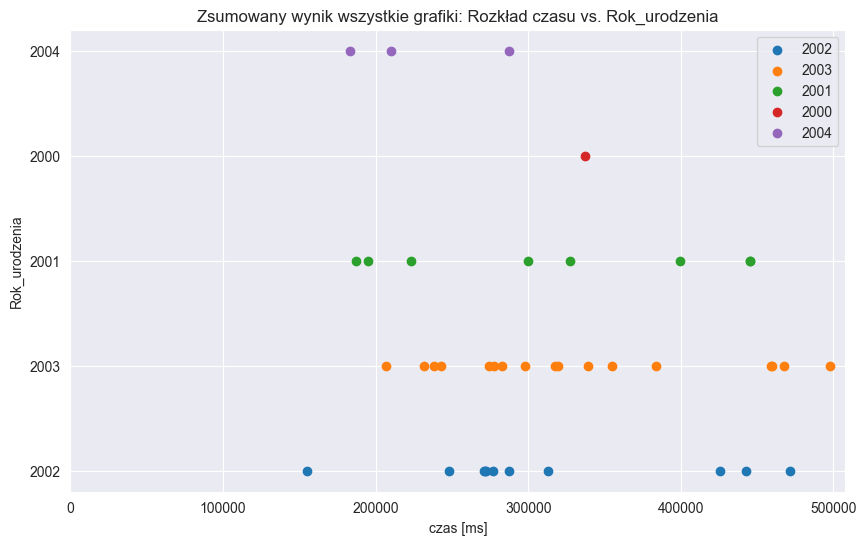

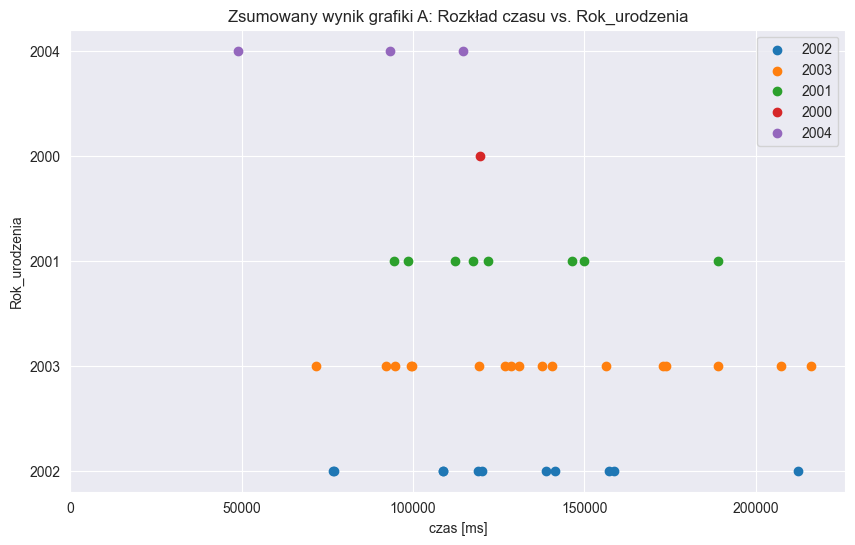

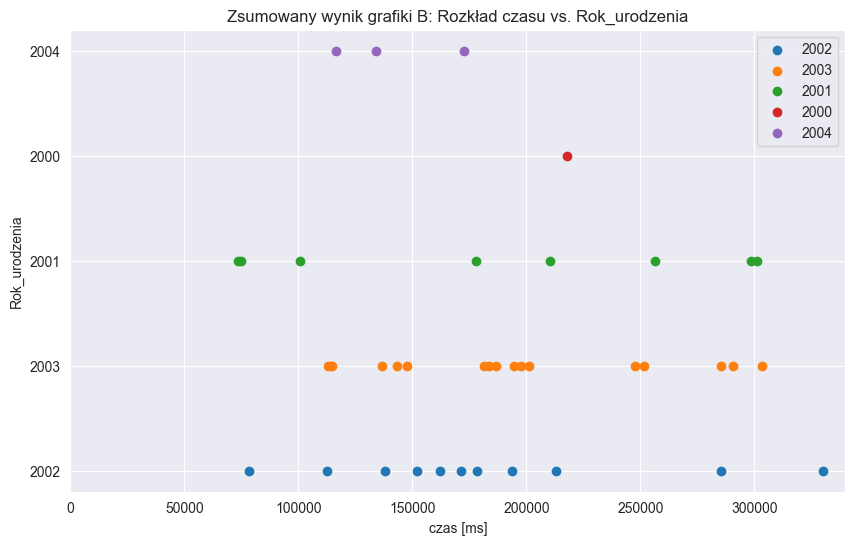

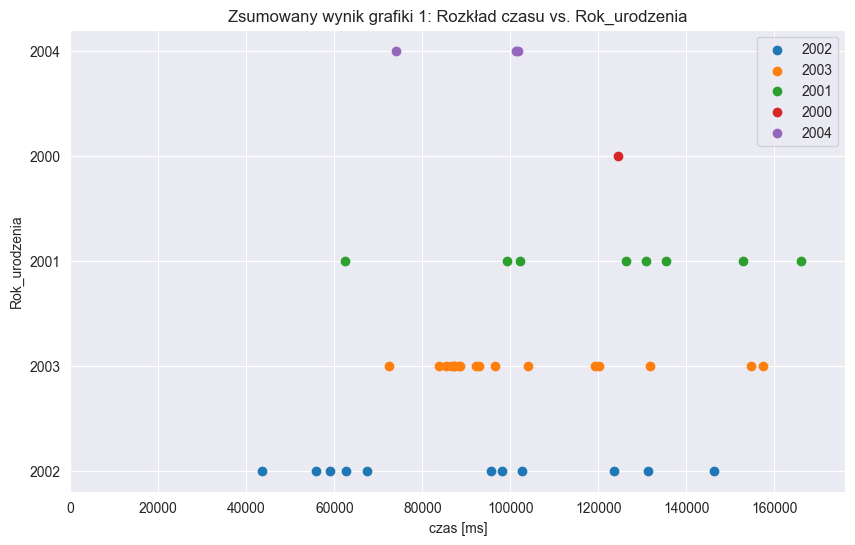

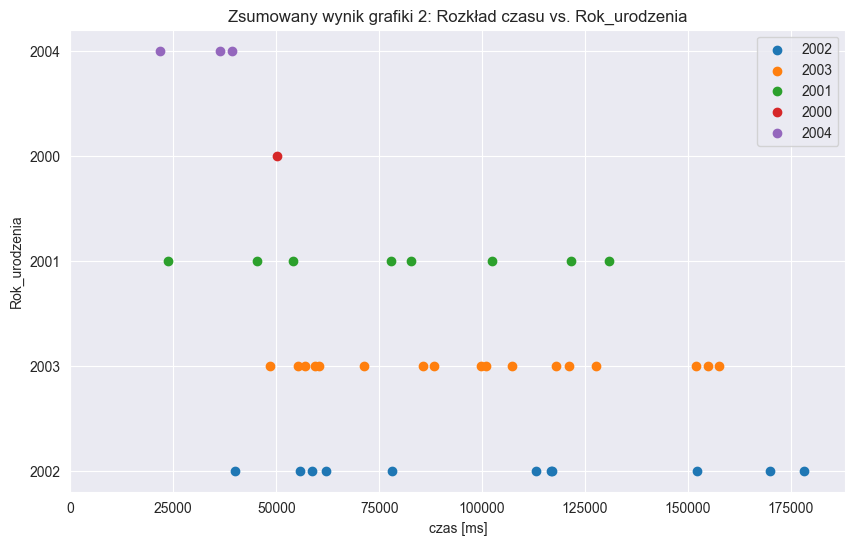

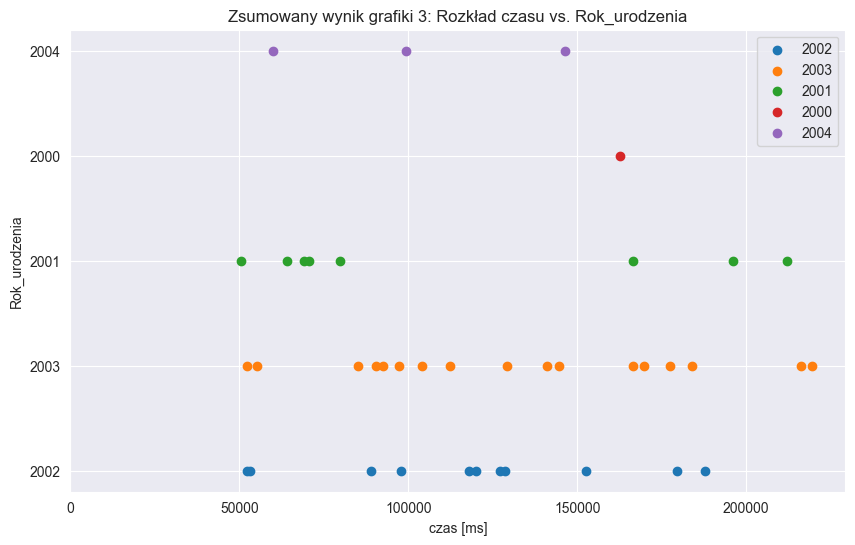

-------- Kierunek_studiów ---------


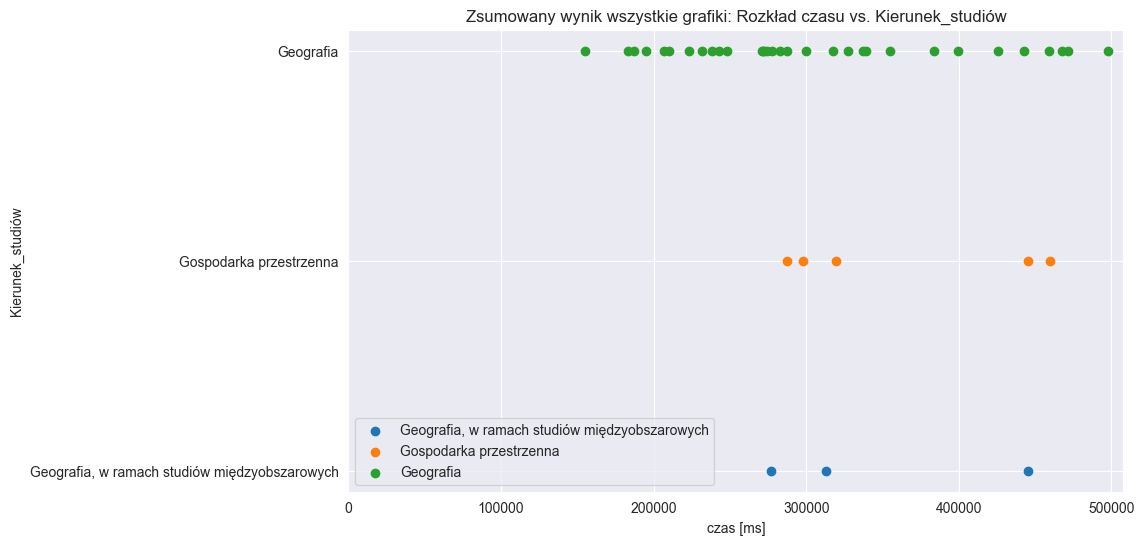

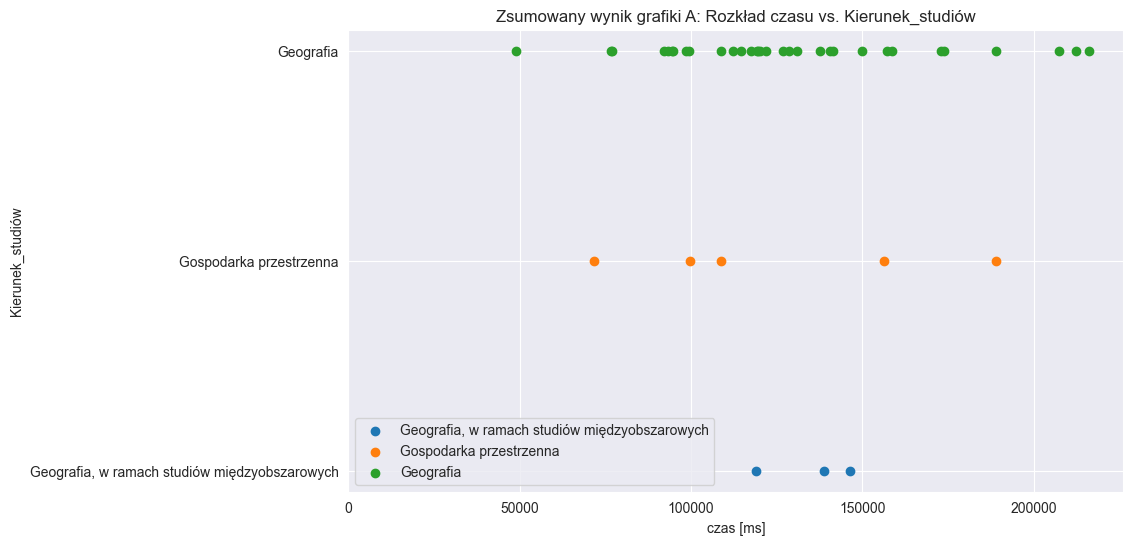

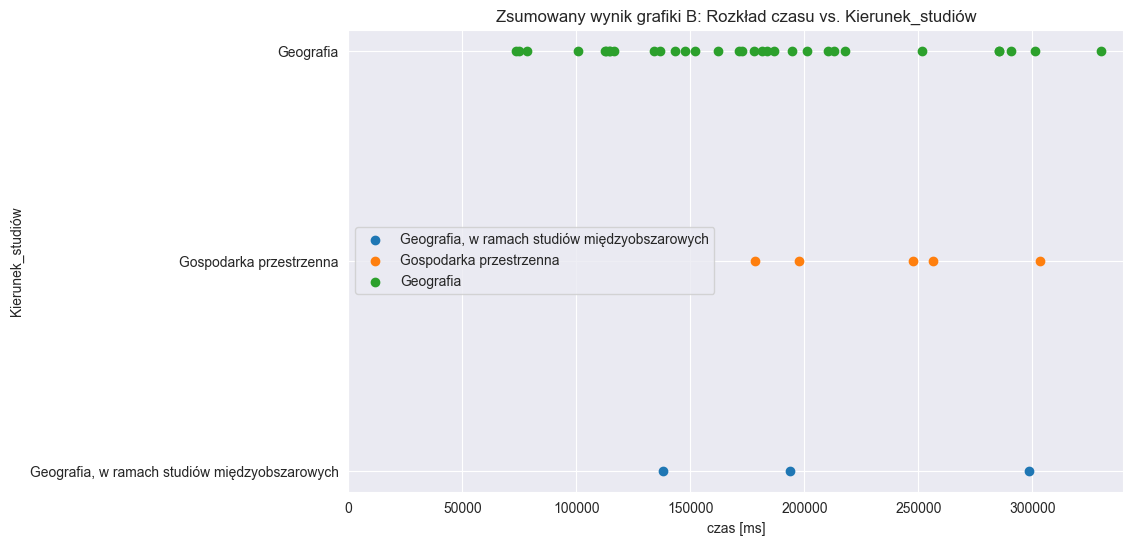

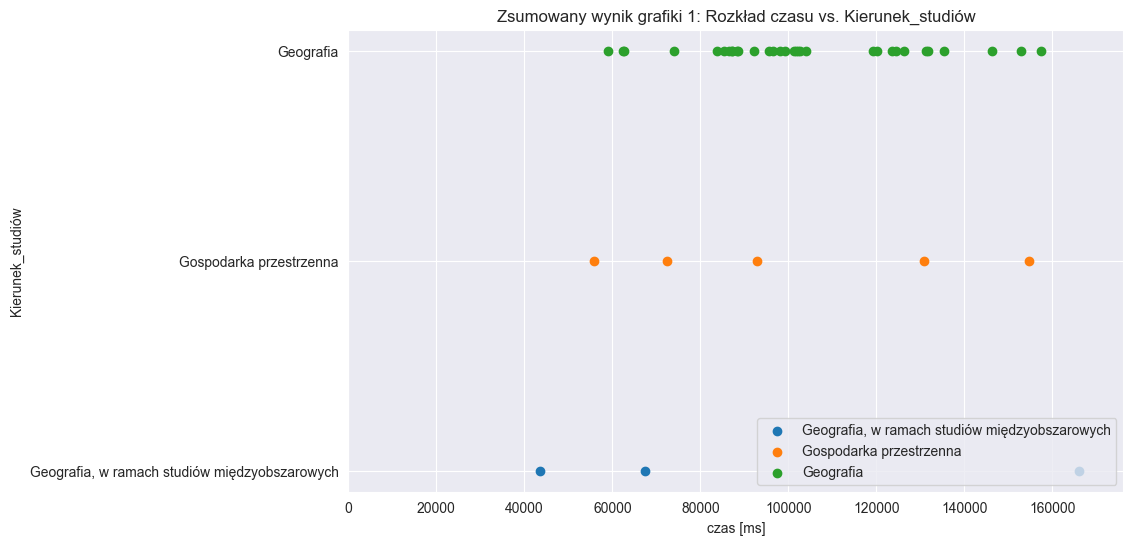

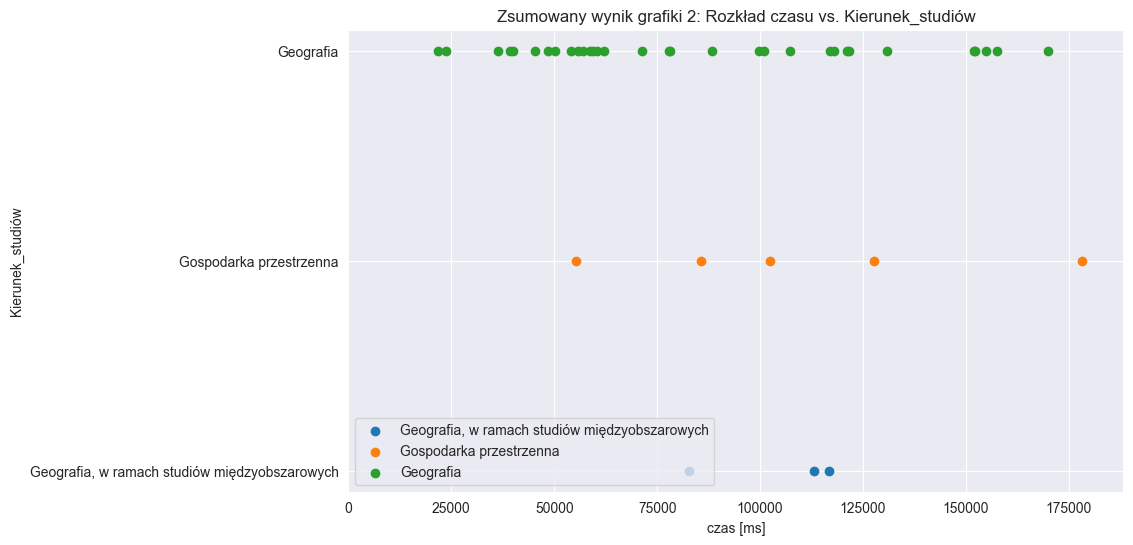

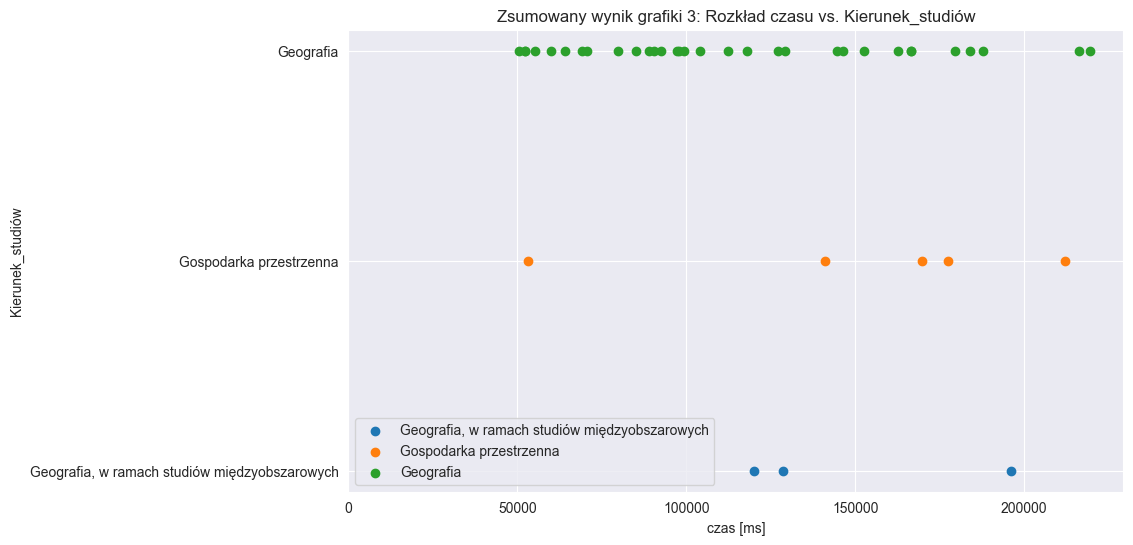

-------- Rok_studiów ---------


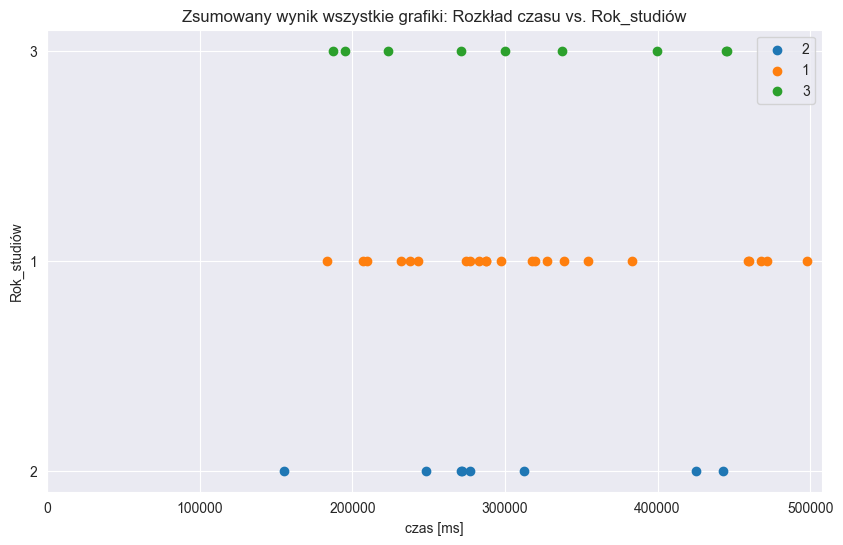

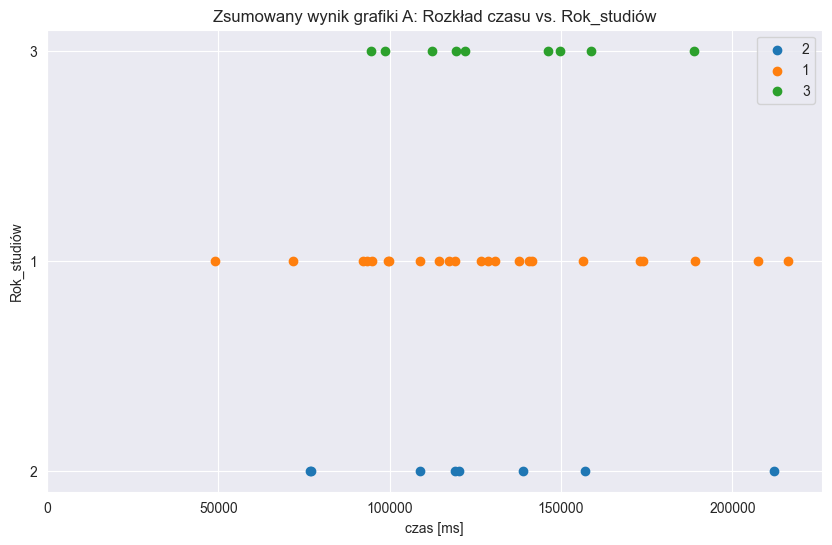

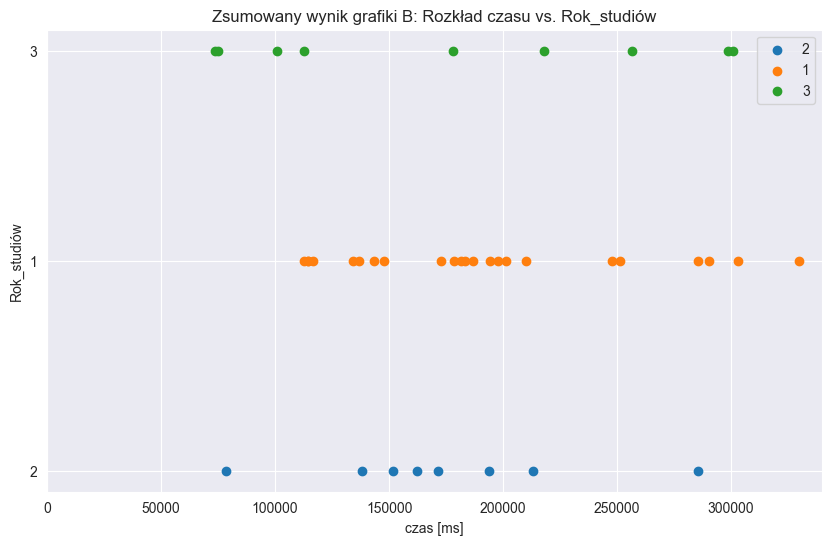

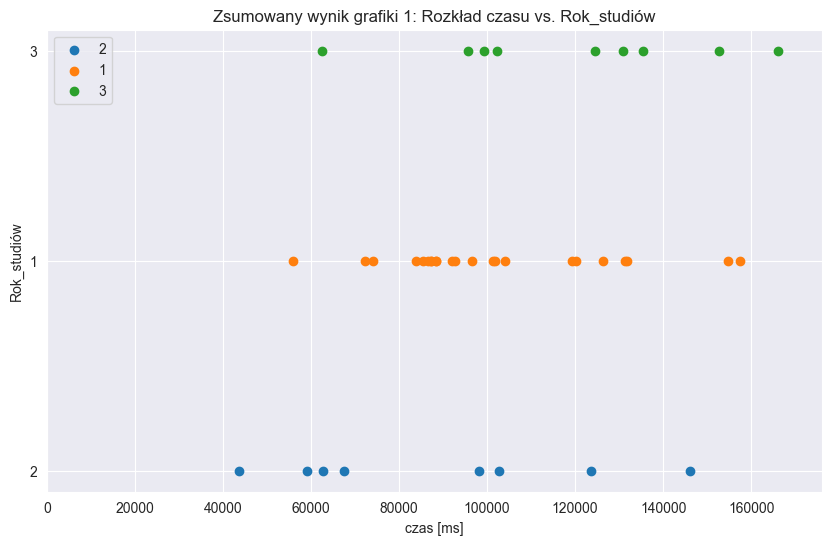

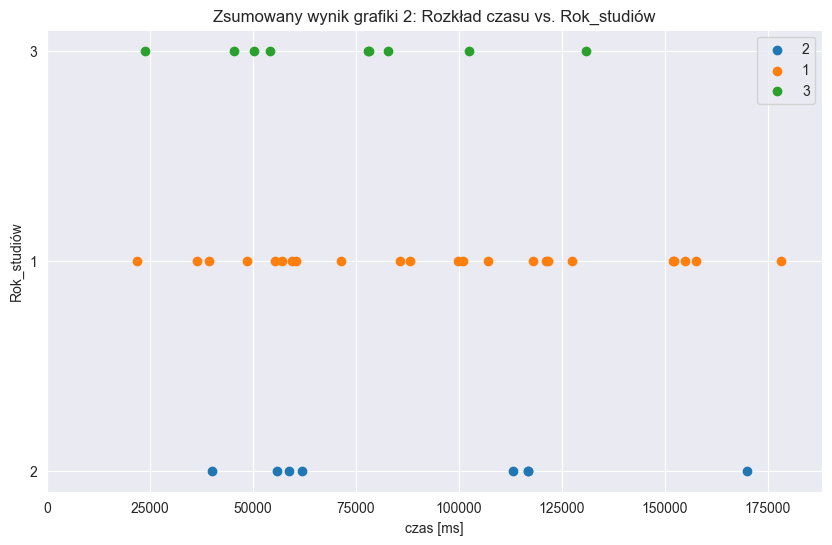

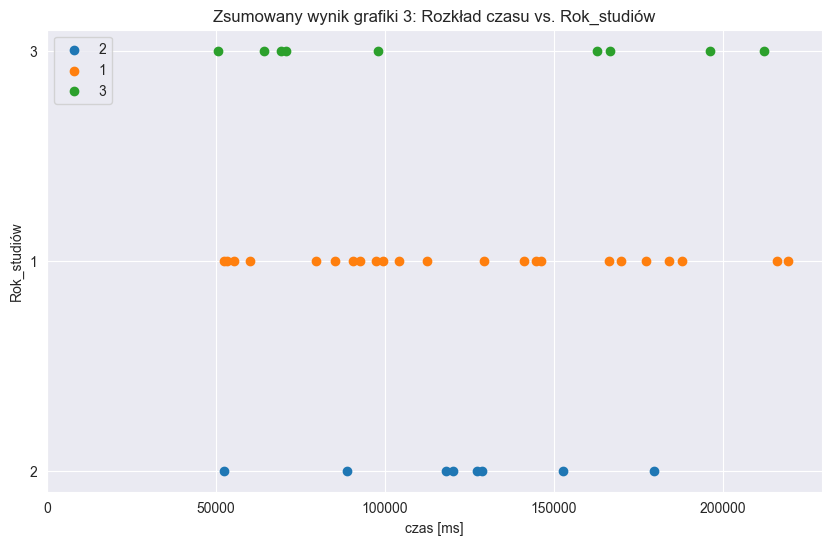

-------- Specjalność ---------


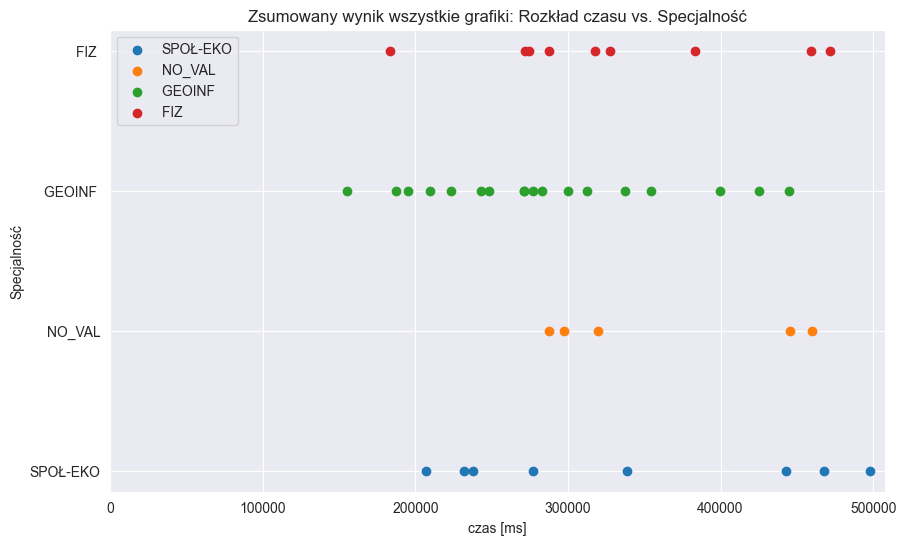

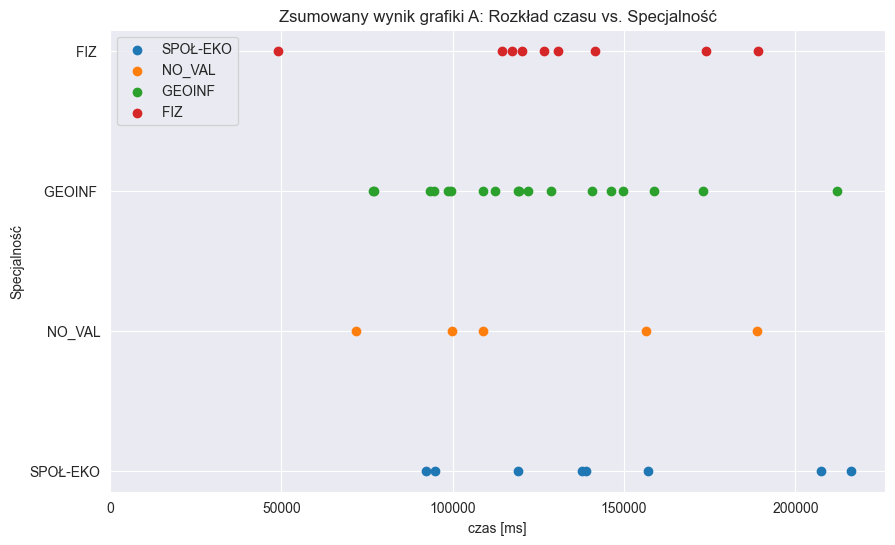

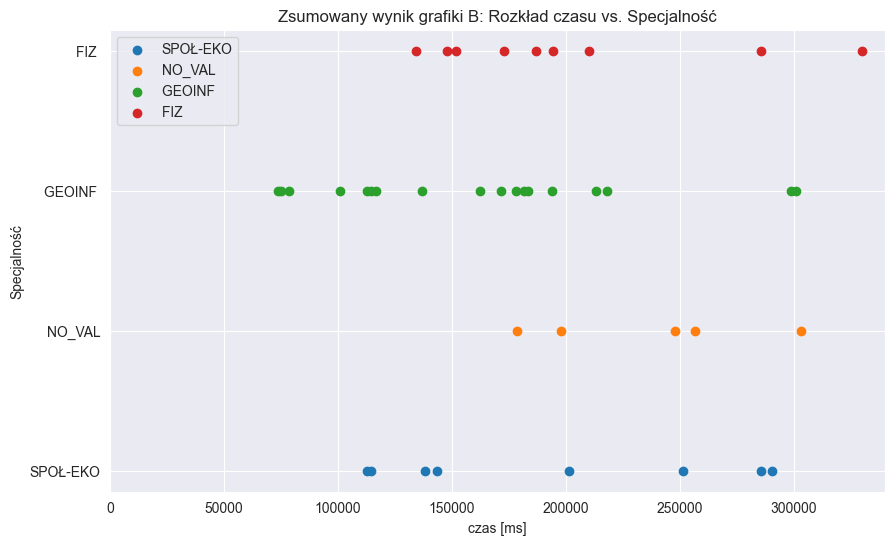

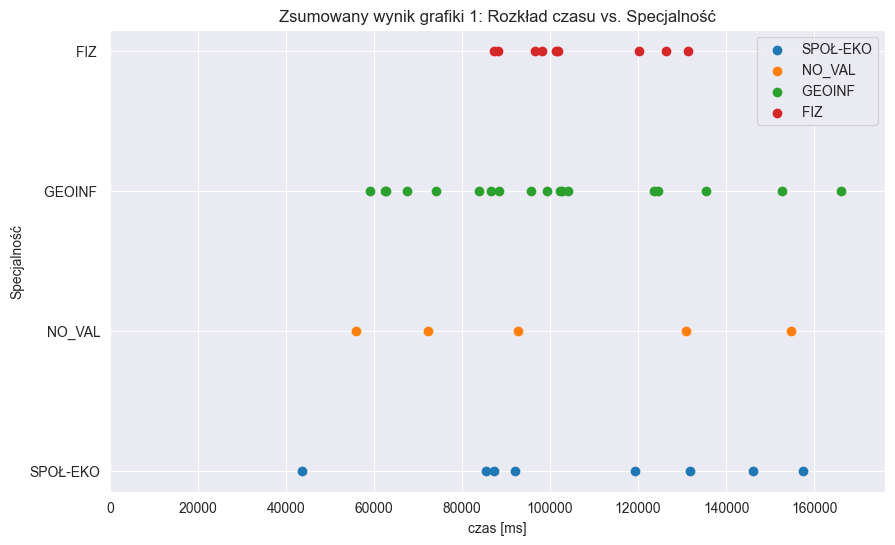

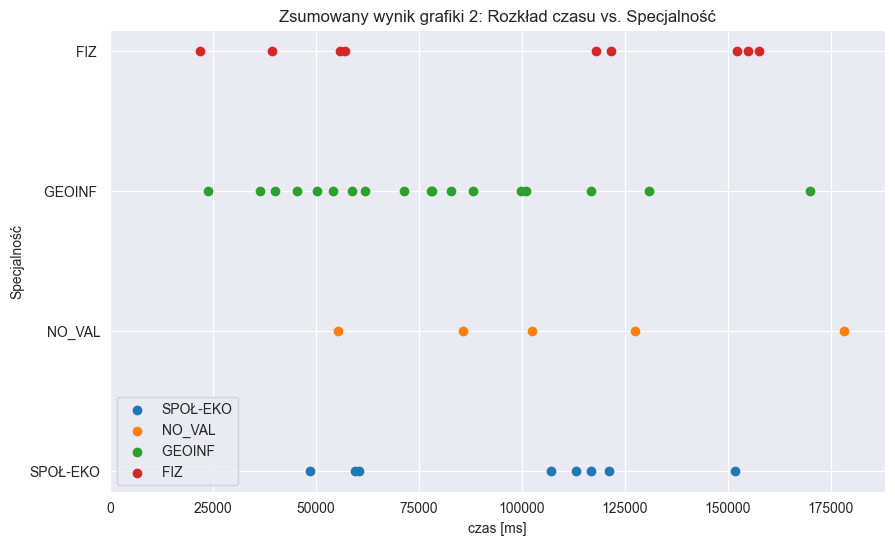

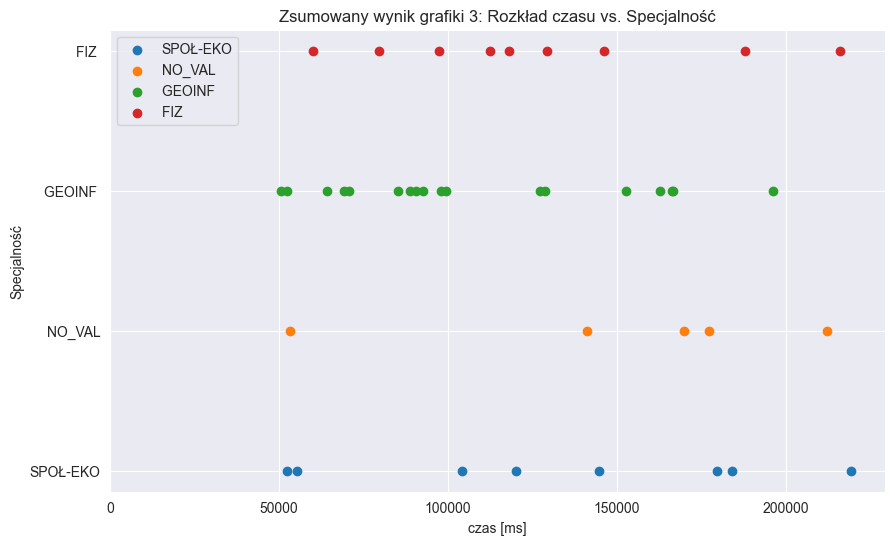

-------- Wady_wzroku ---------


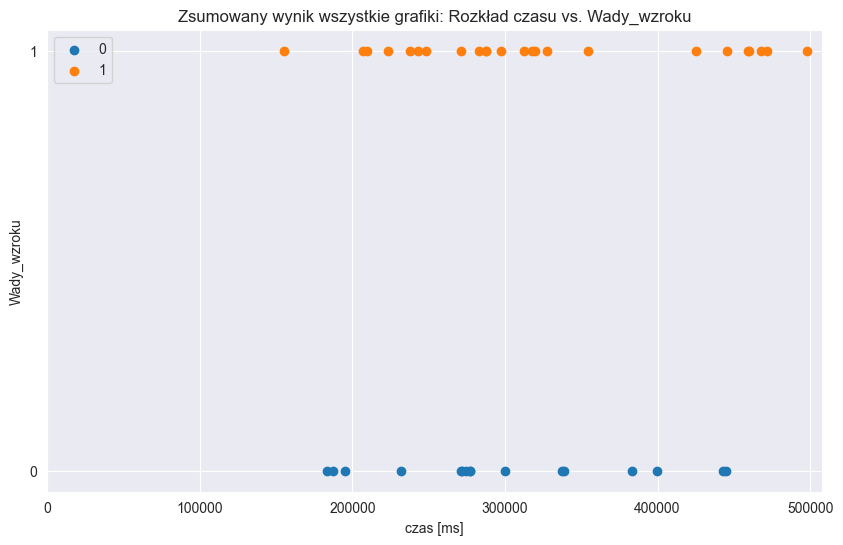

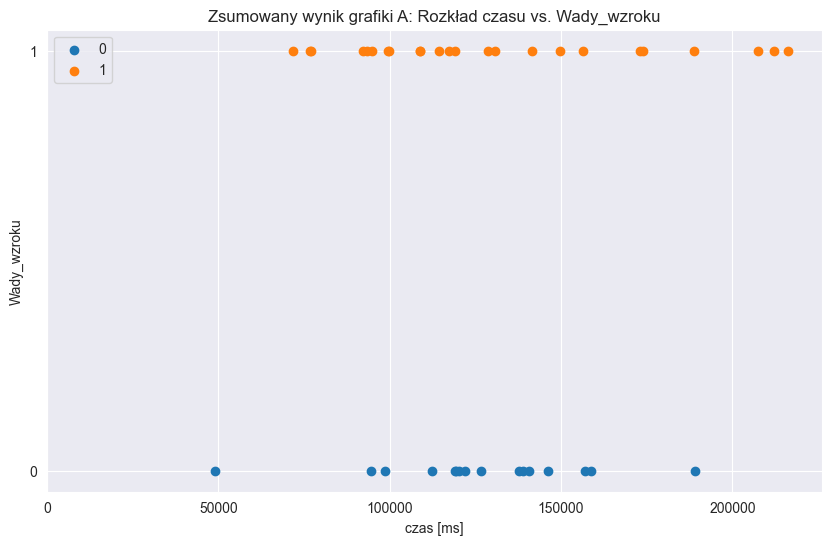

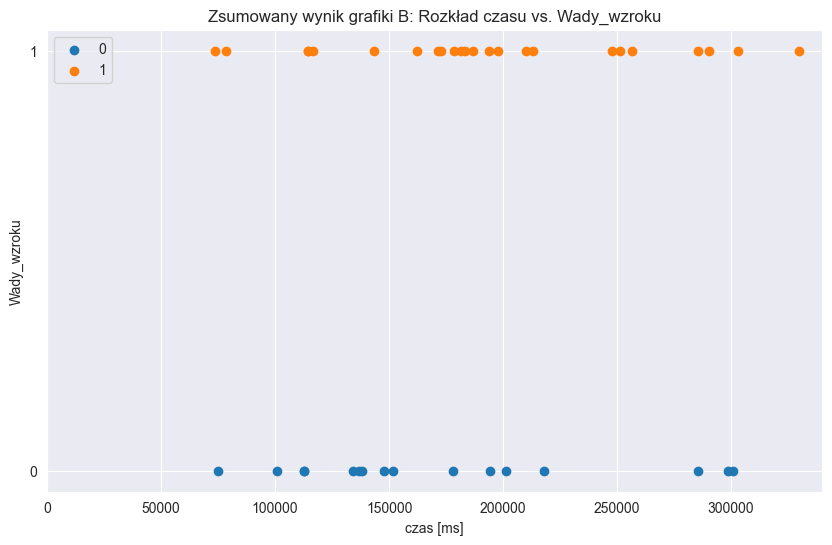

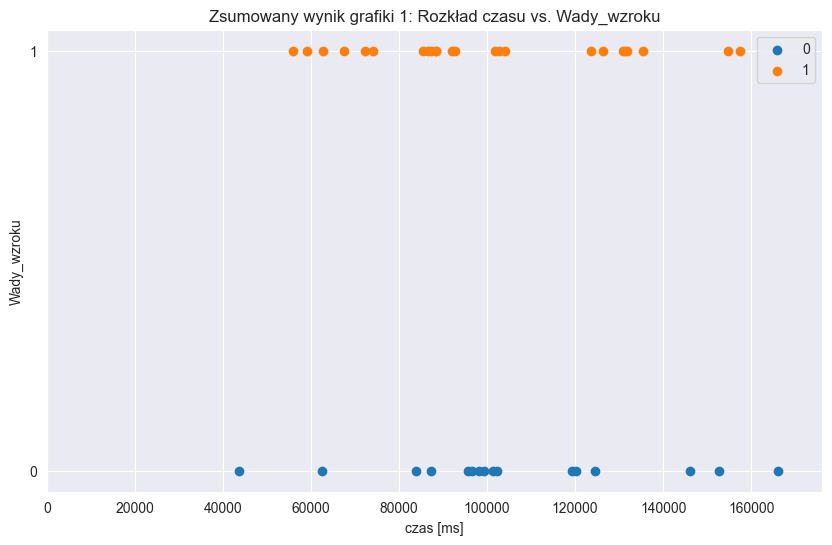

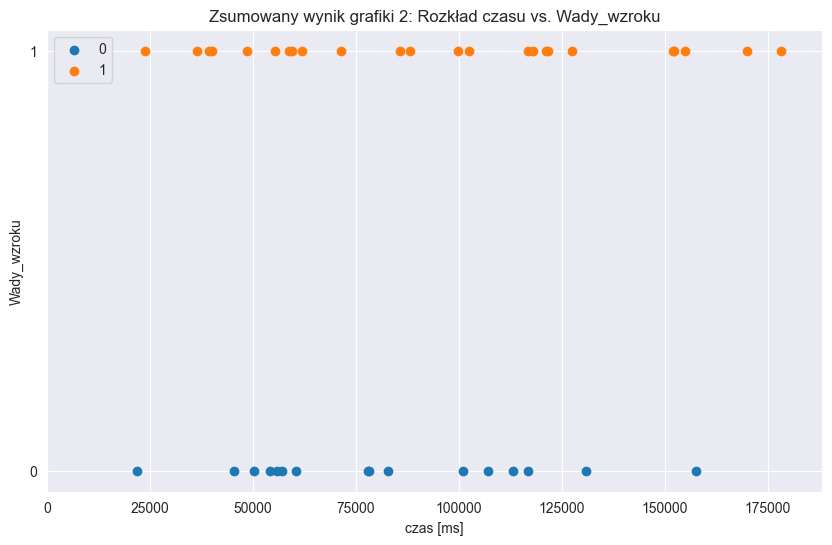

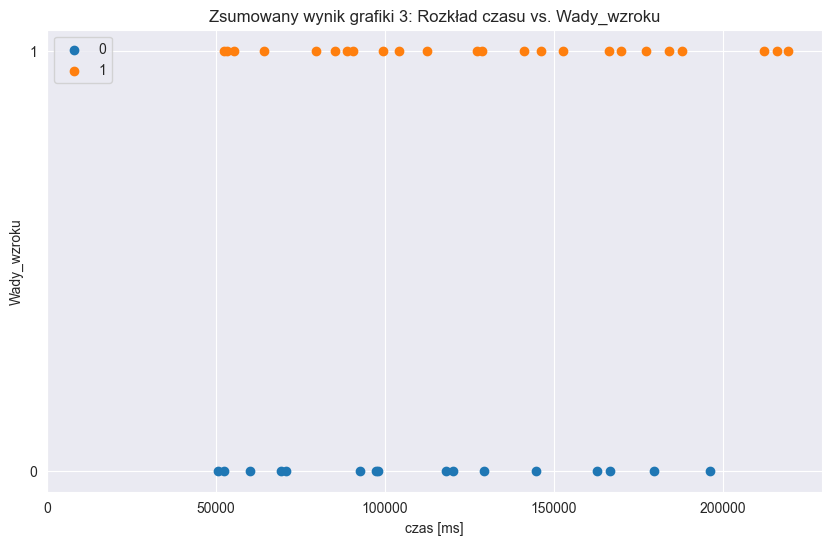

-------- Ilość_snu ---------


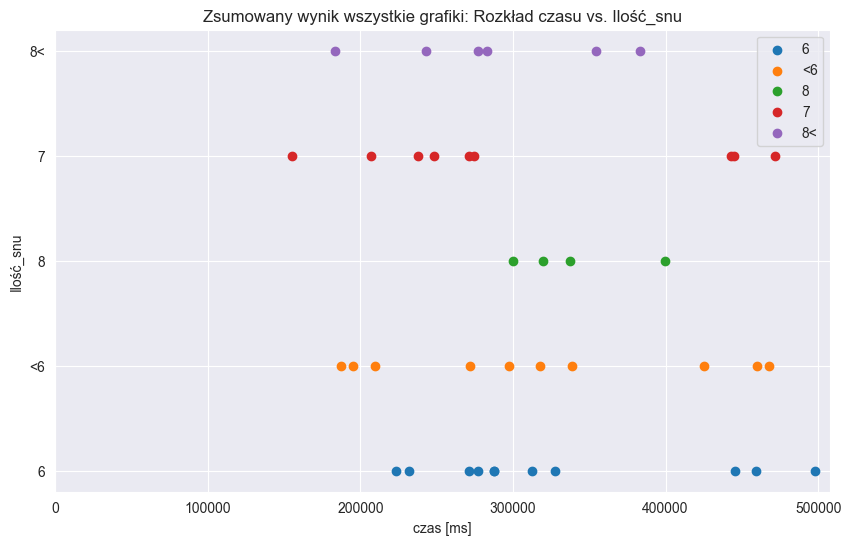

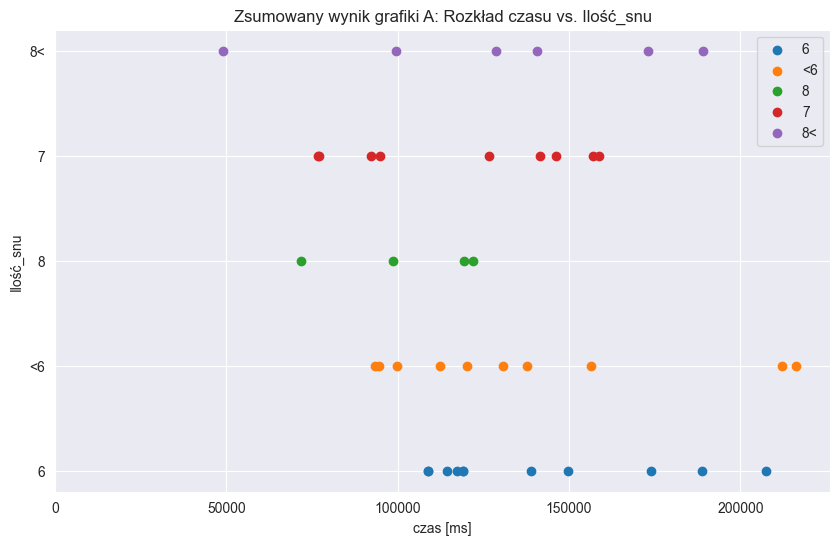

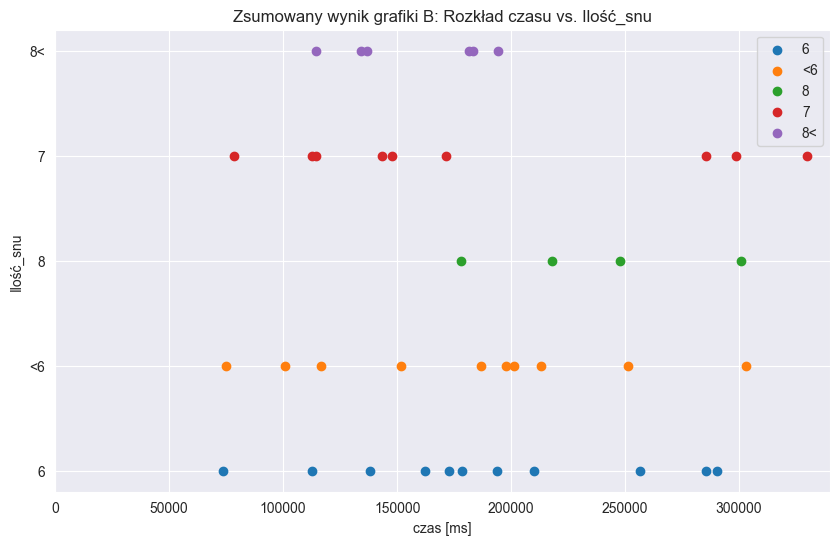

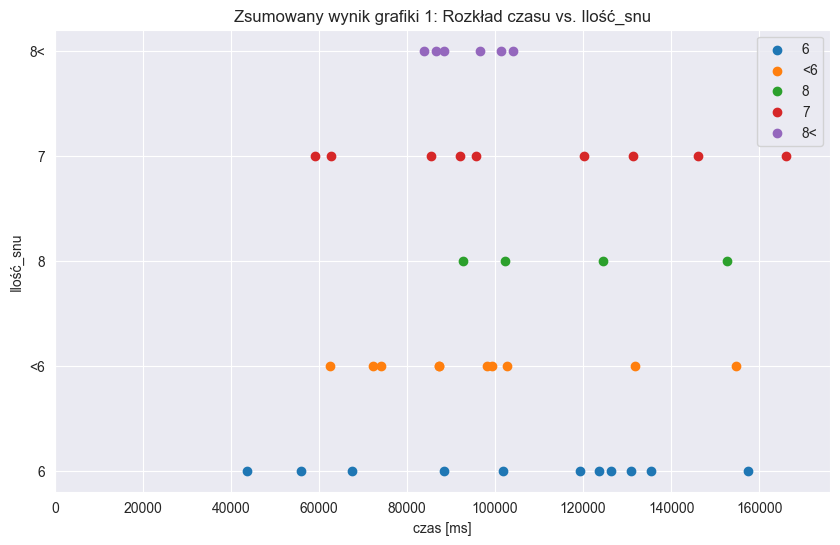

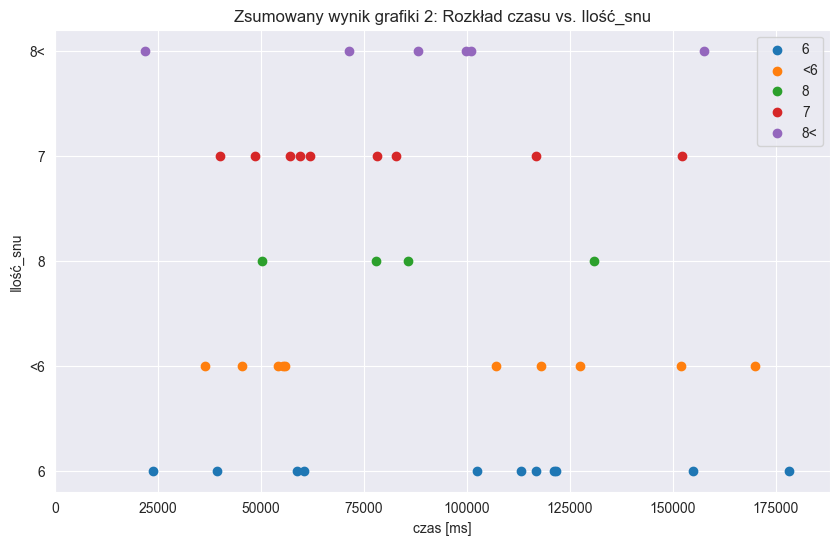

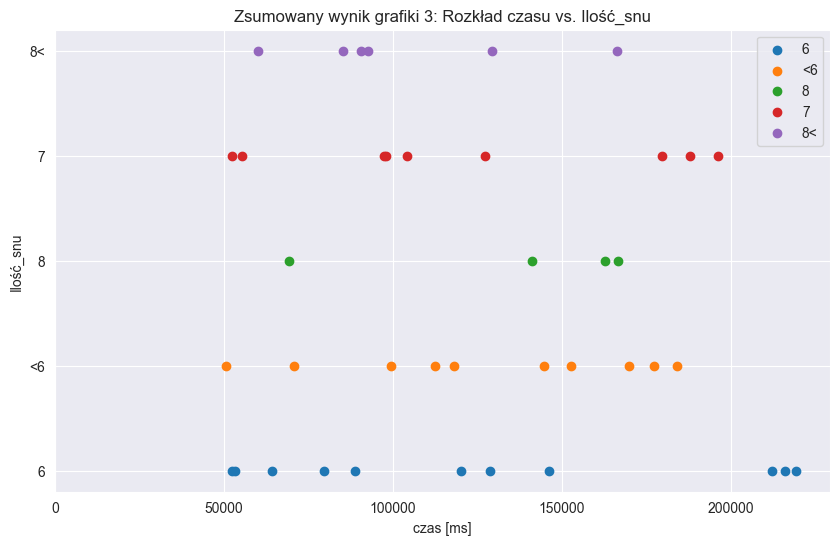

-------- JP_podst ---------


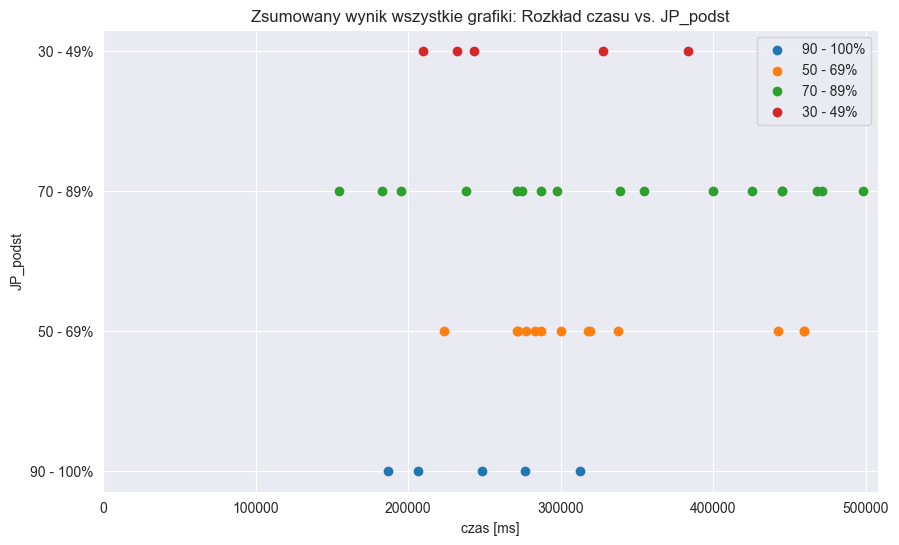

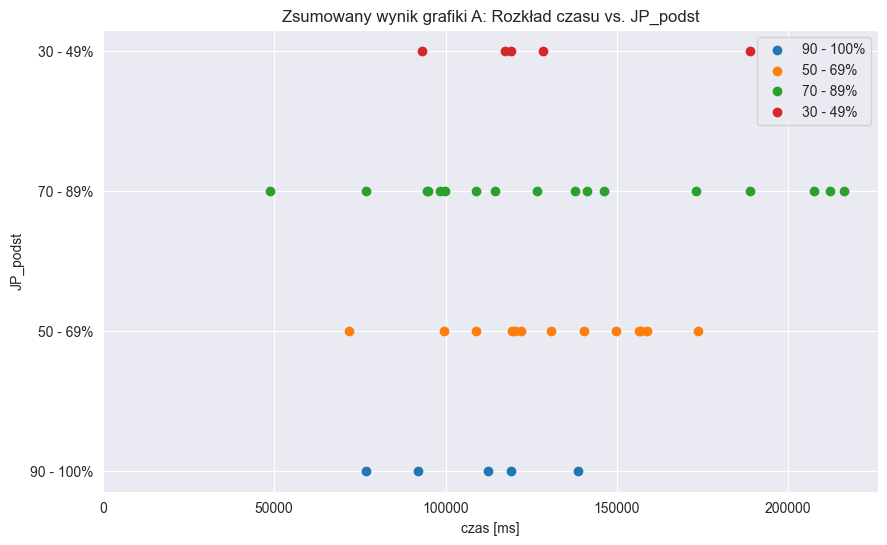

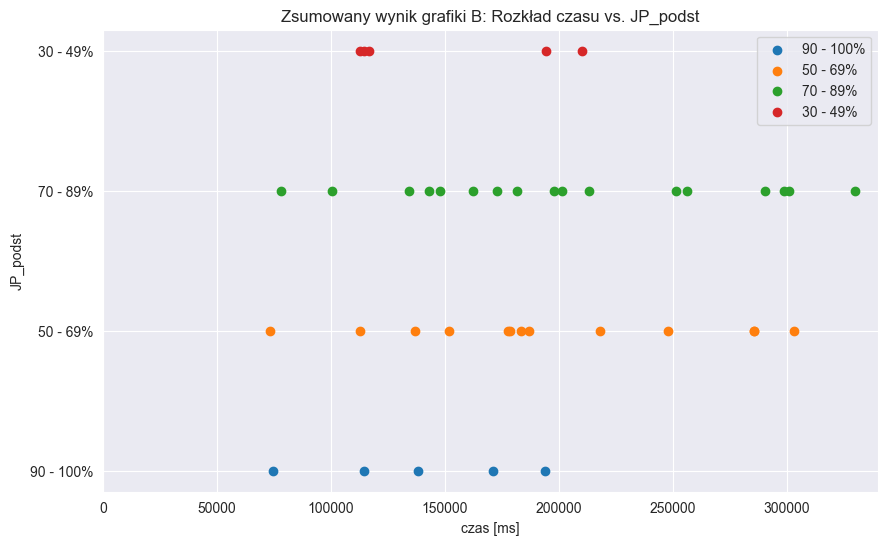

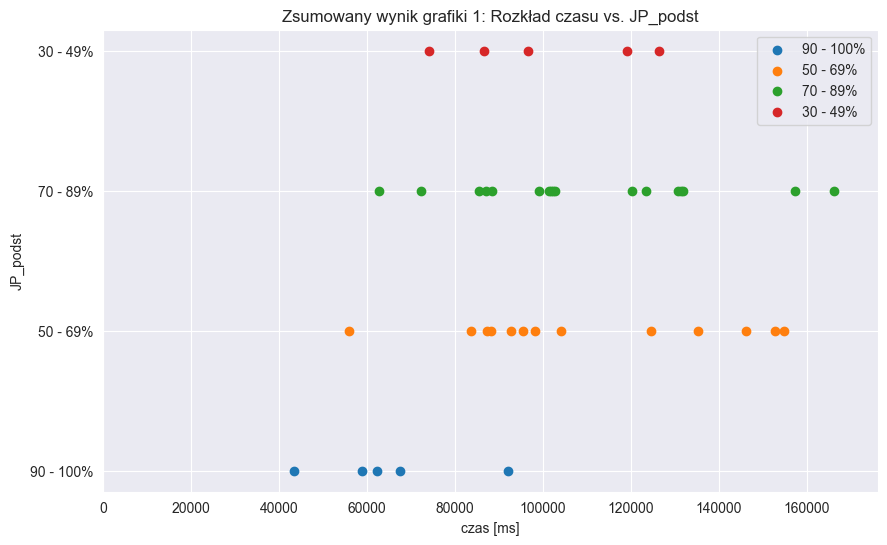

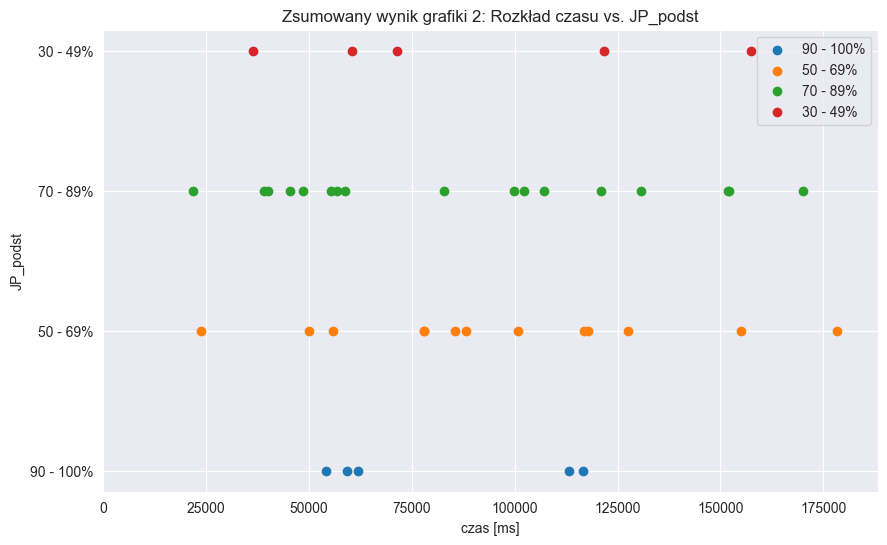

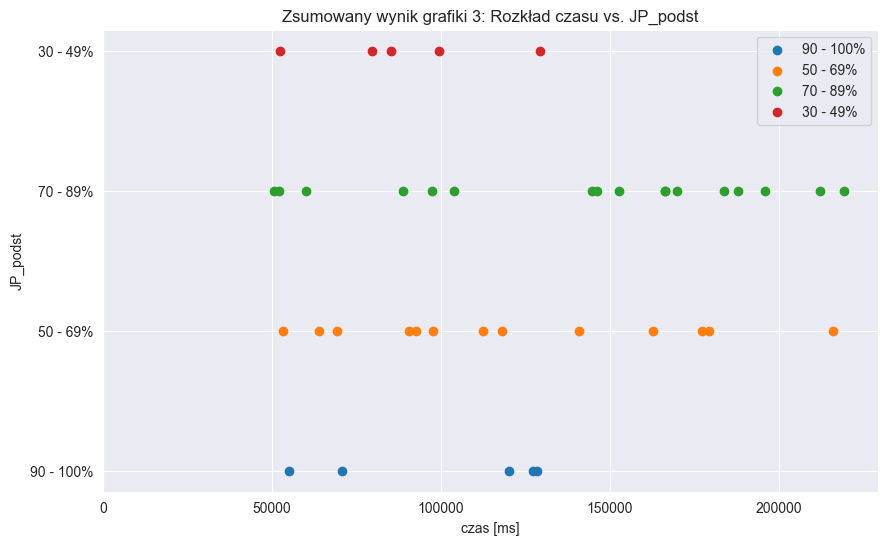

-------- MAT_podst ---------


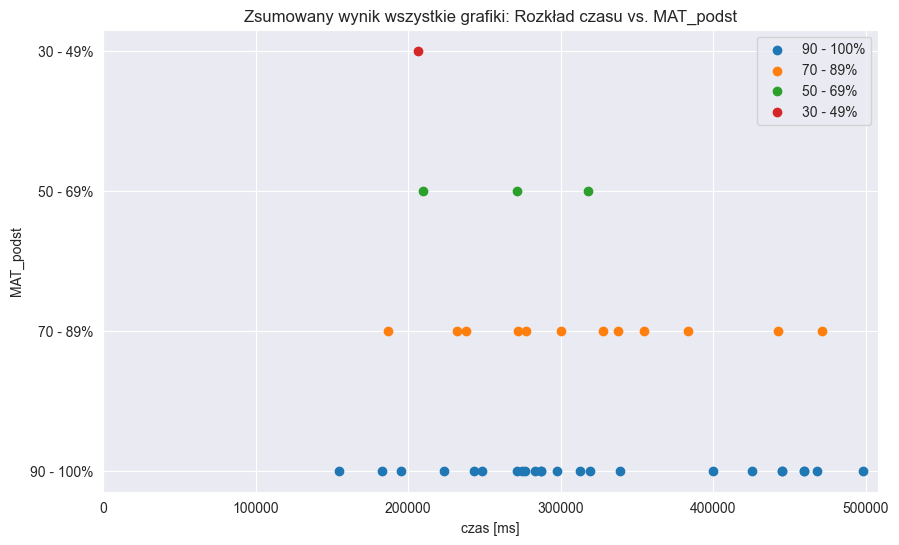

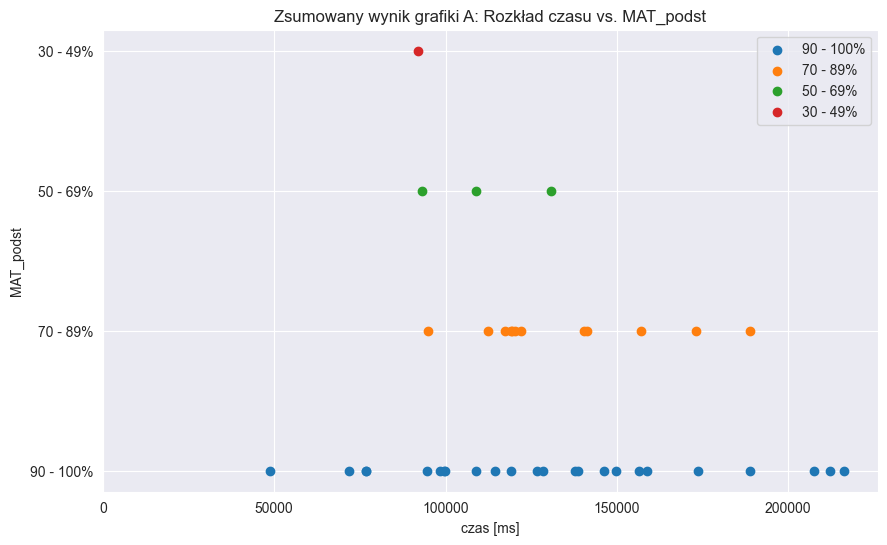

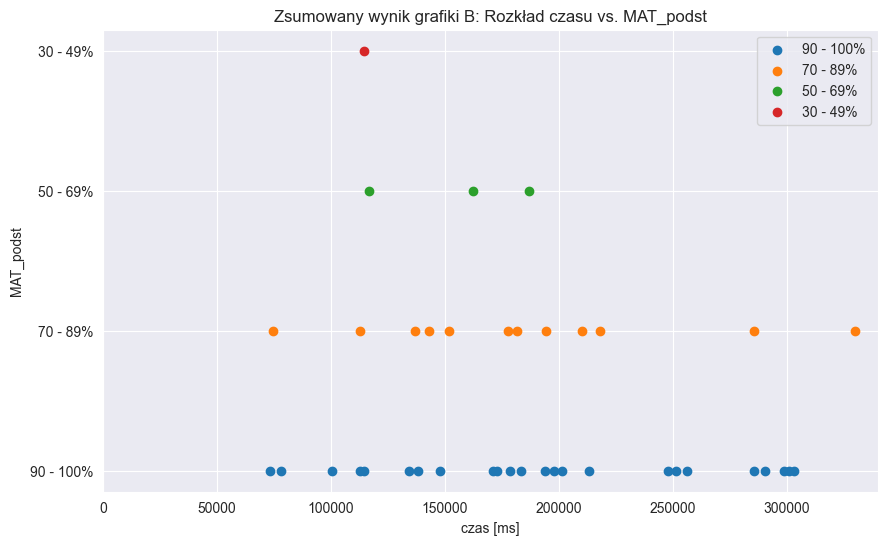

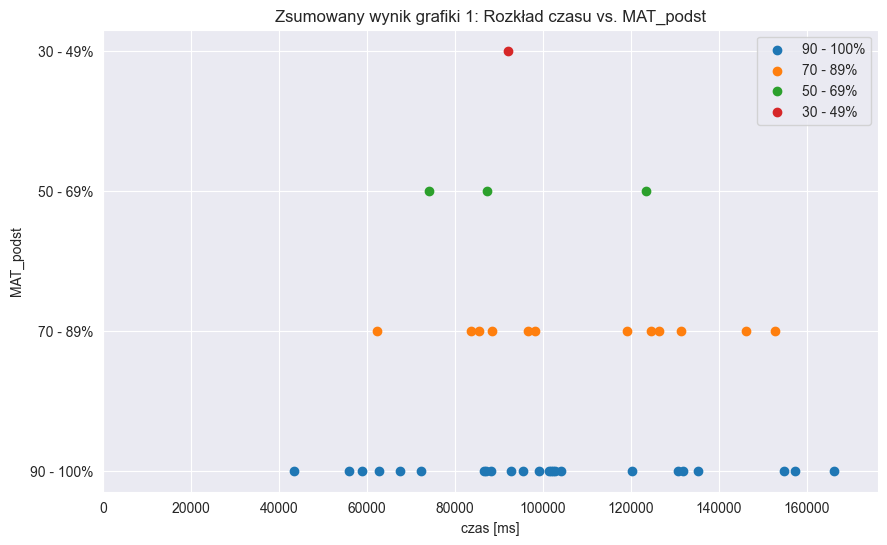

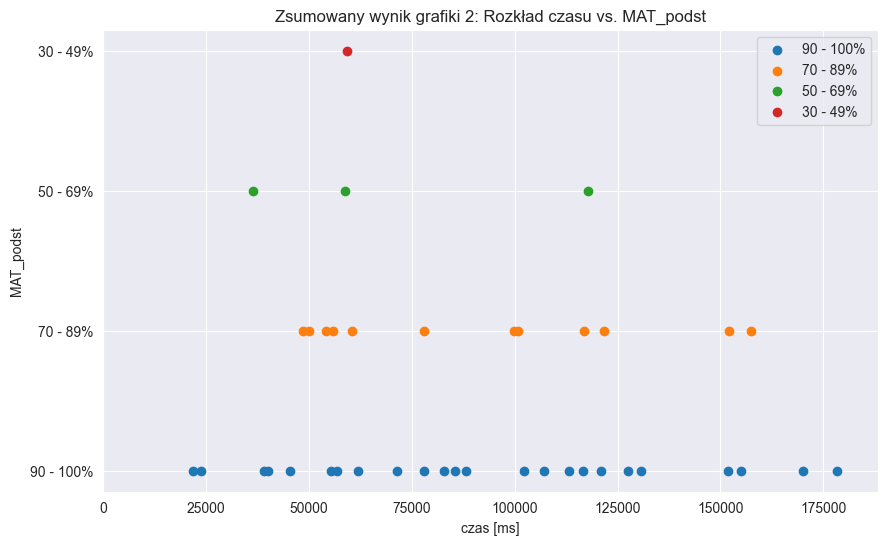

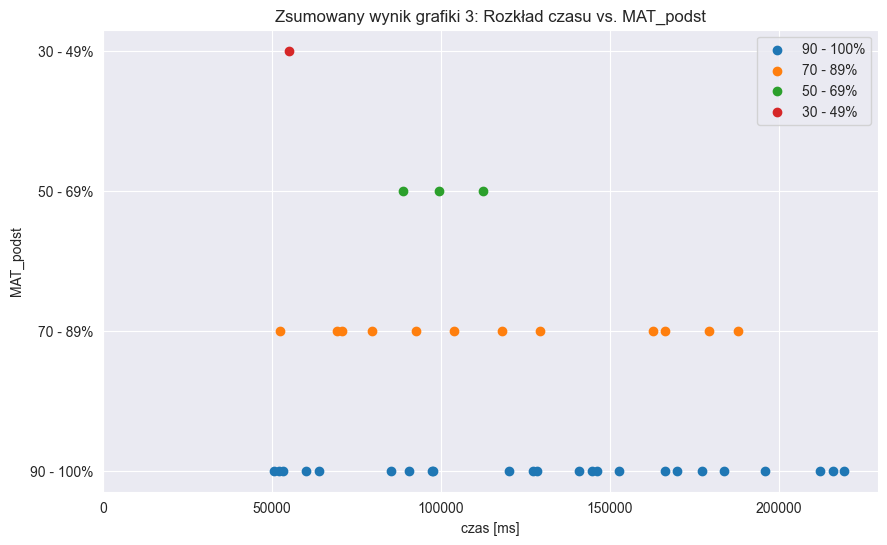

-------- JP_roz ---------


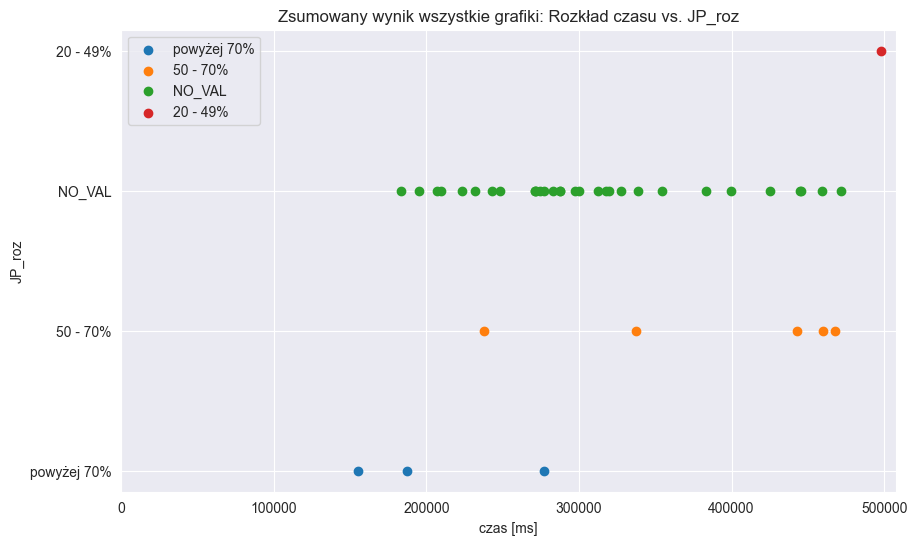

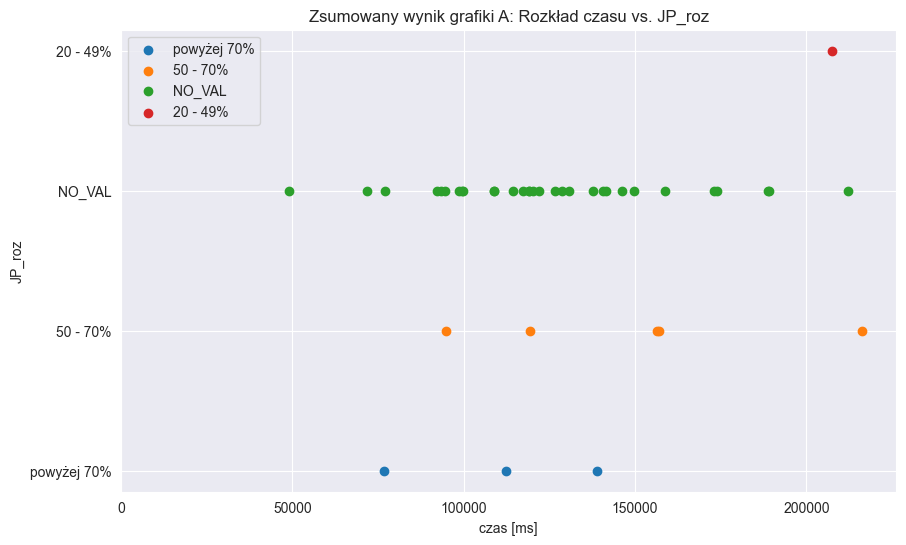

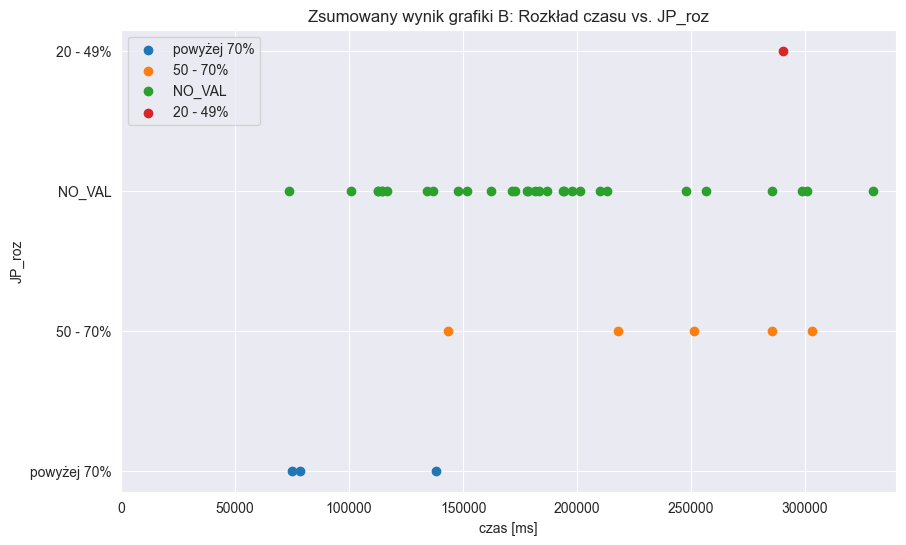

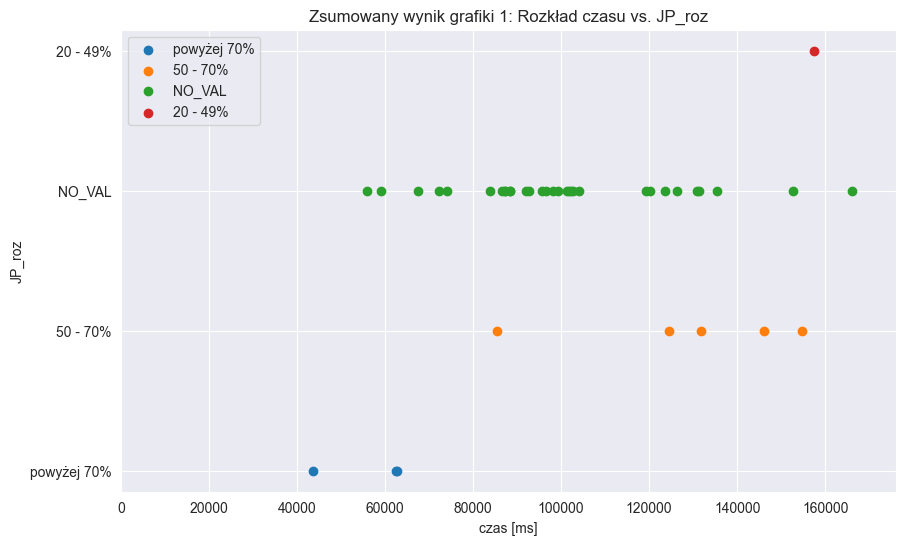

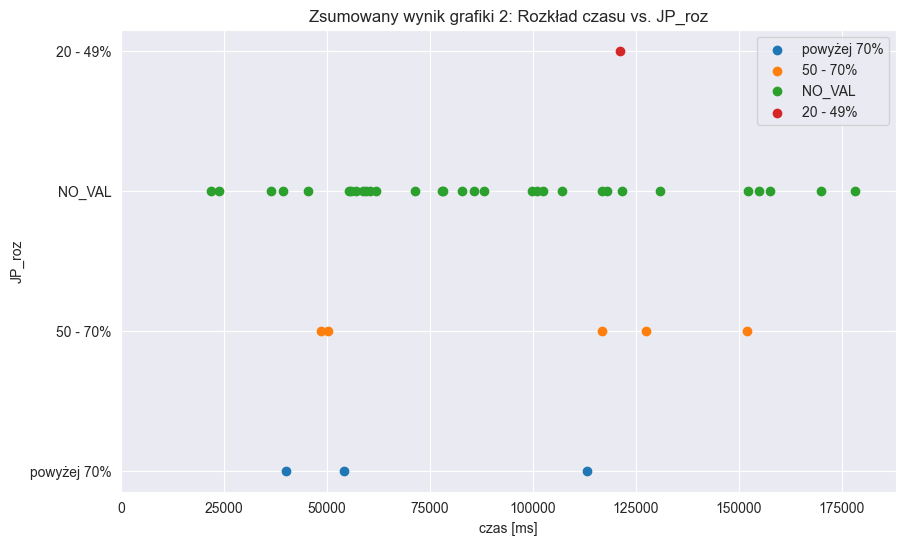

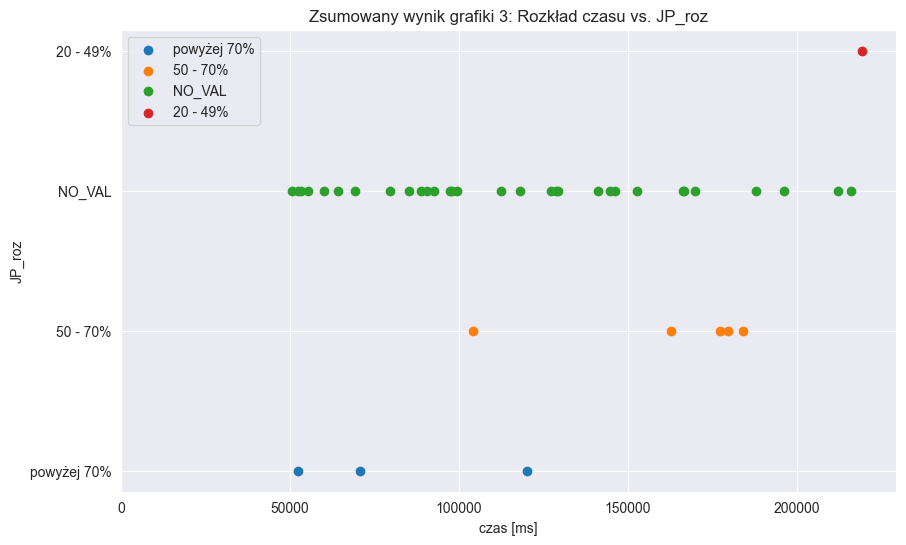

-------- MAT_roz ---------


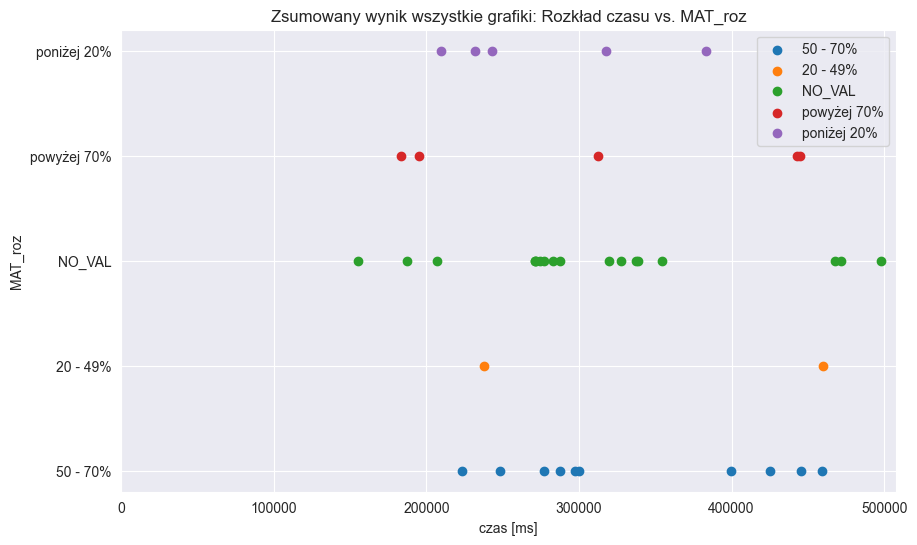

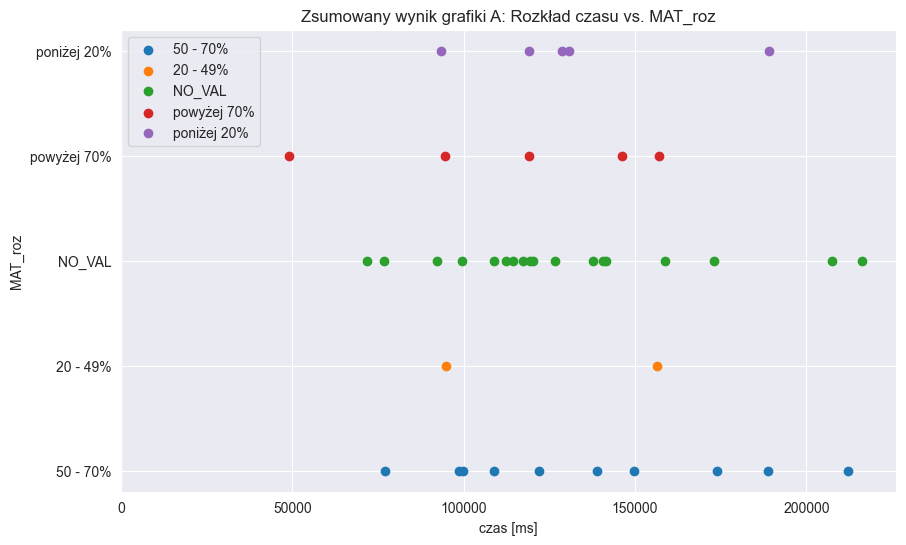

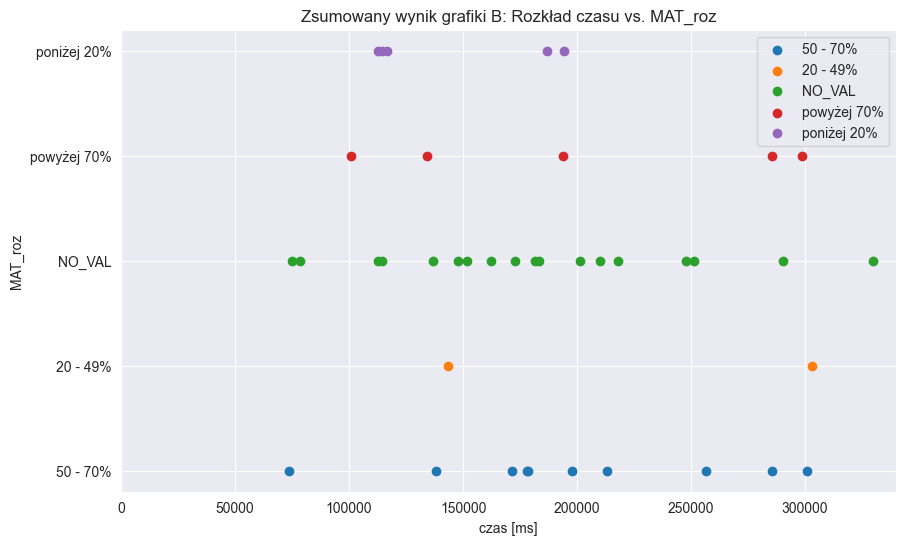

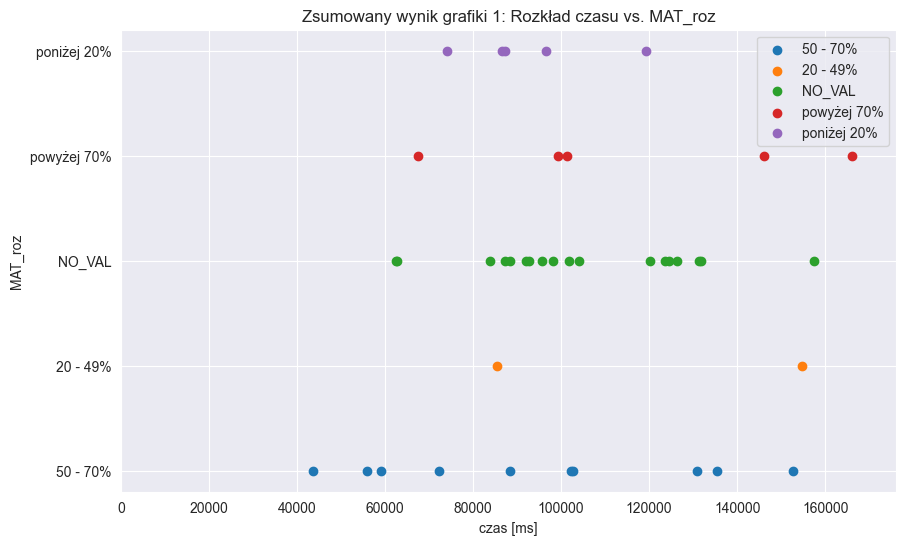

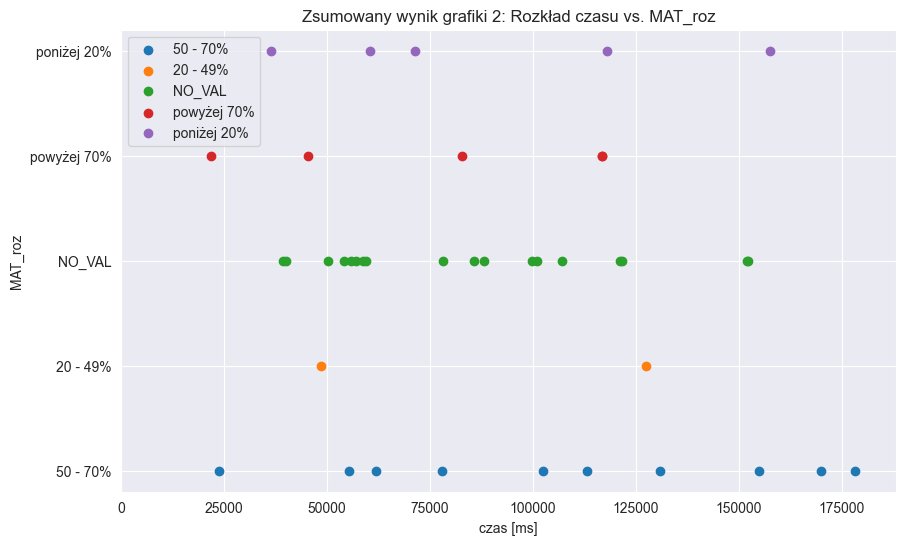

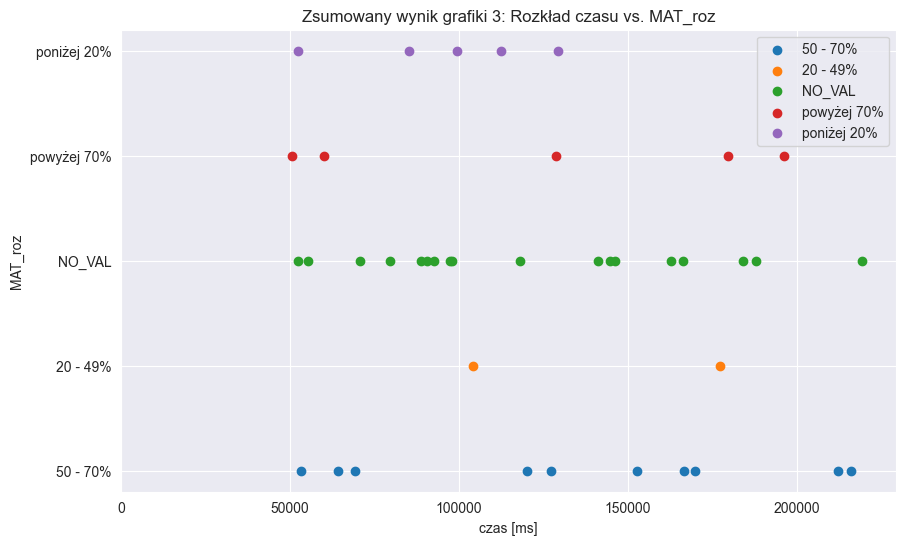

-------- HIST_roz ---------


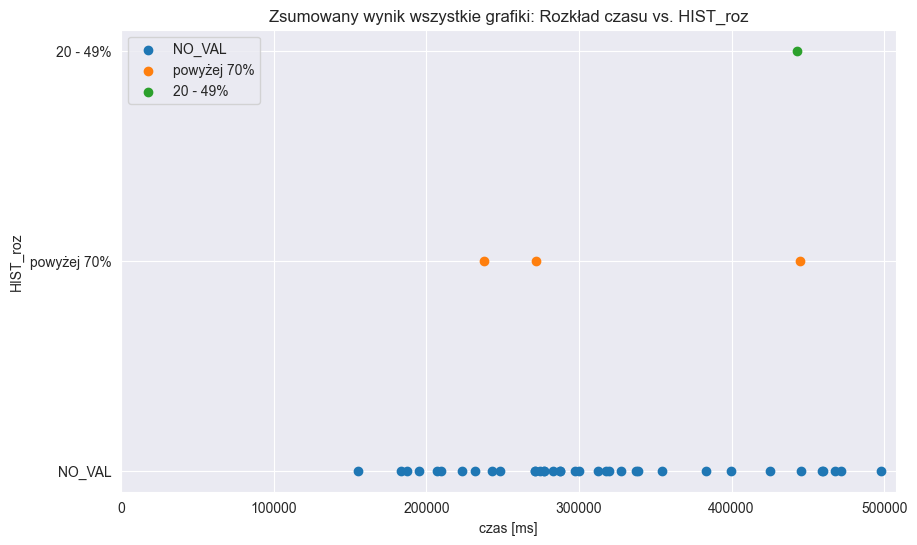

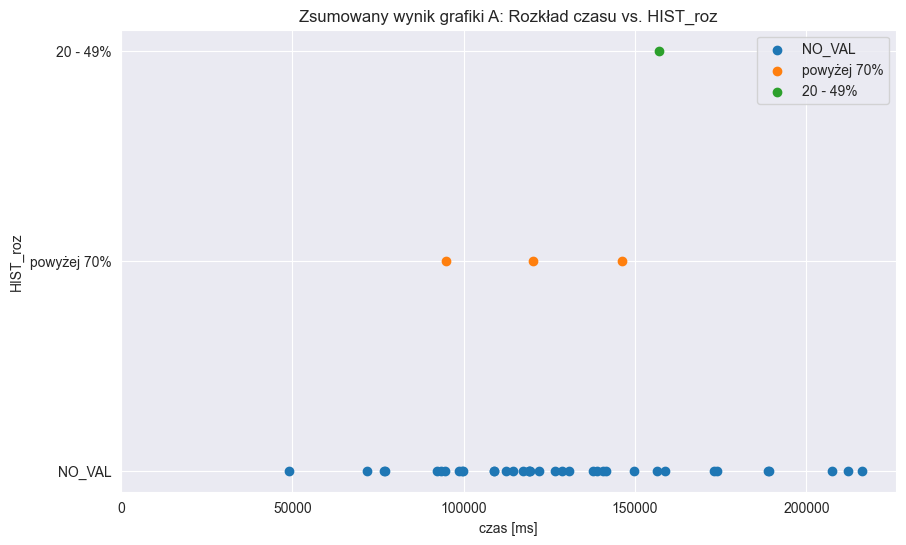

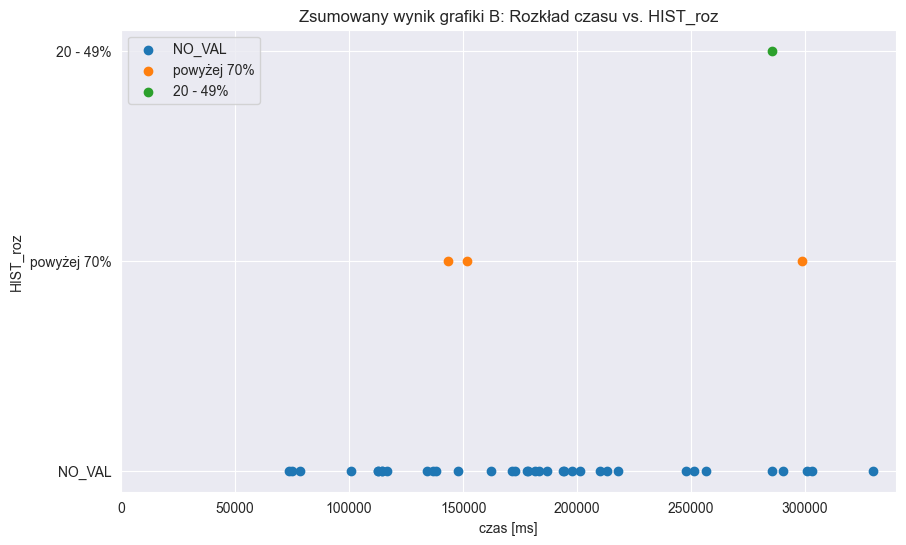

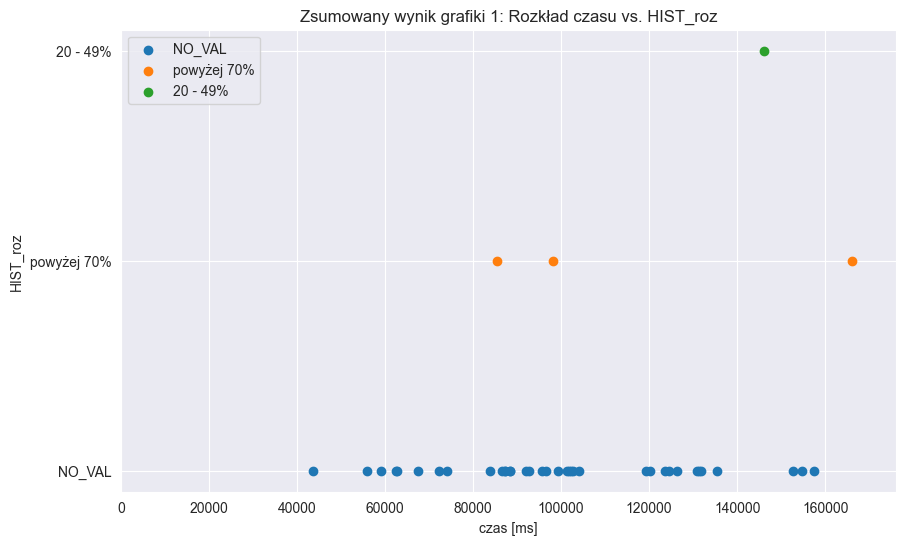

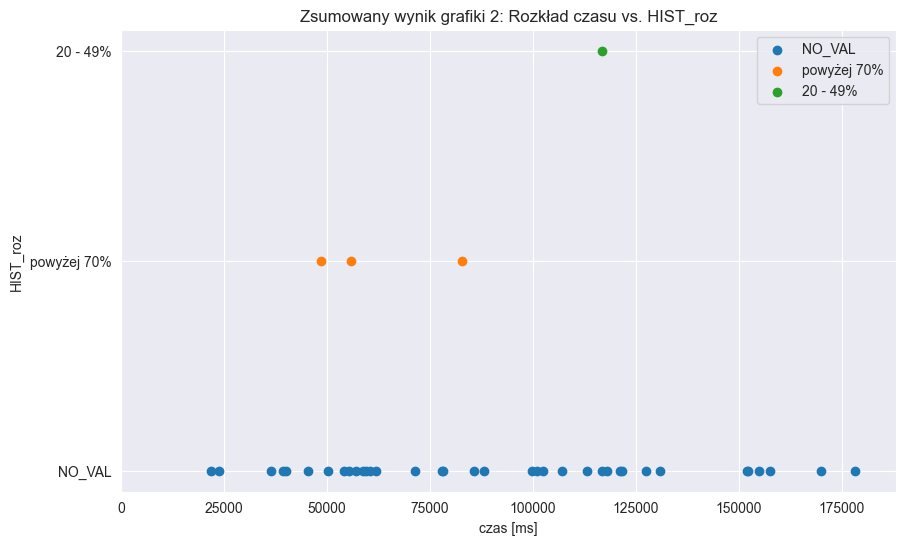

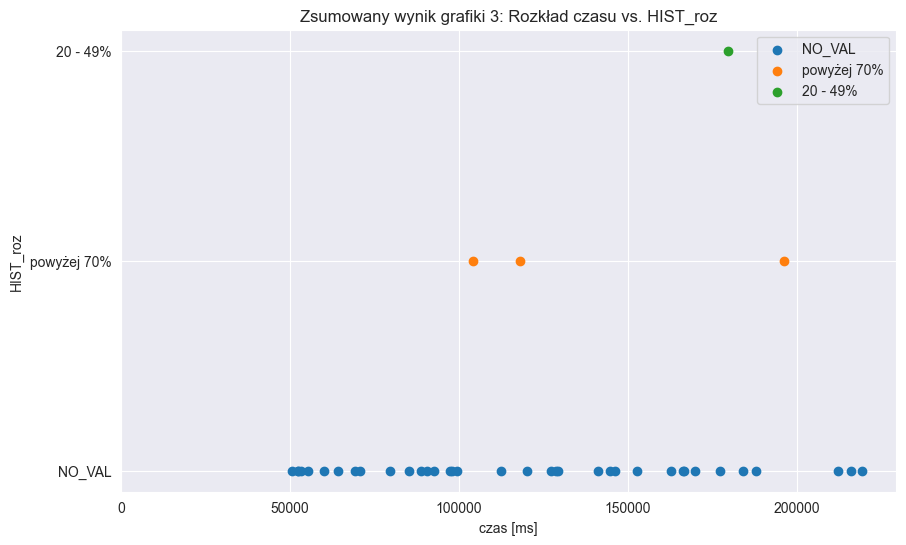

-------- Samopocz ---------


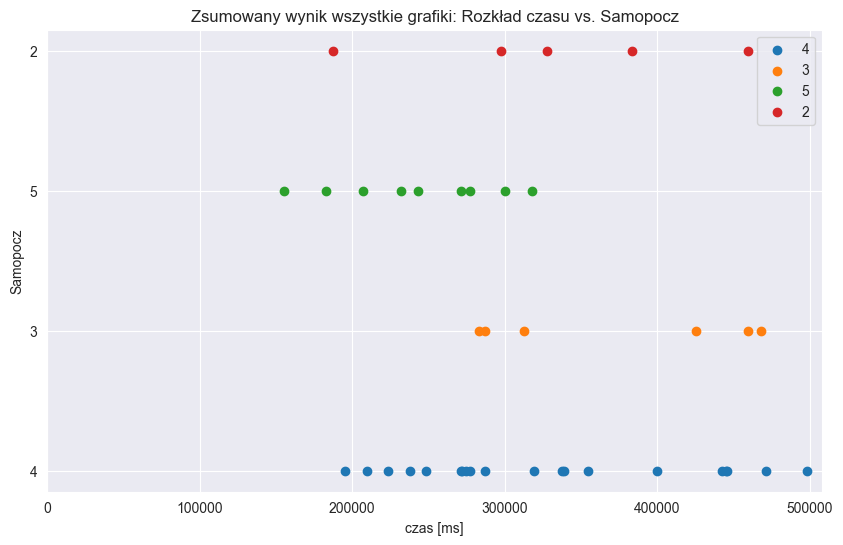

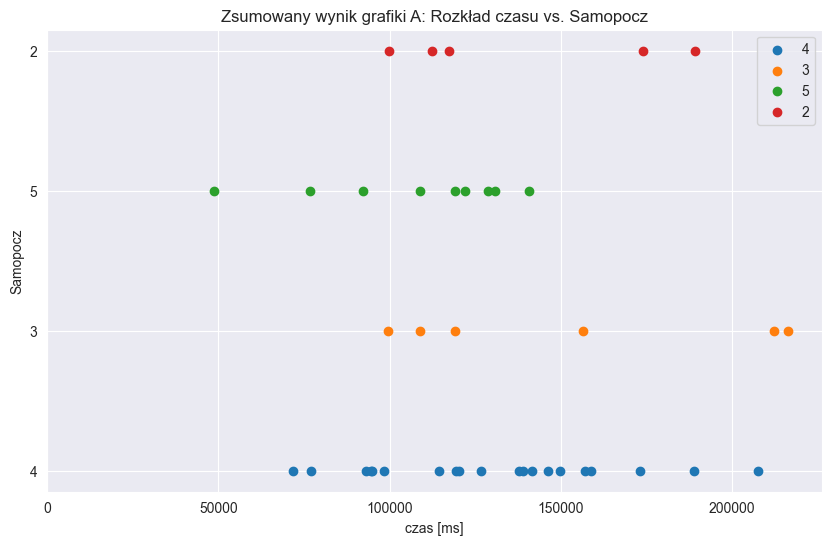

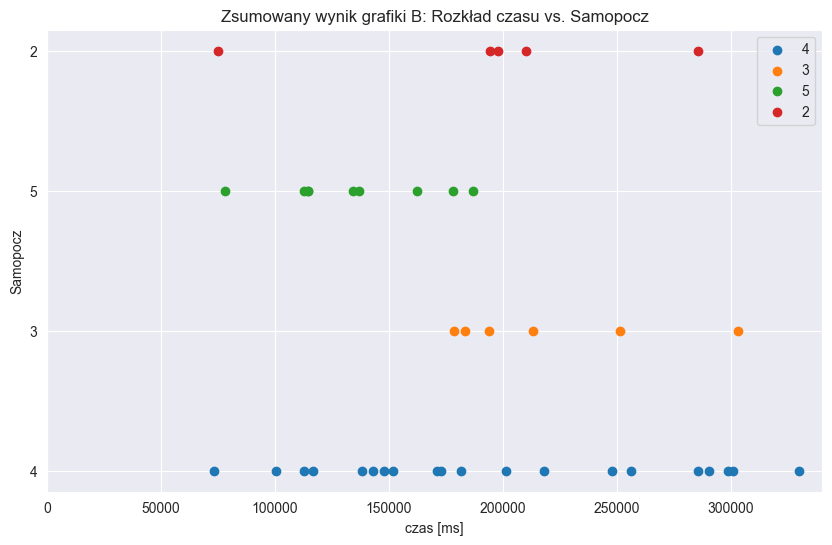

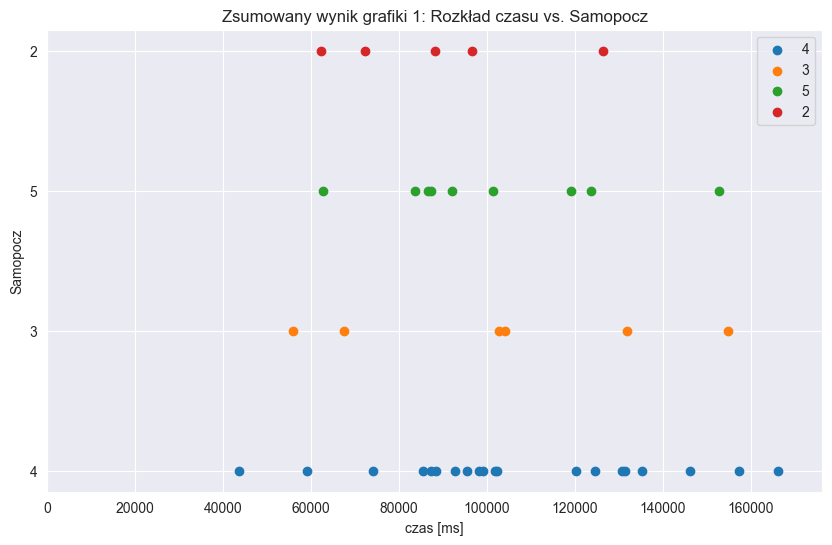

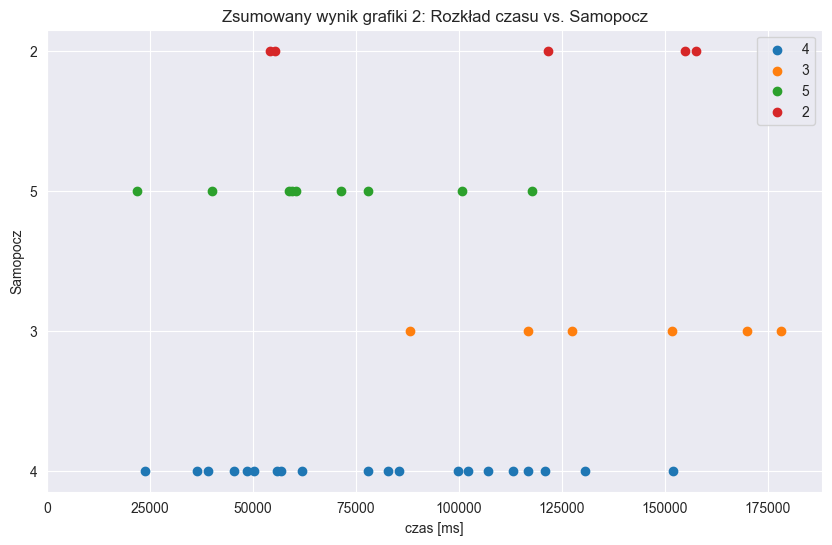

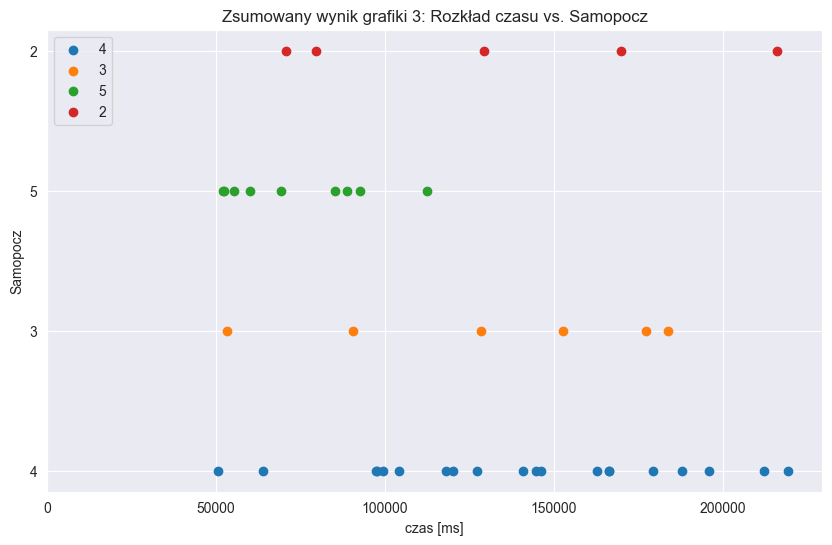

-------- Stres ---------


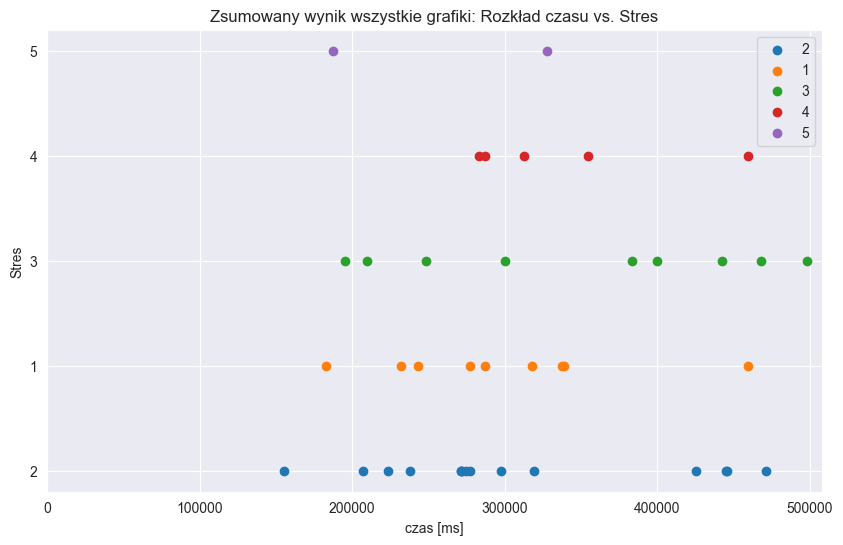

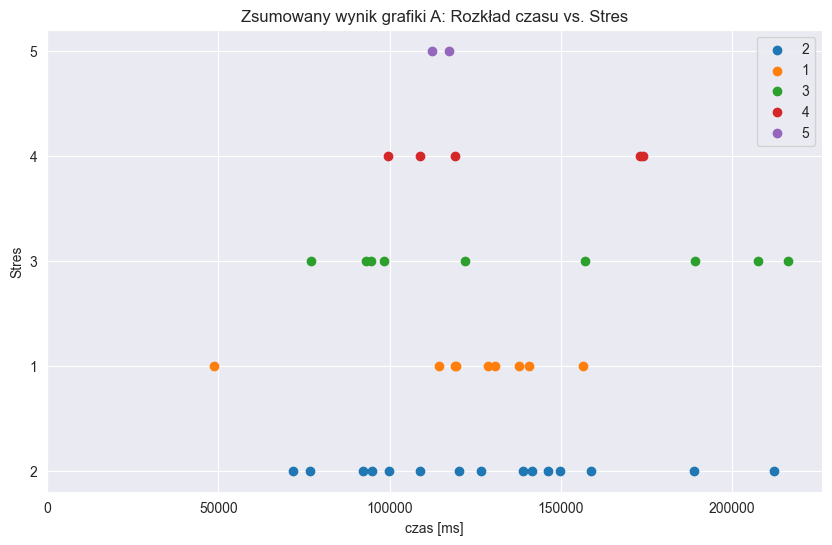

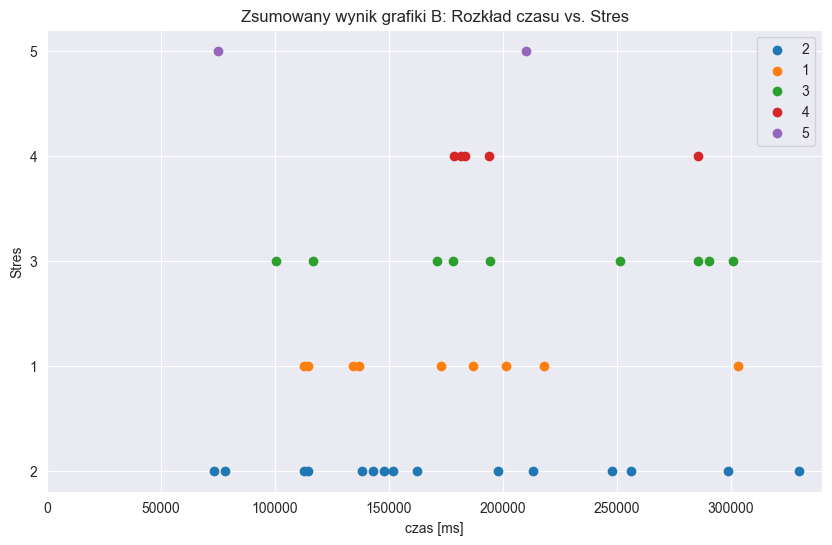

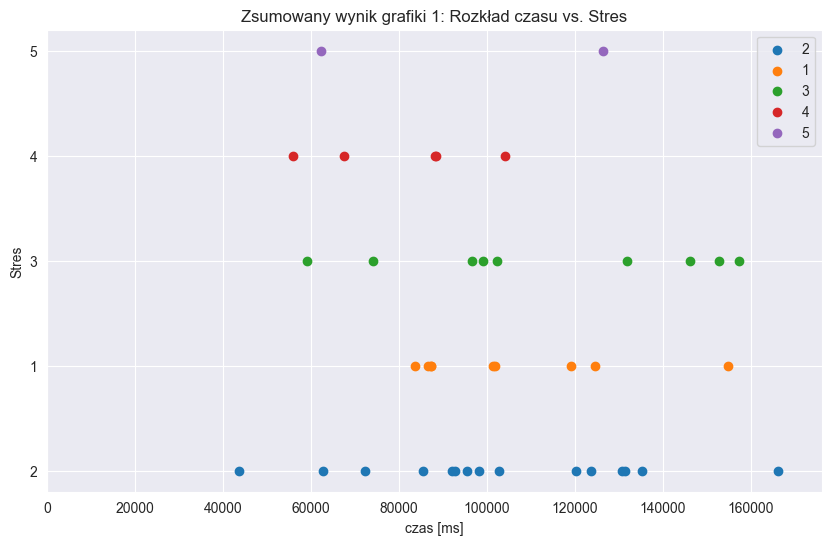

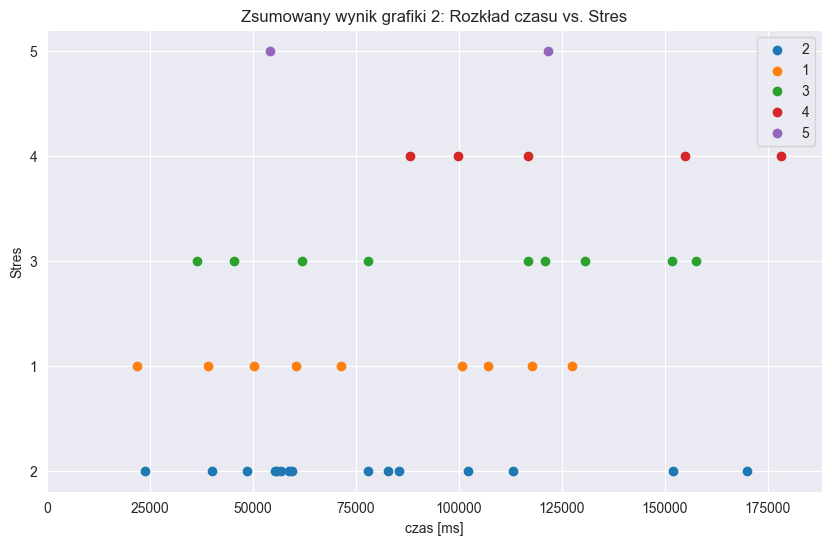

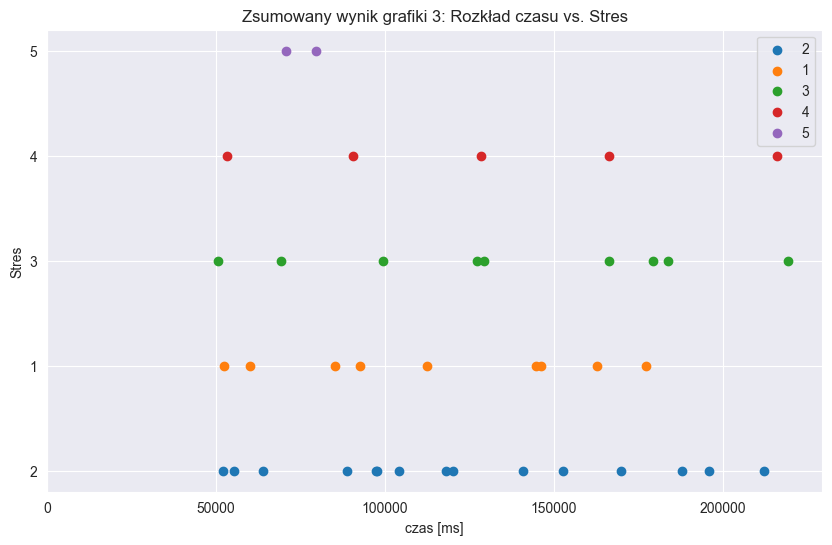

-------- Zmęcz ---------


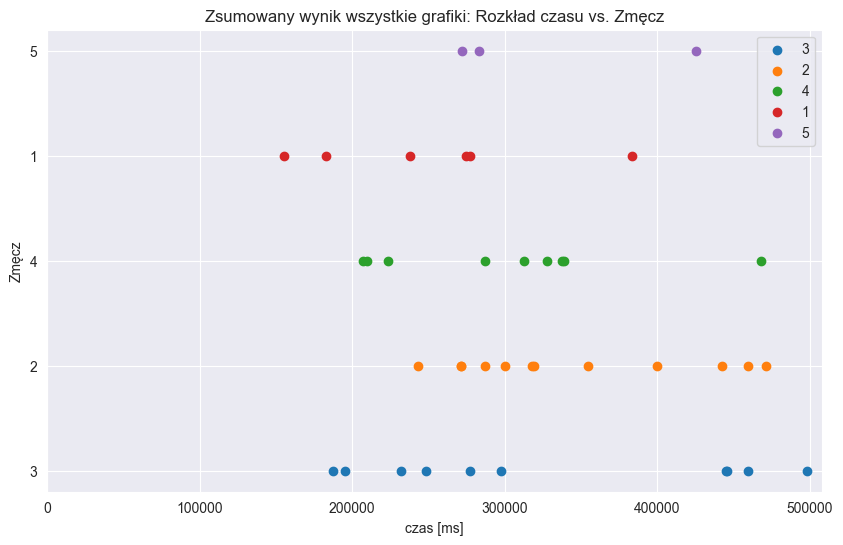

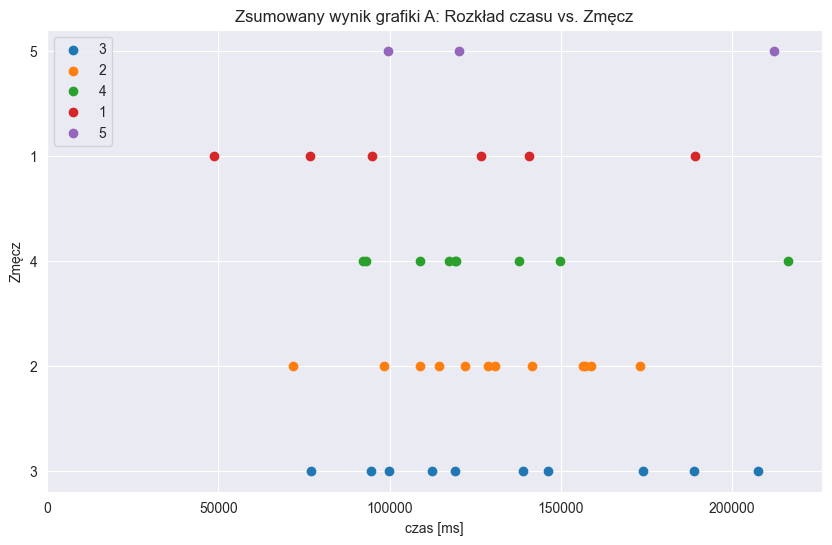

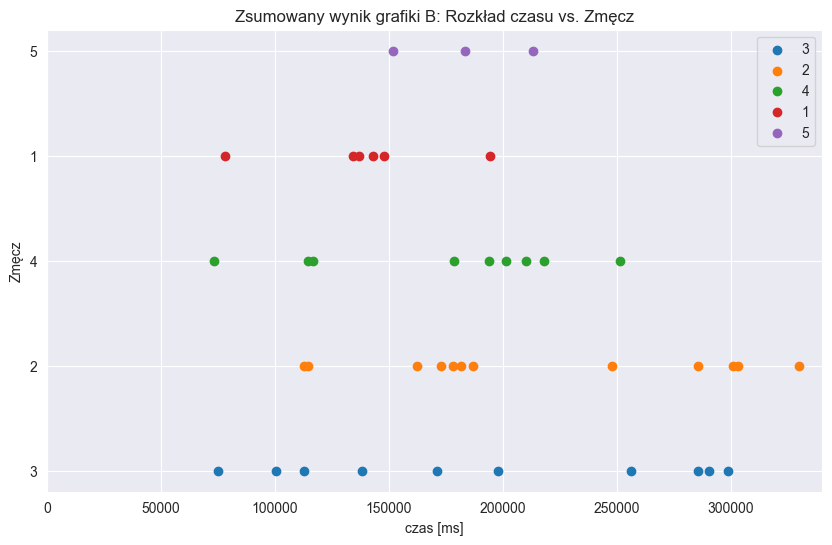

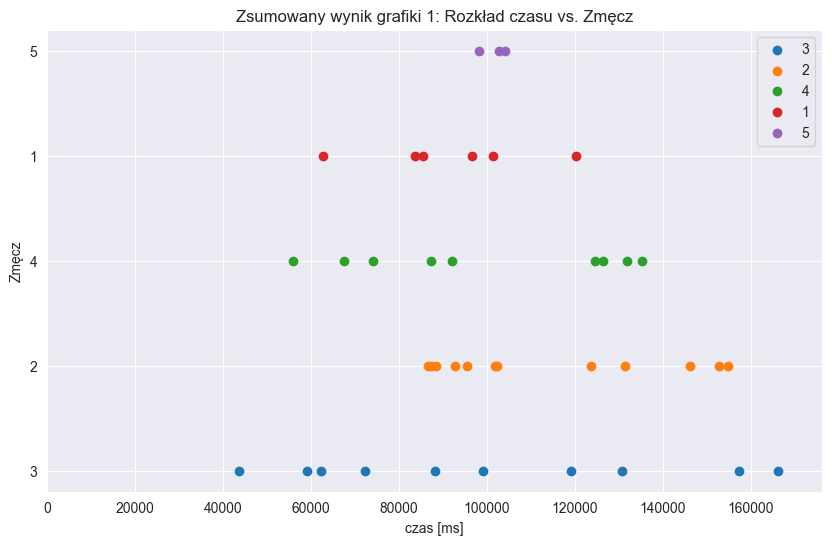

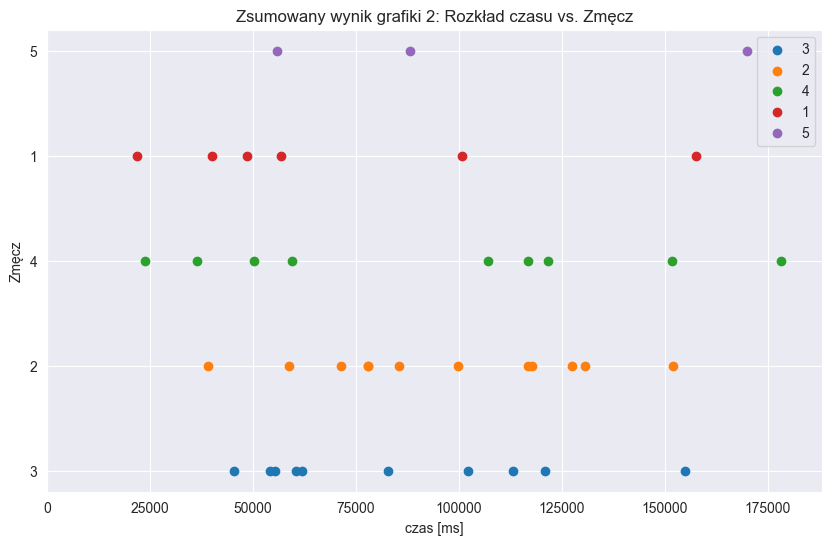

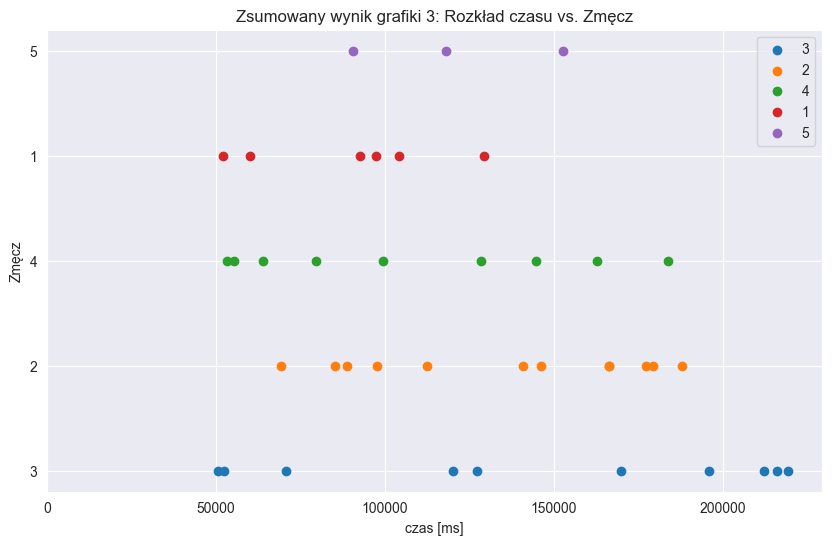

-------- Czyt_map ---------


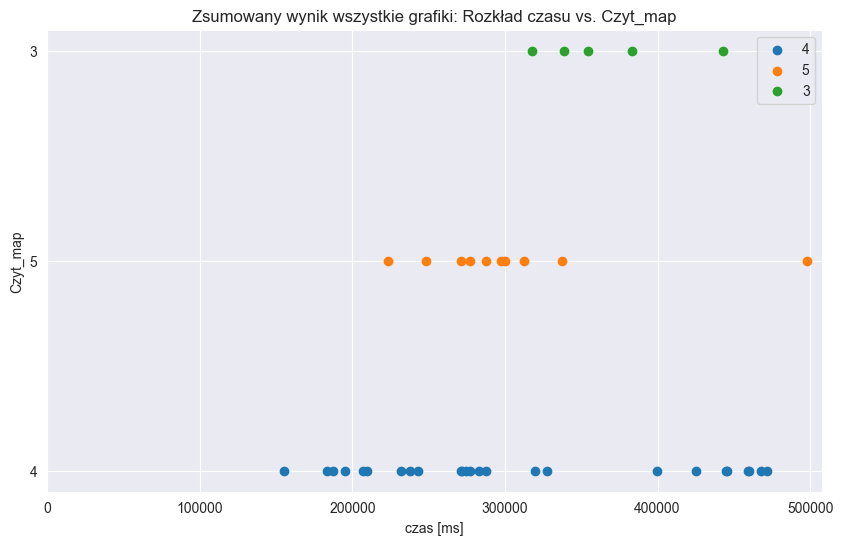

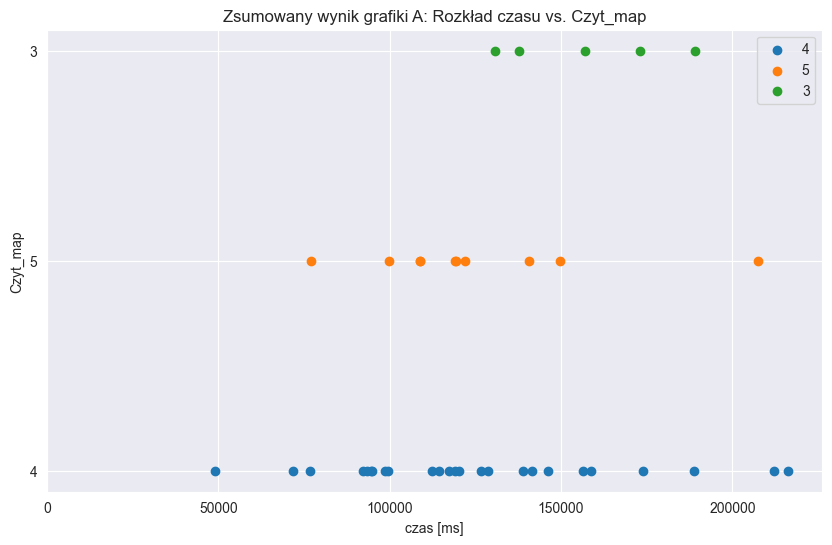

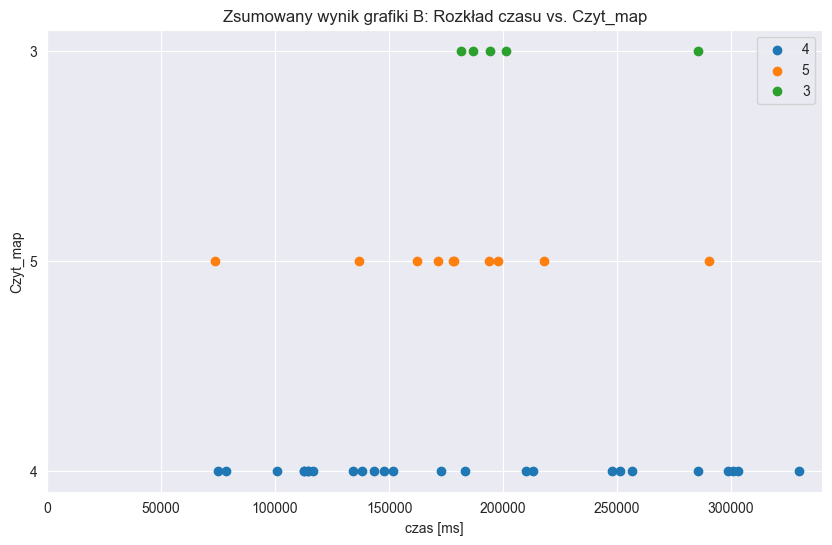

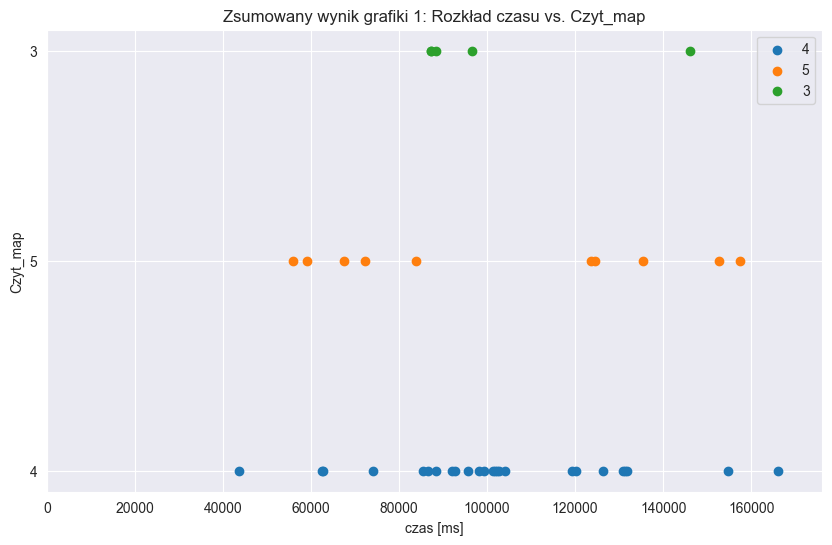

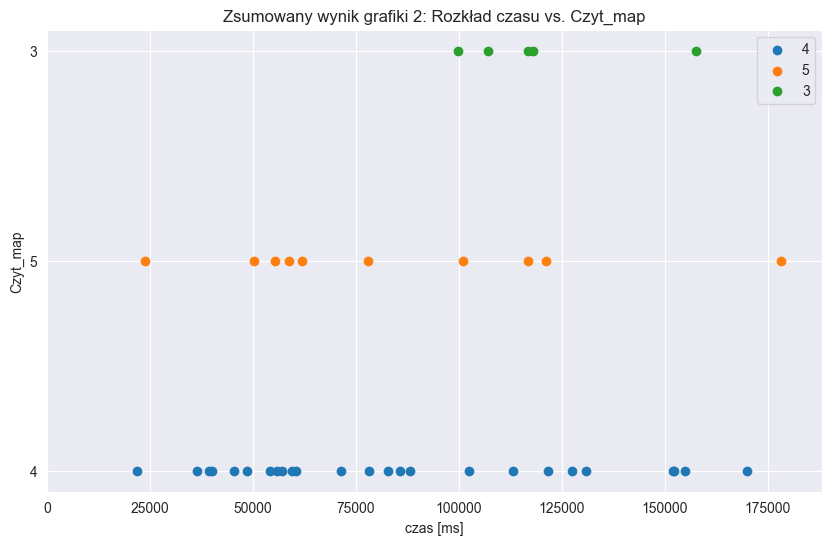

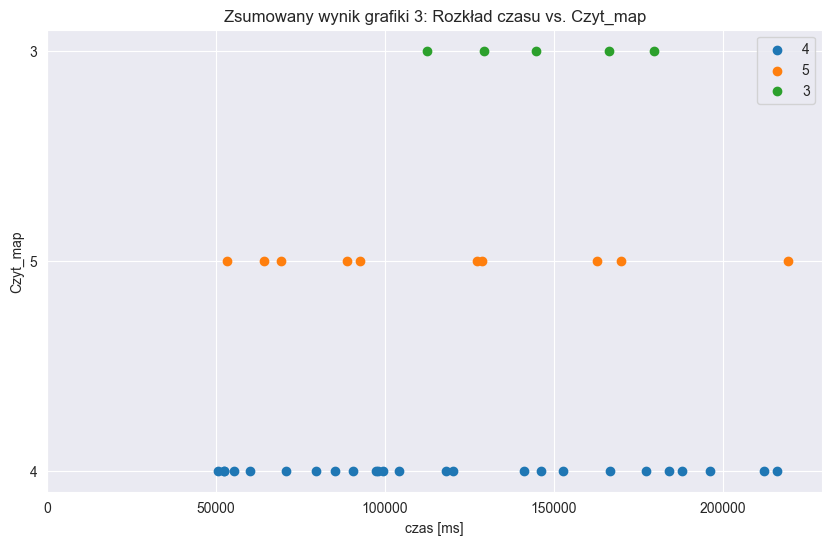

-------- Podziel_uwg ---------


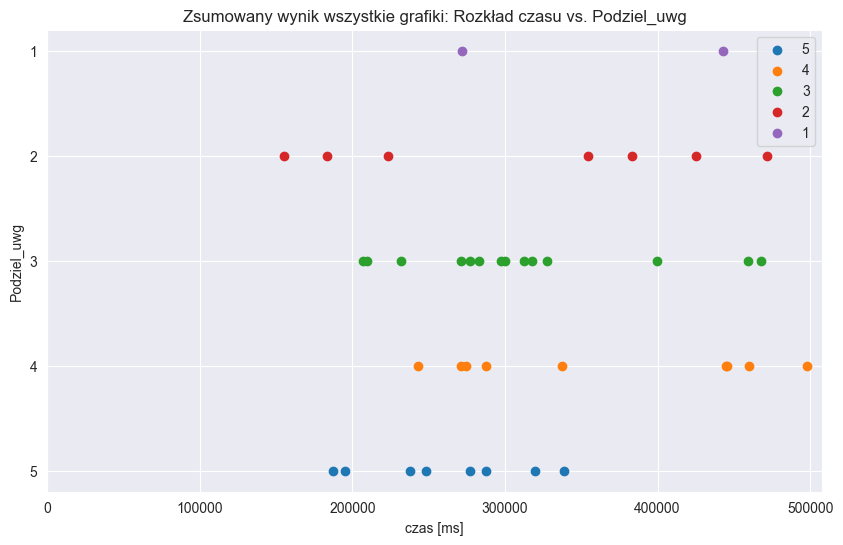

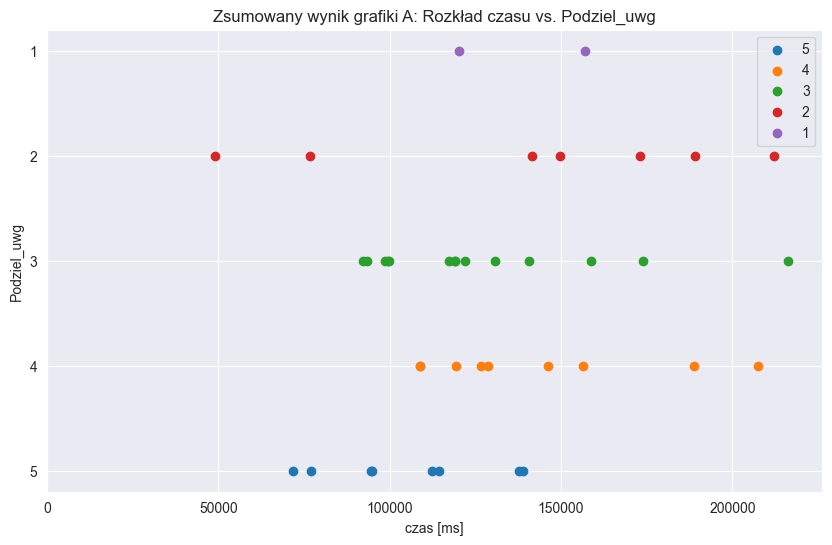

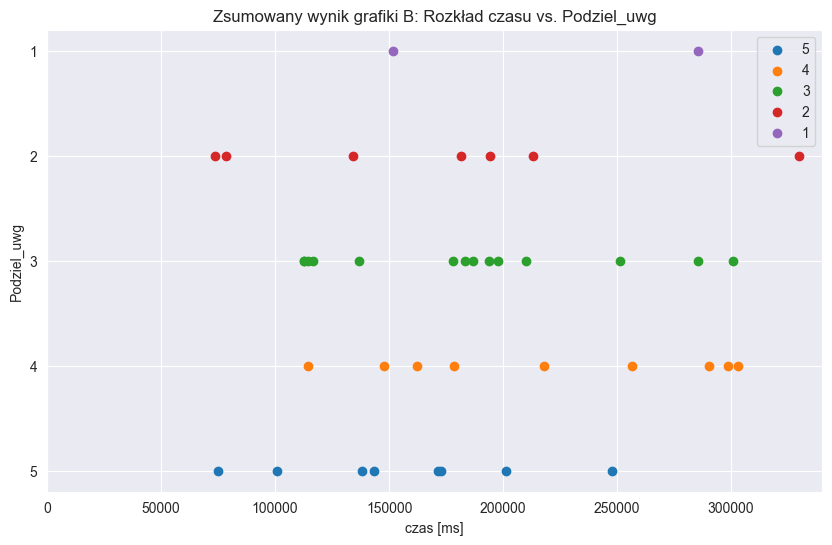

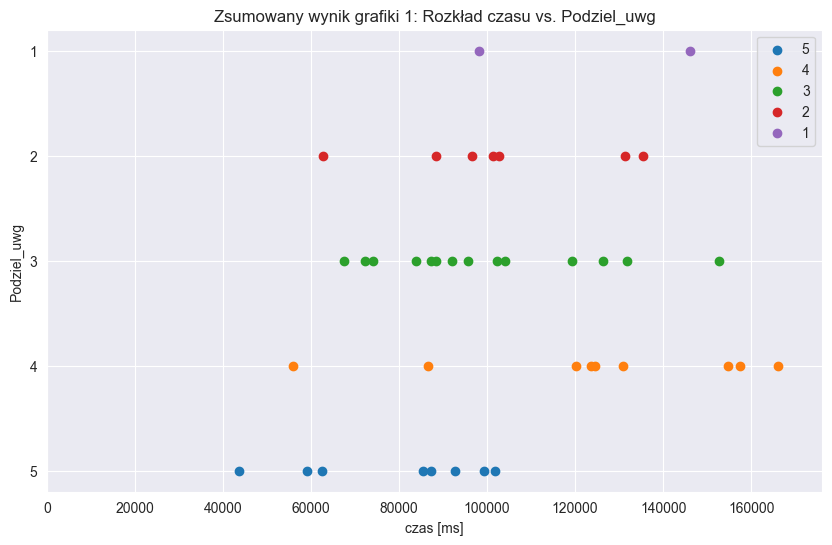

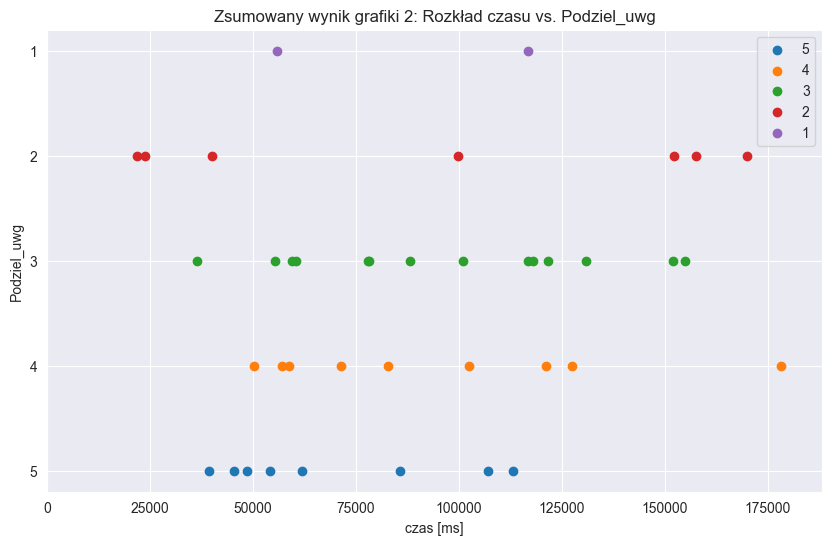

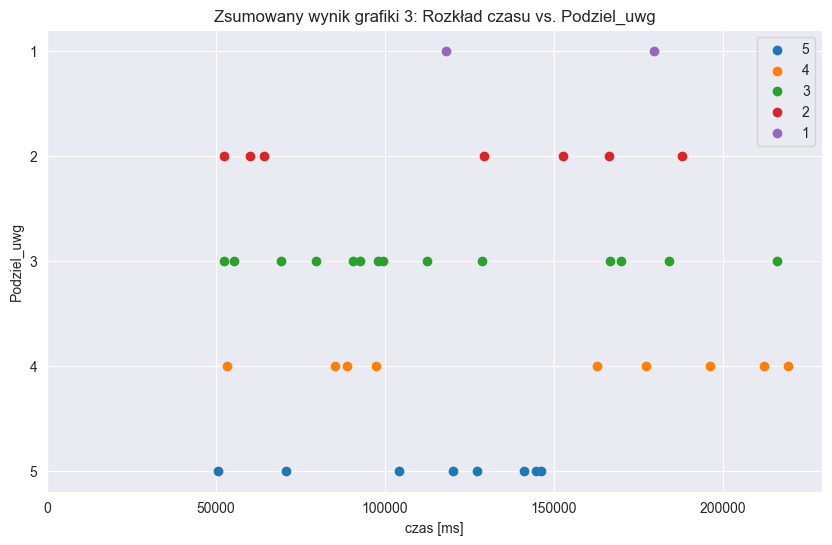

-------- Analit_myśl ---------


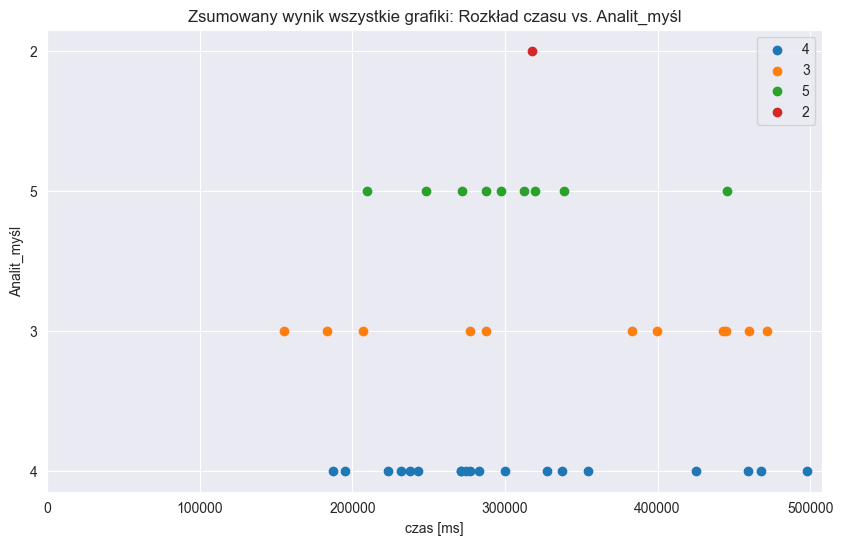

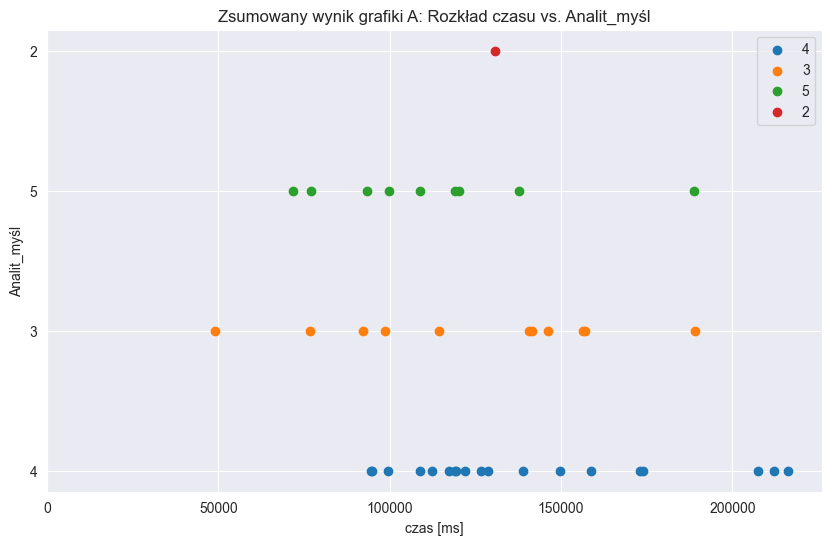

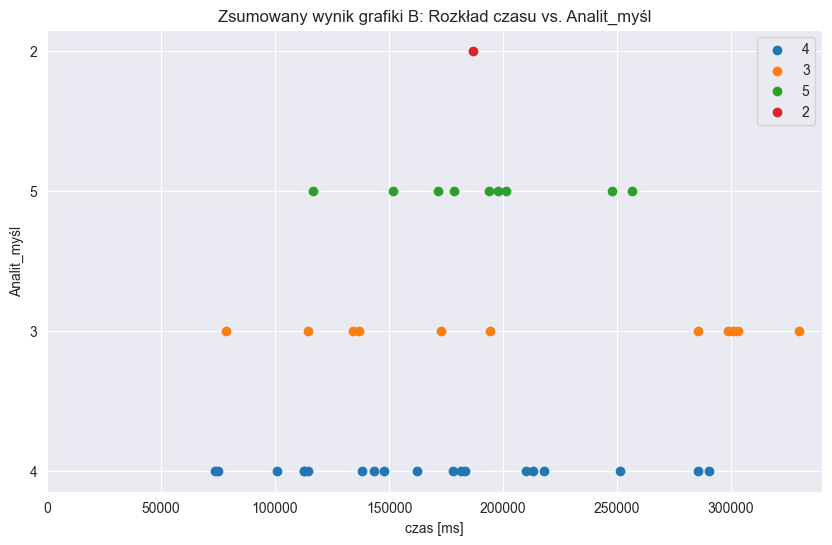

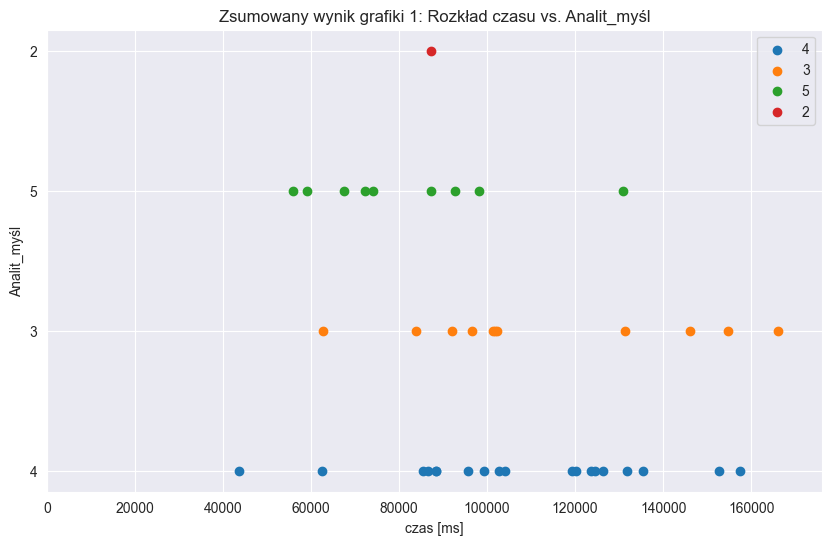

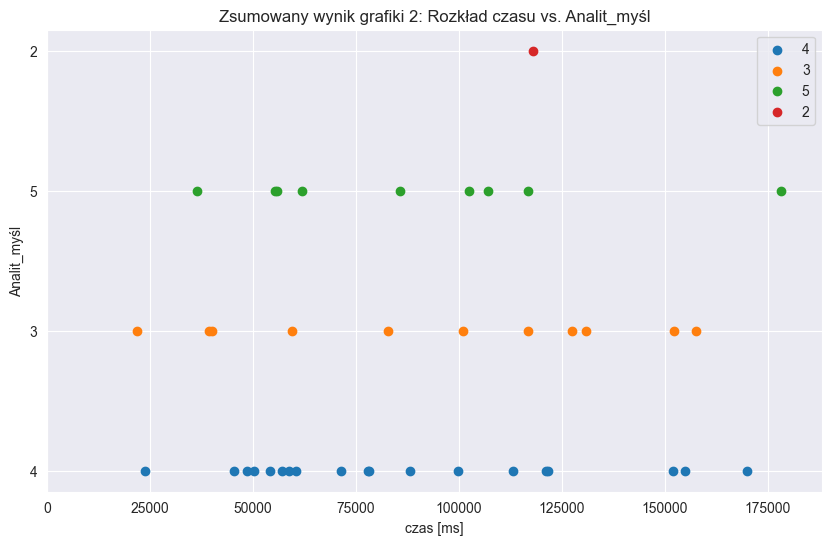

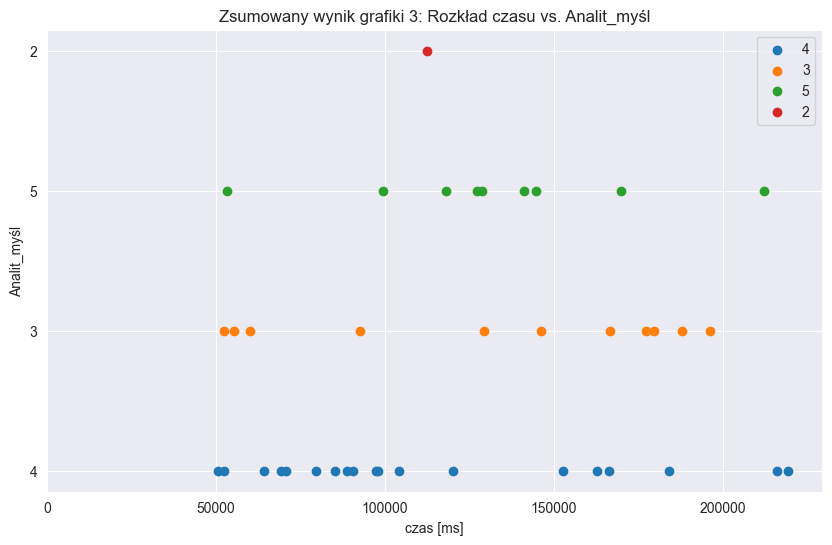

-------- Spostrzeg ---------


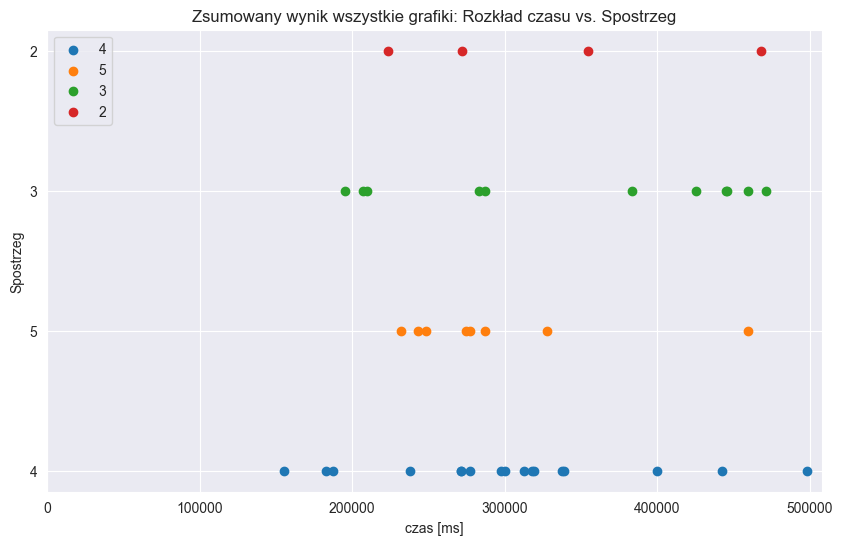

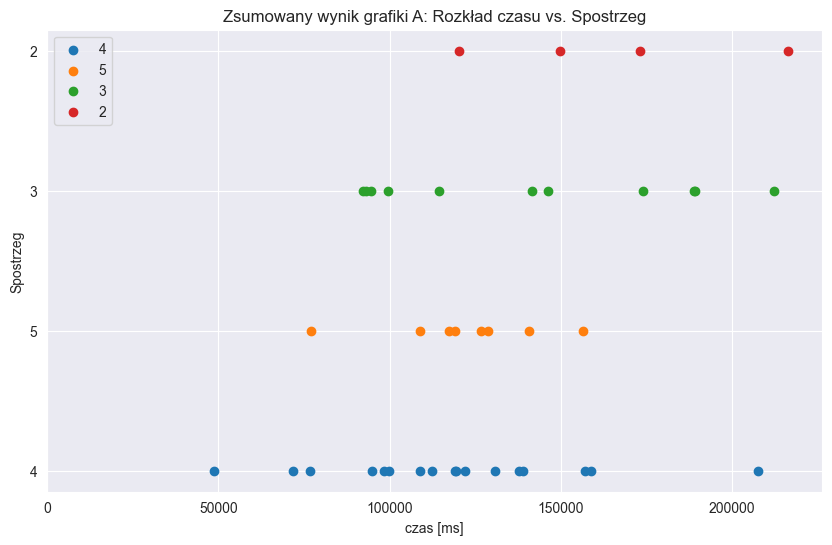

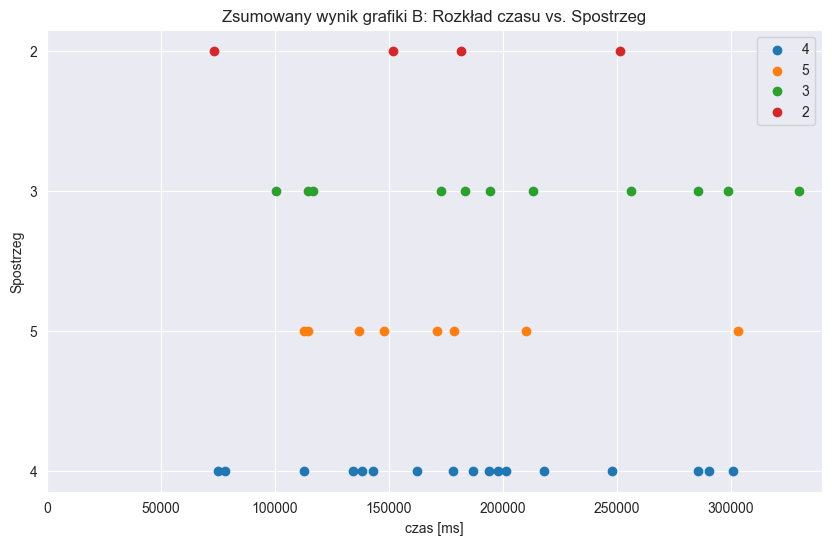

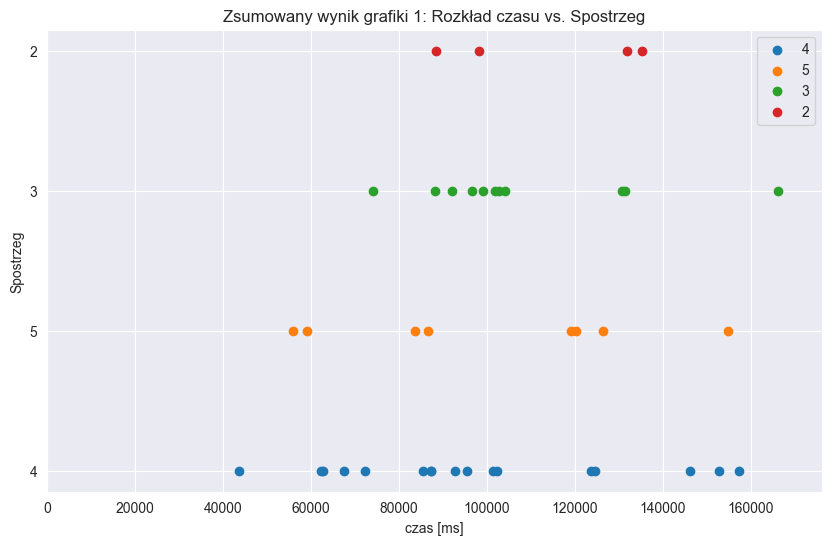

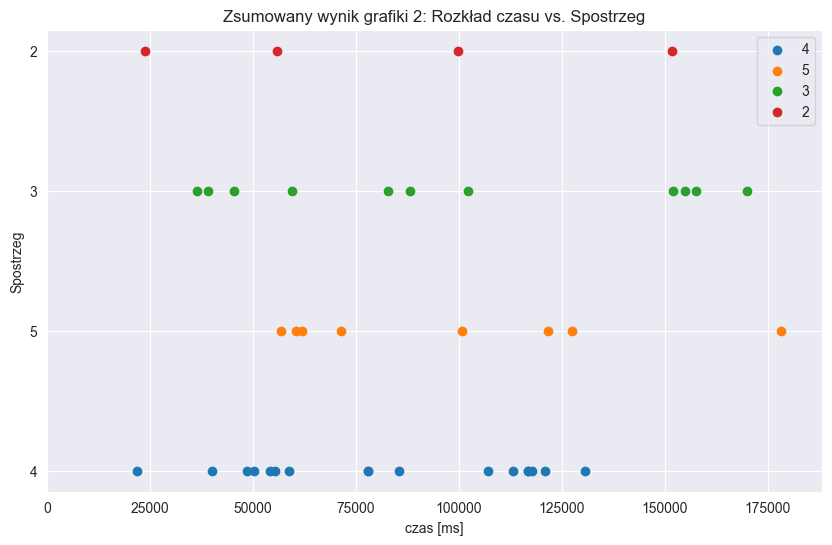

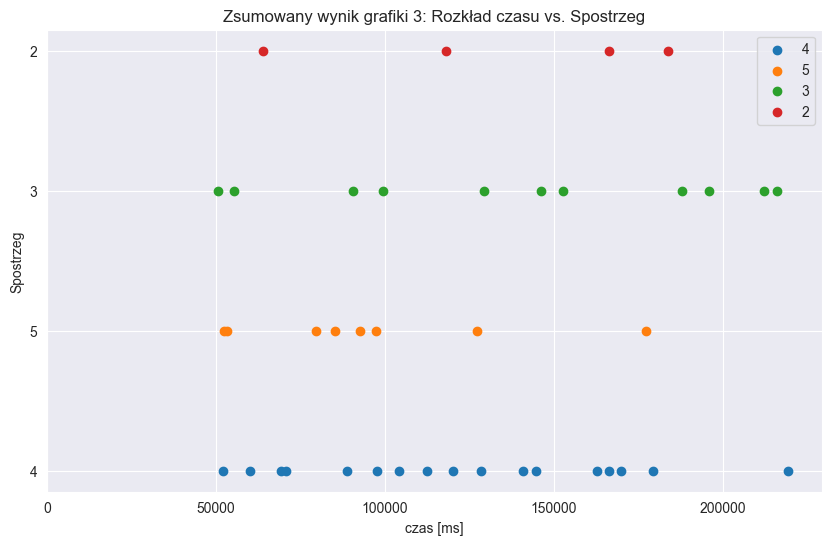

-------- Czyt_ze_zroz ---------


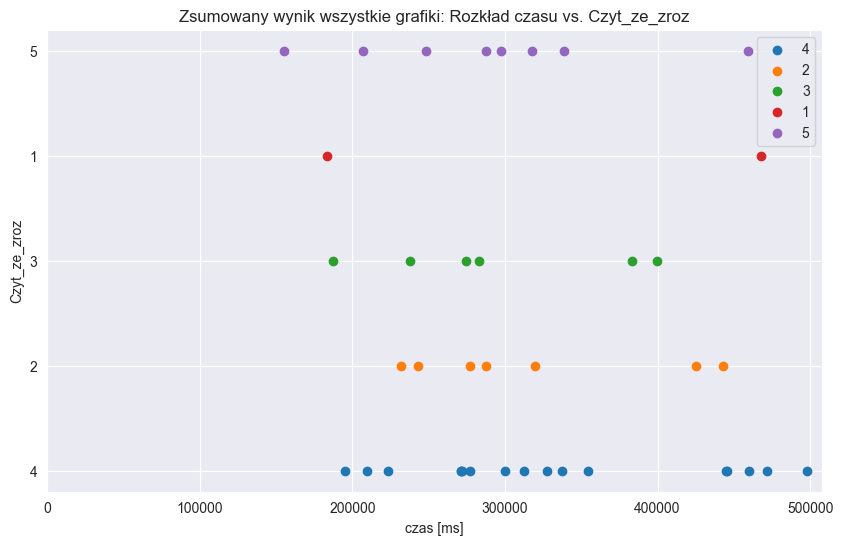

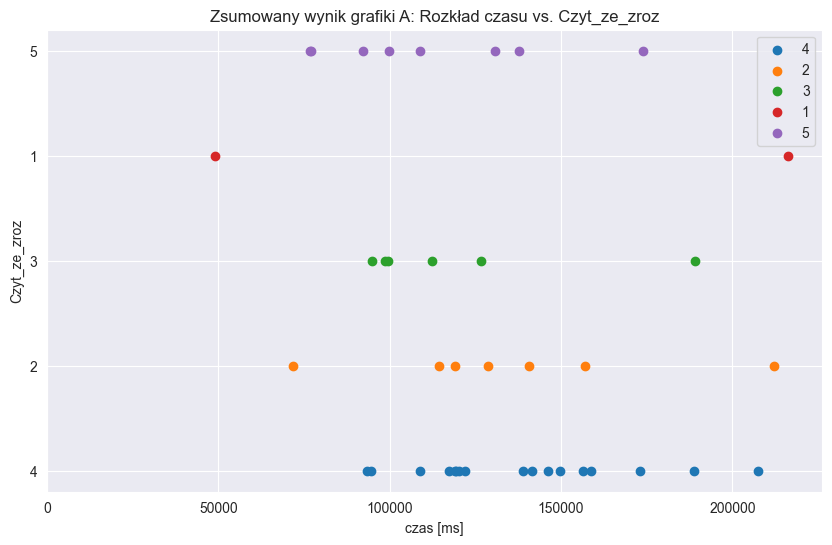

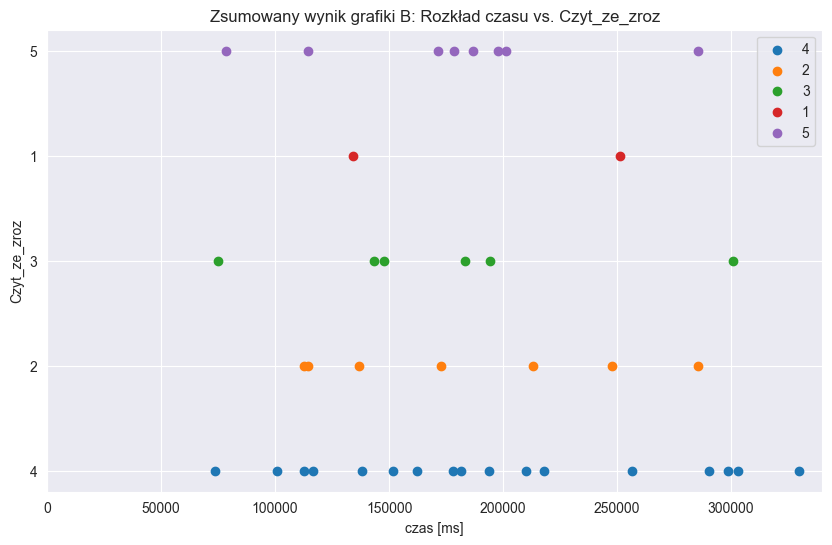

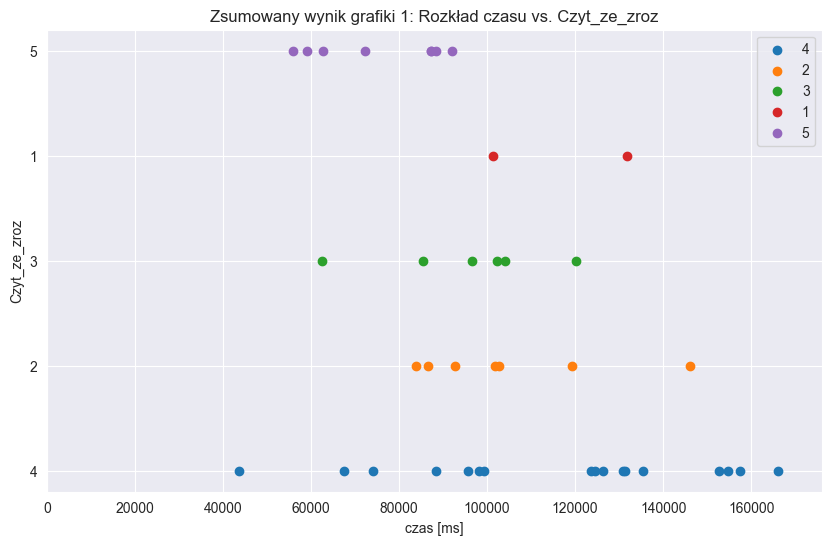

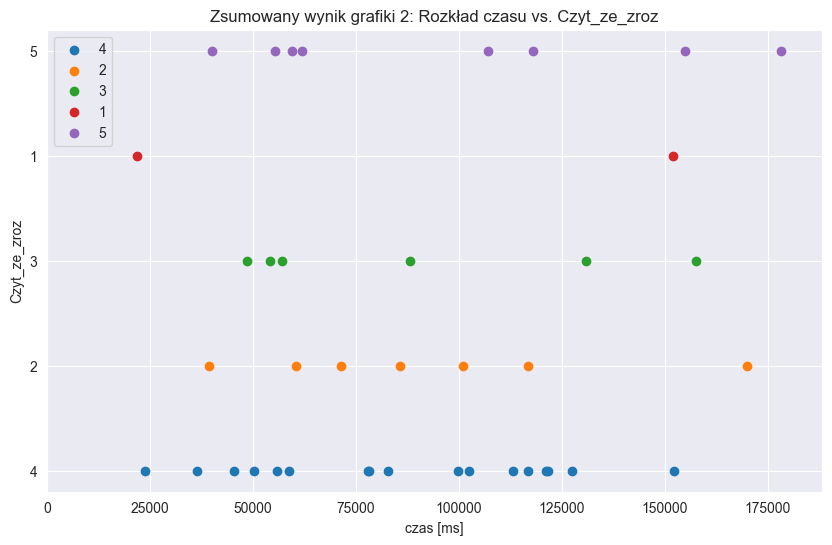

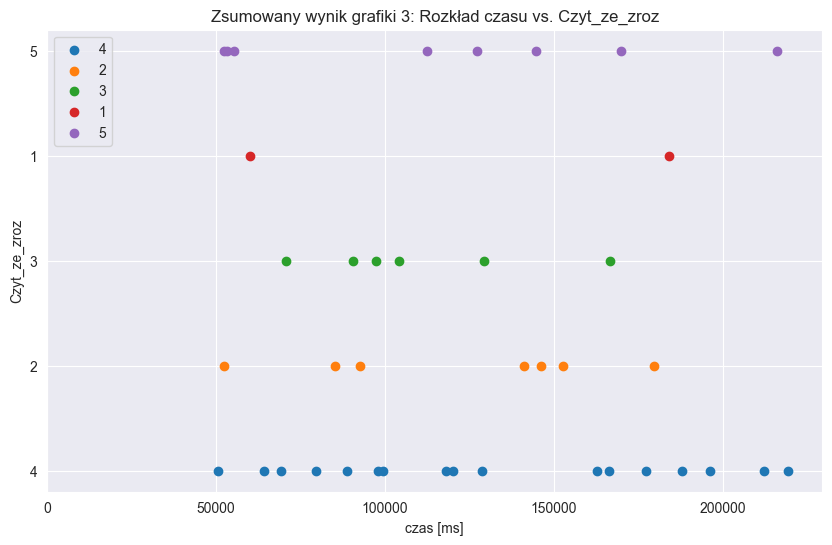

-------- Wzrokowiec ---------


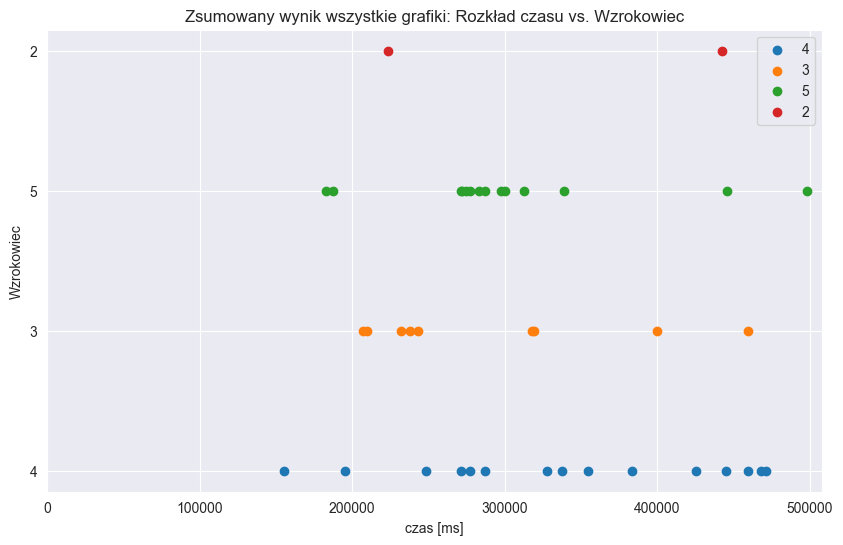

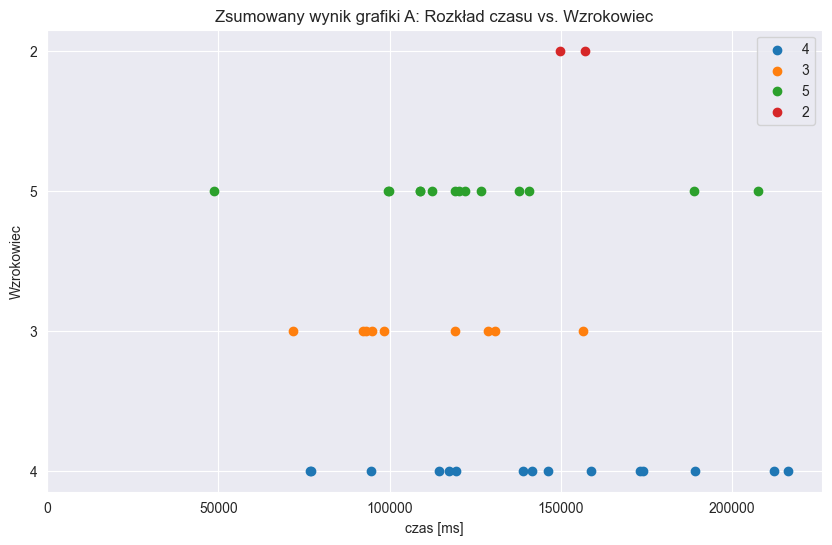

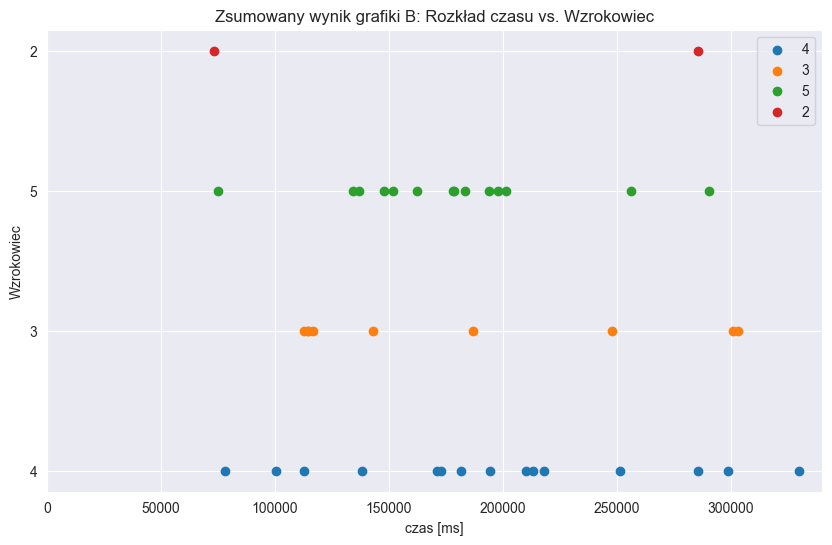

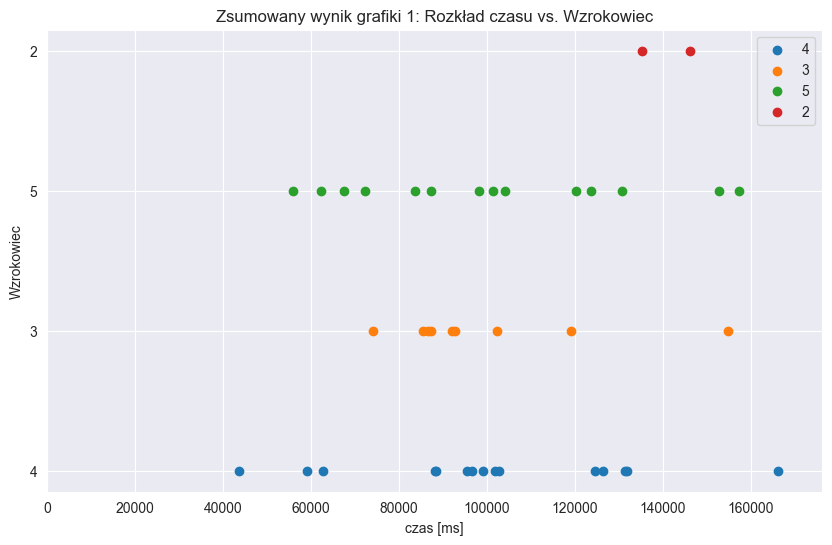

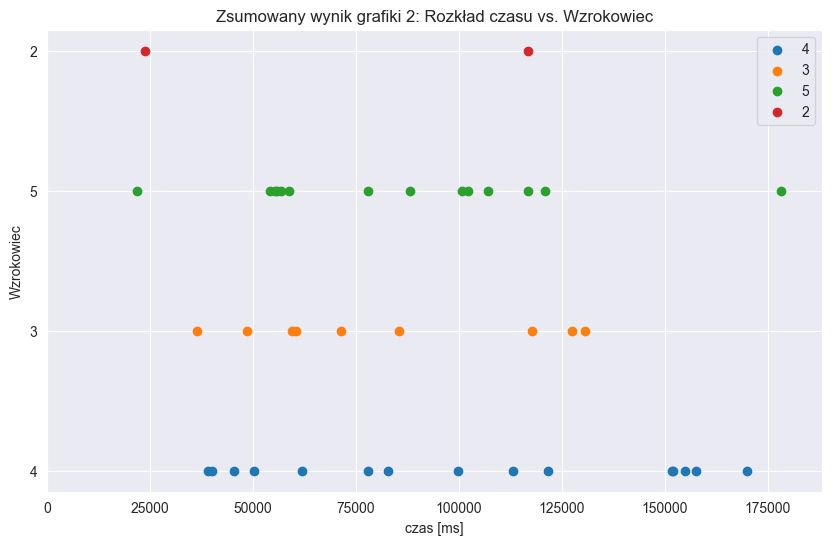

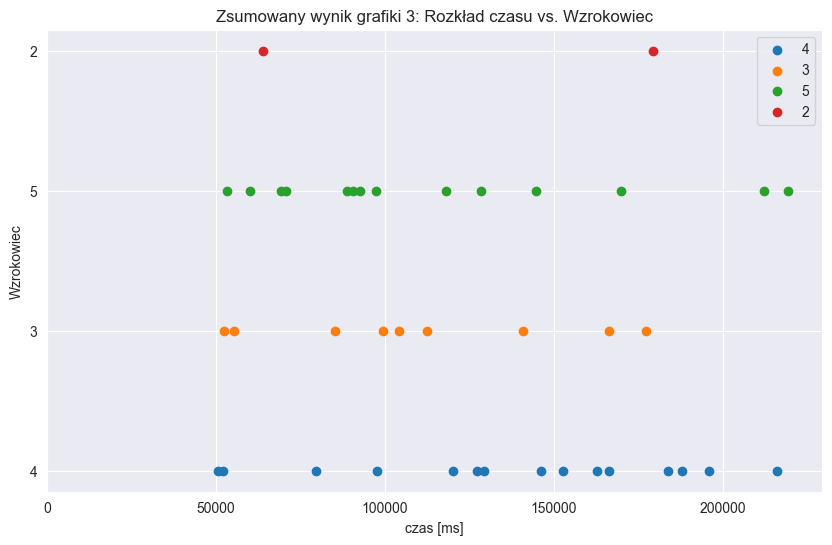

-------- Słuchowiec ---------


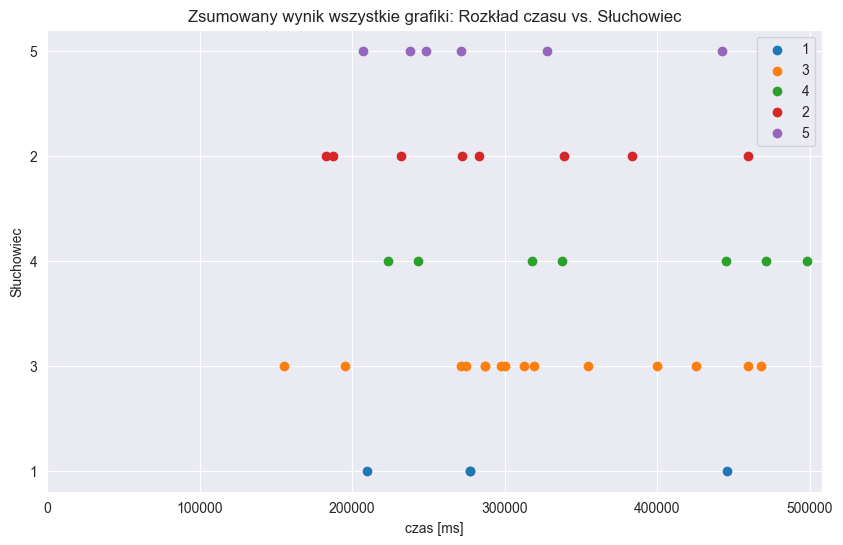

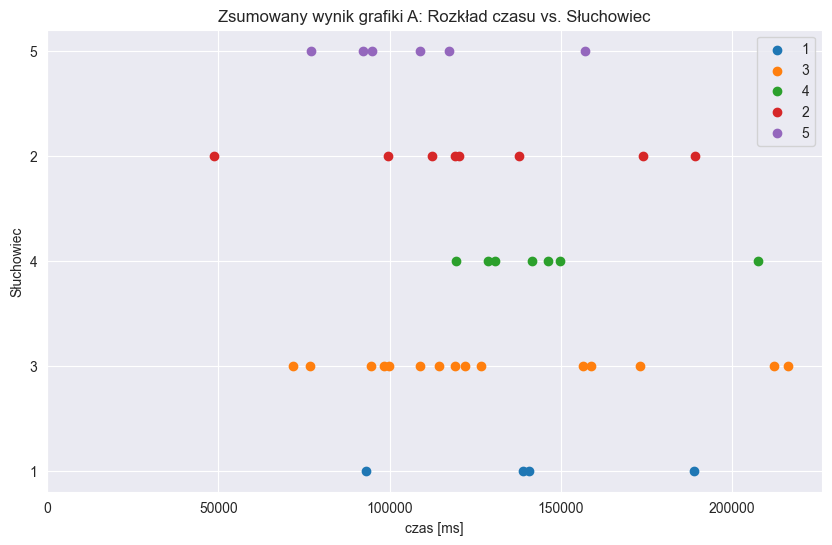

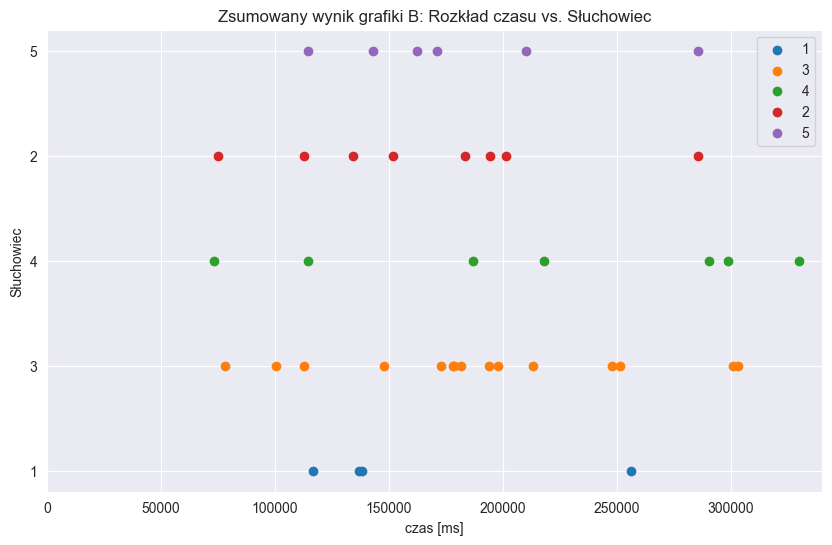

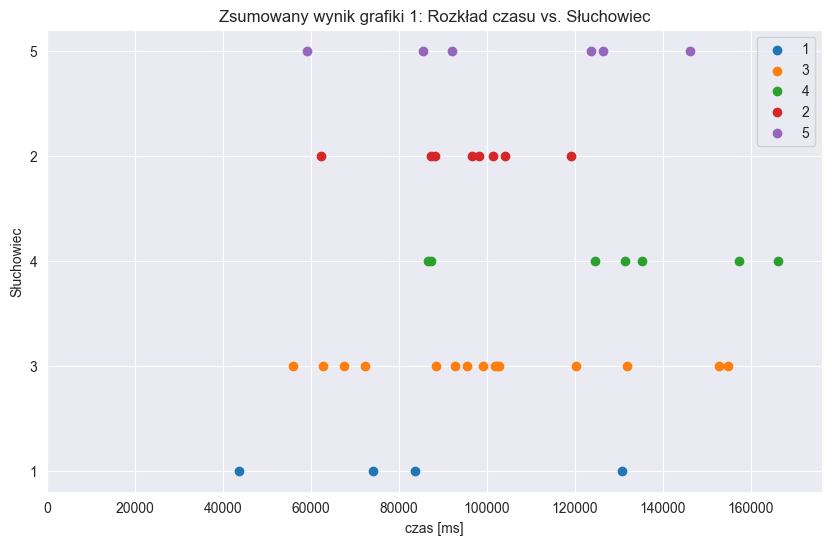

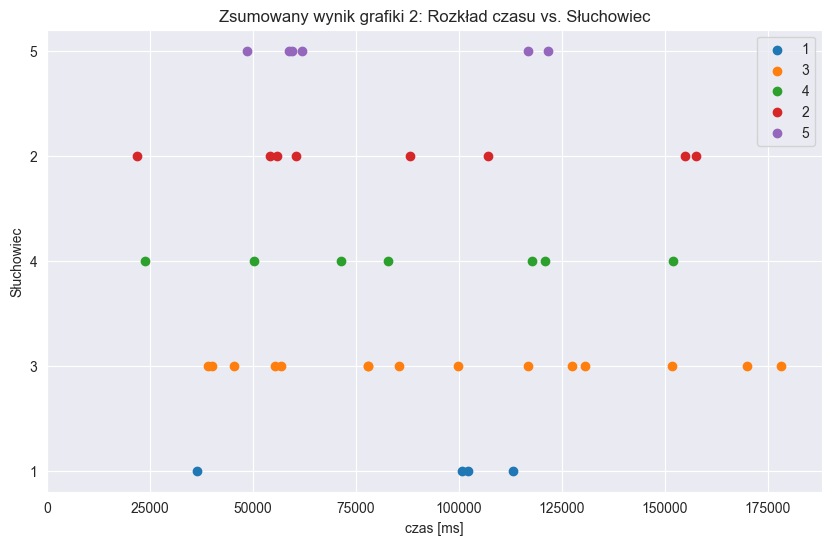

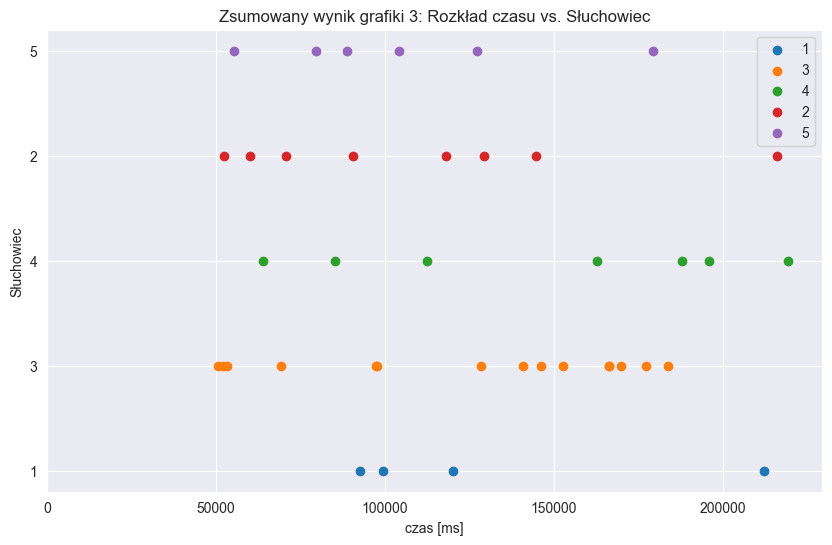

-------- Kinestetyk ---------


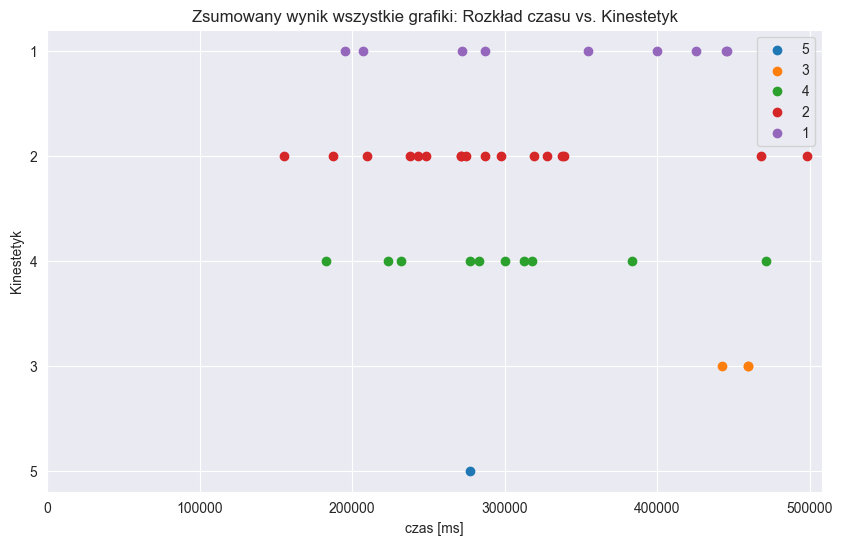

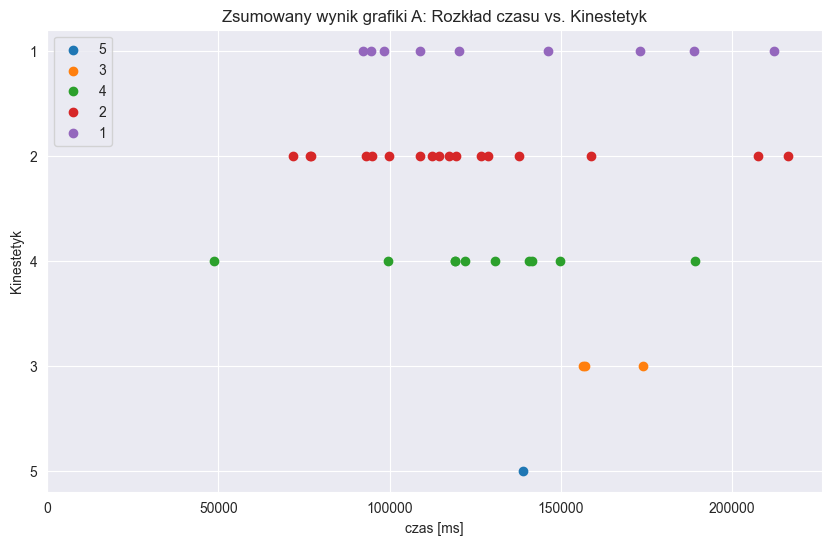

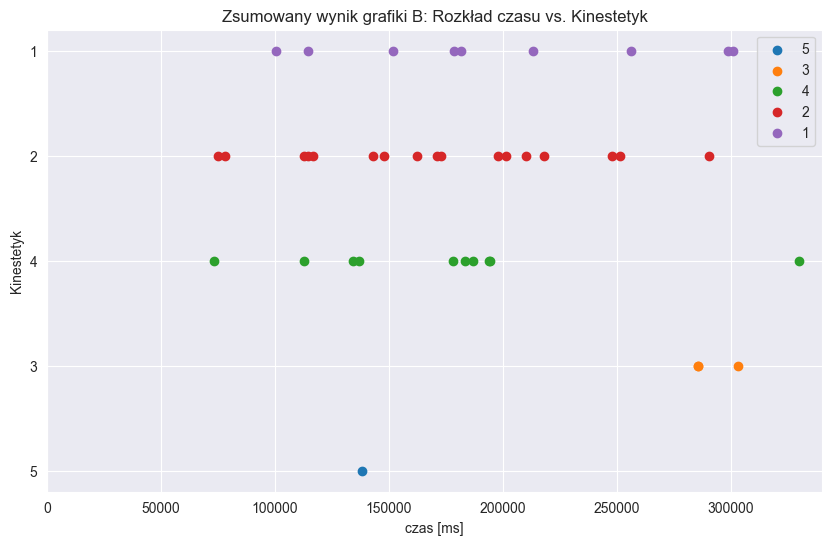

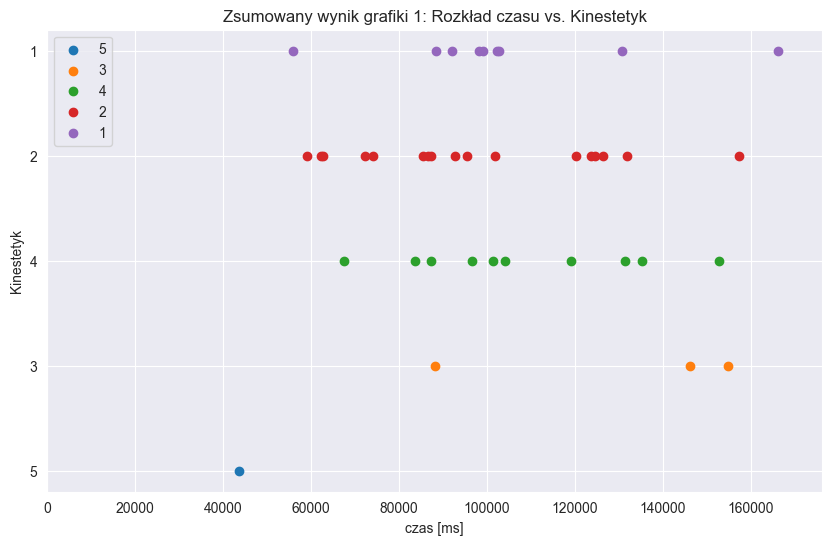

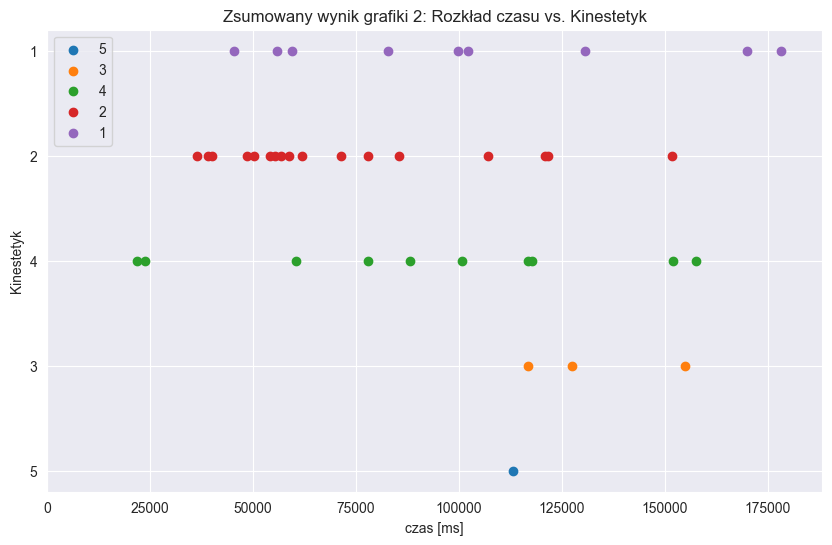

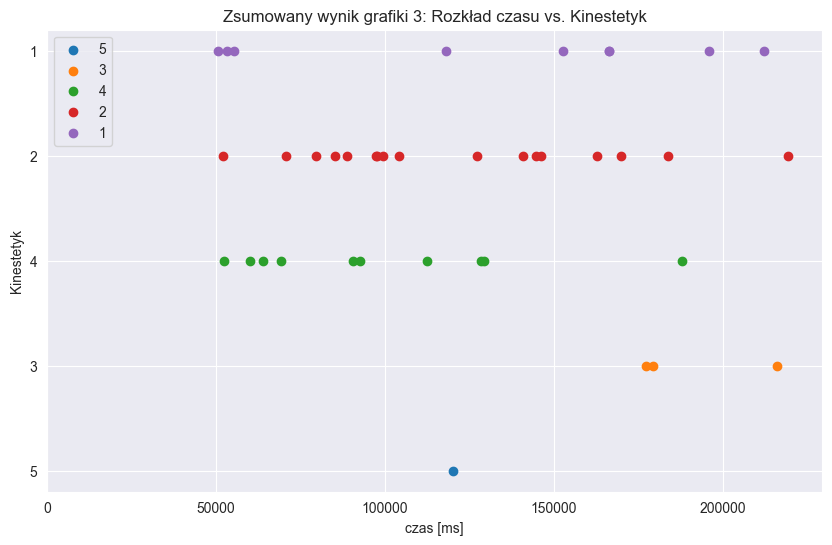

-------- MAT ---------


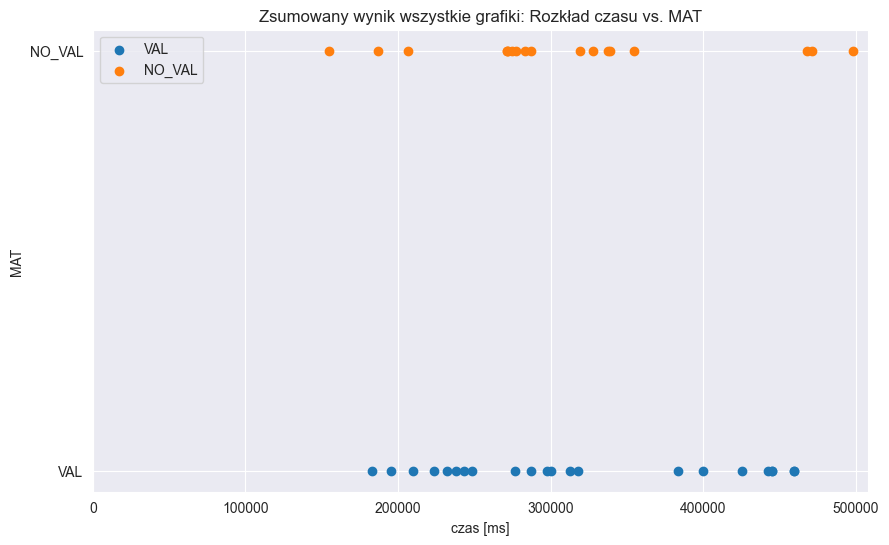

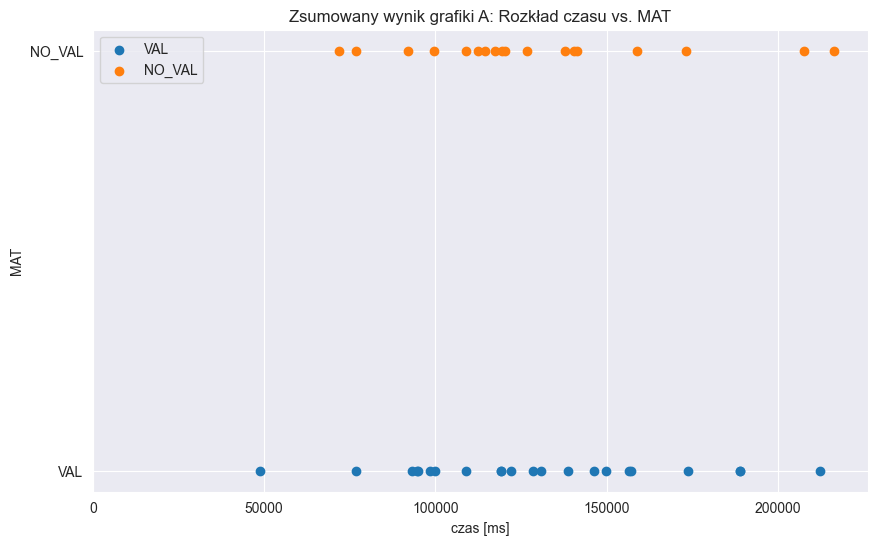

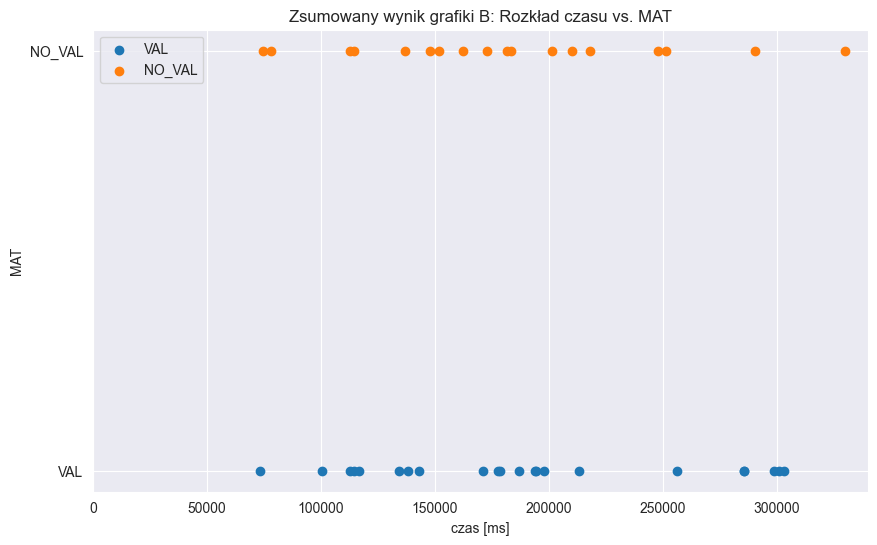

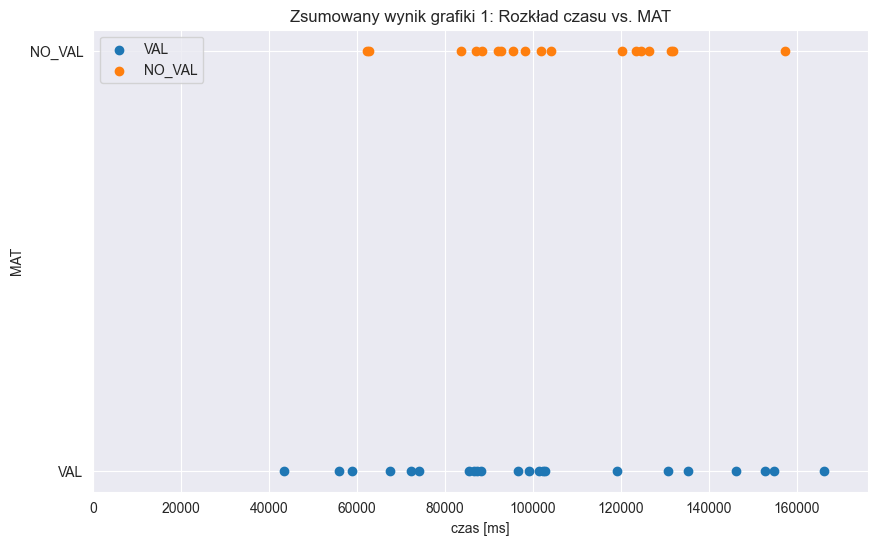

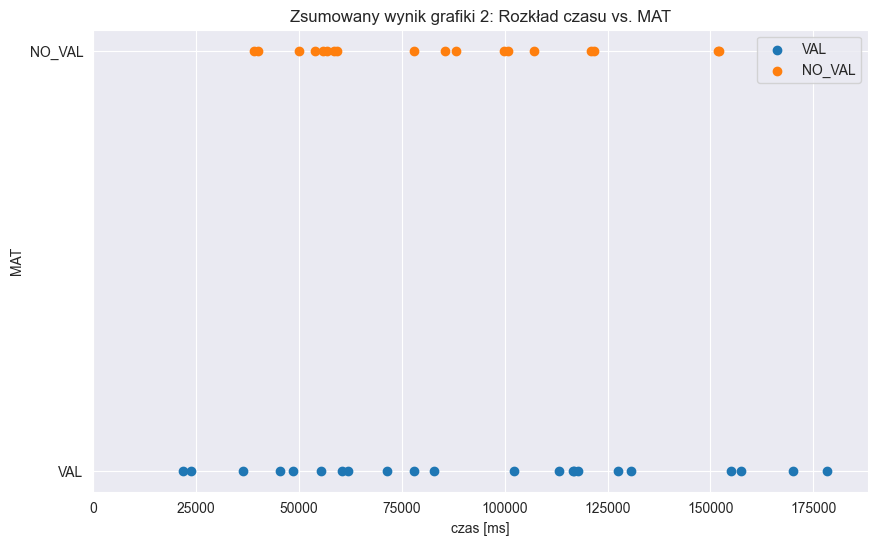

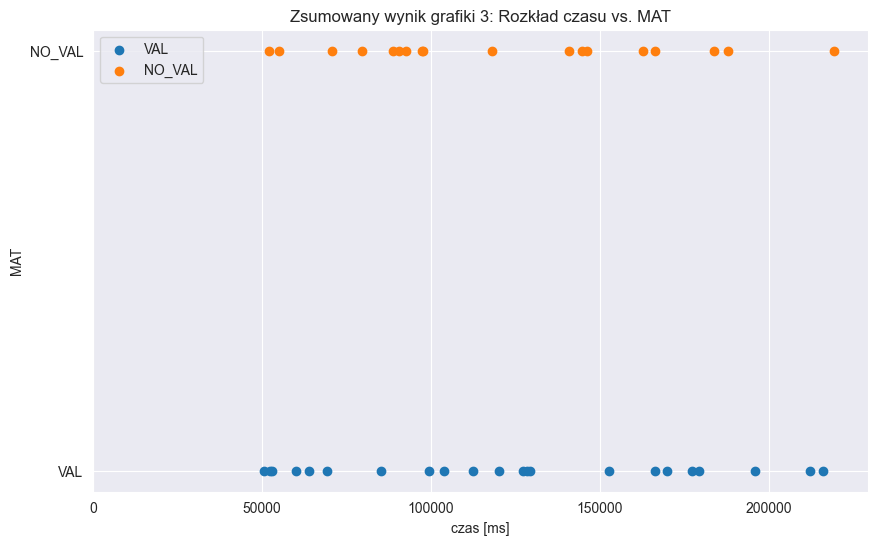

-------- POL ---------


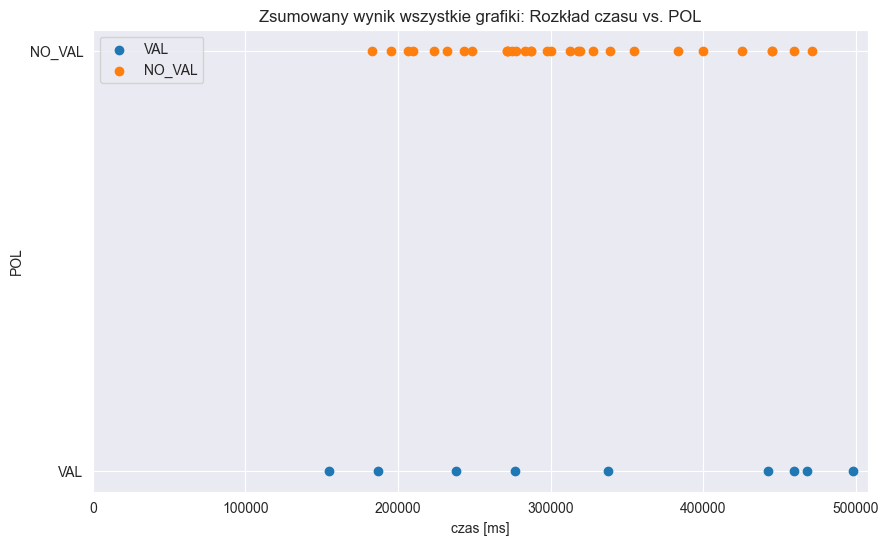

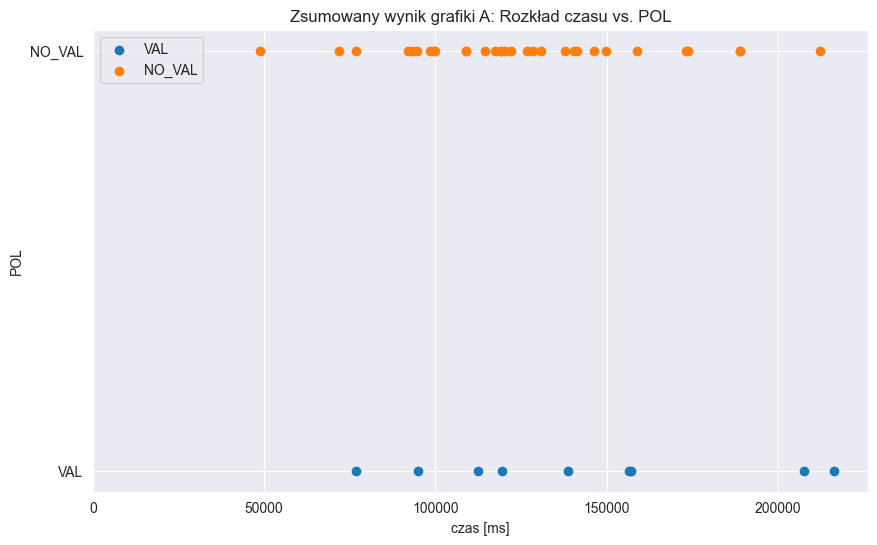

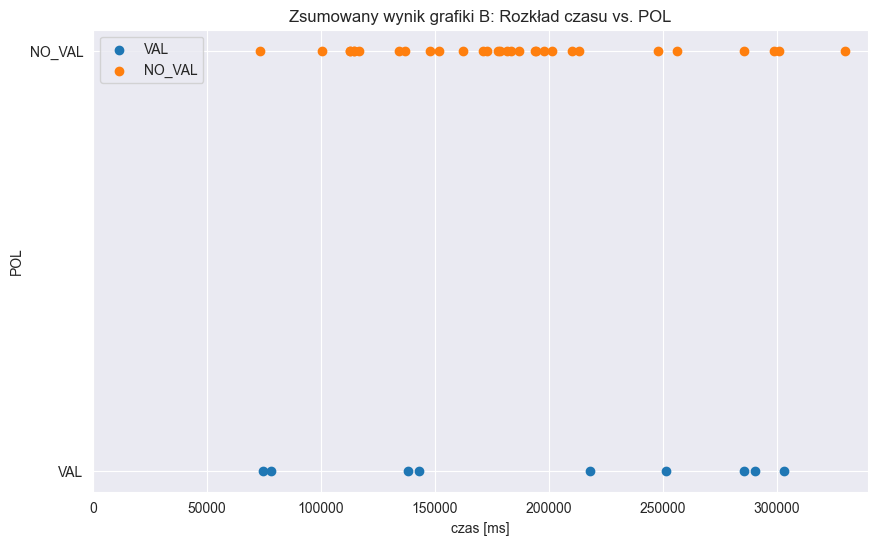

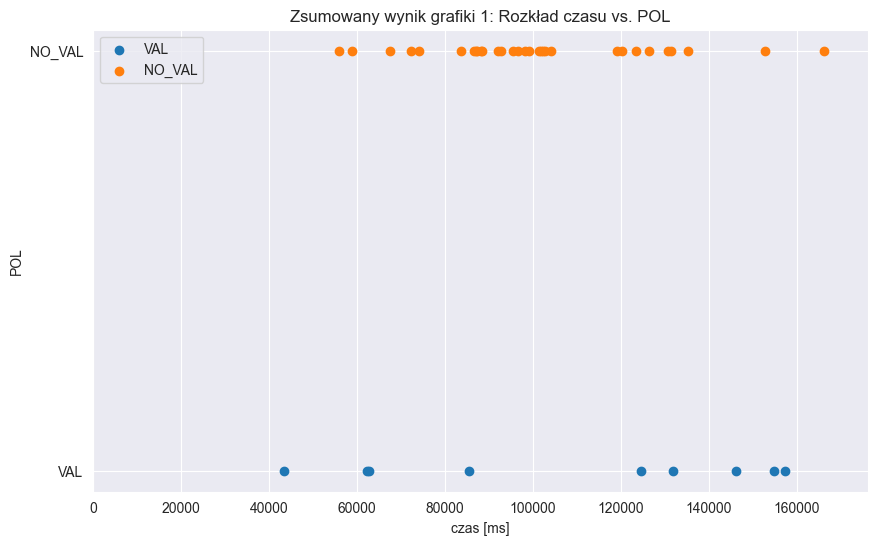

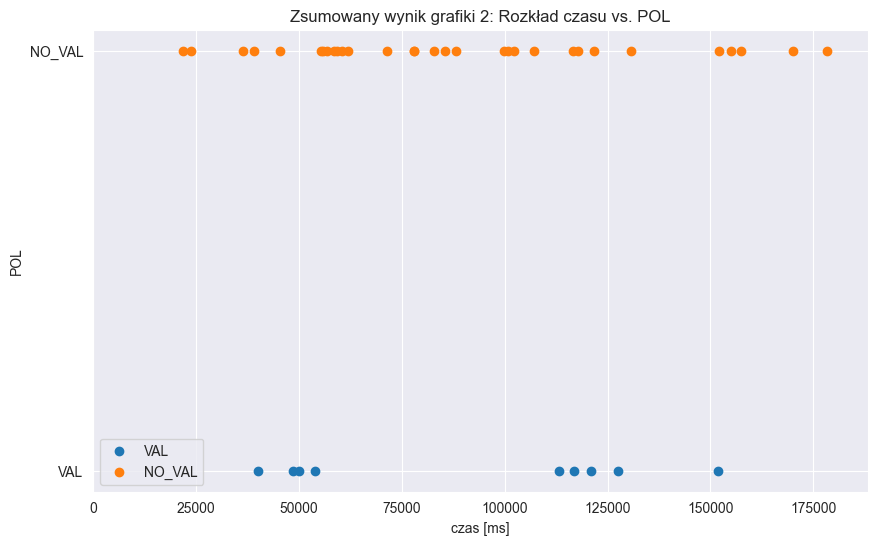

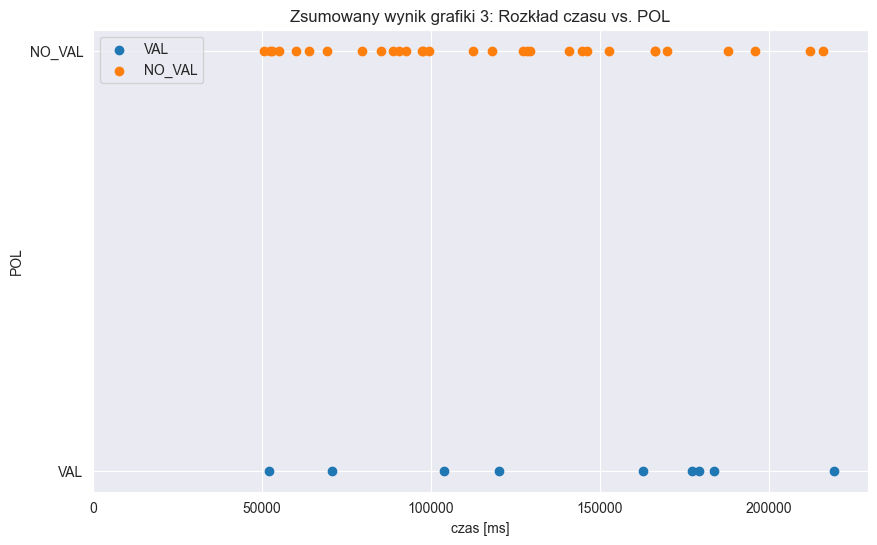

-------- HIST ---------


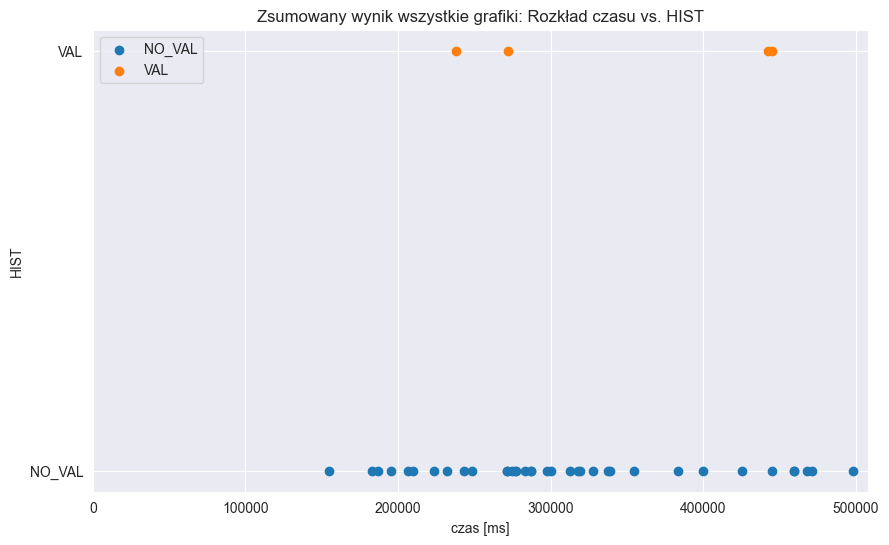

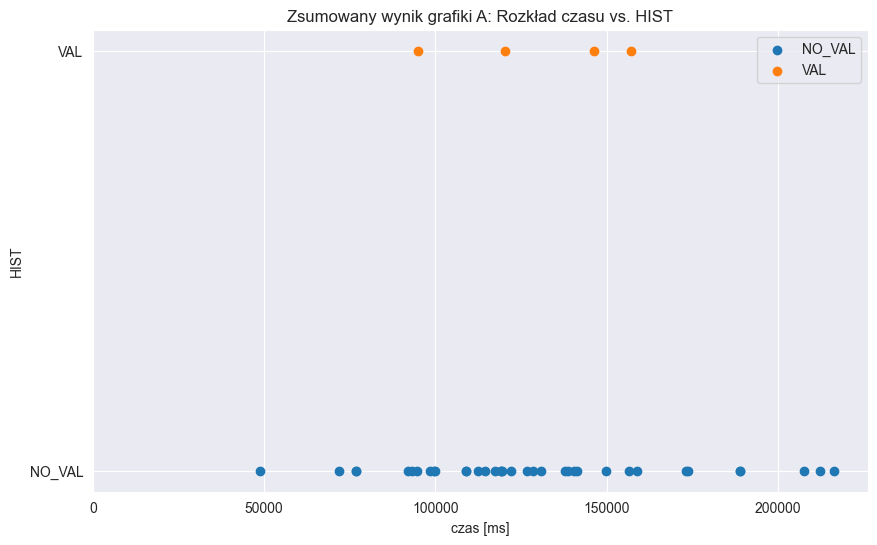

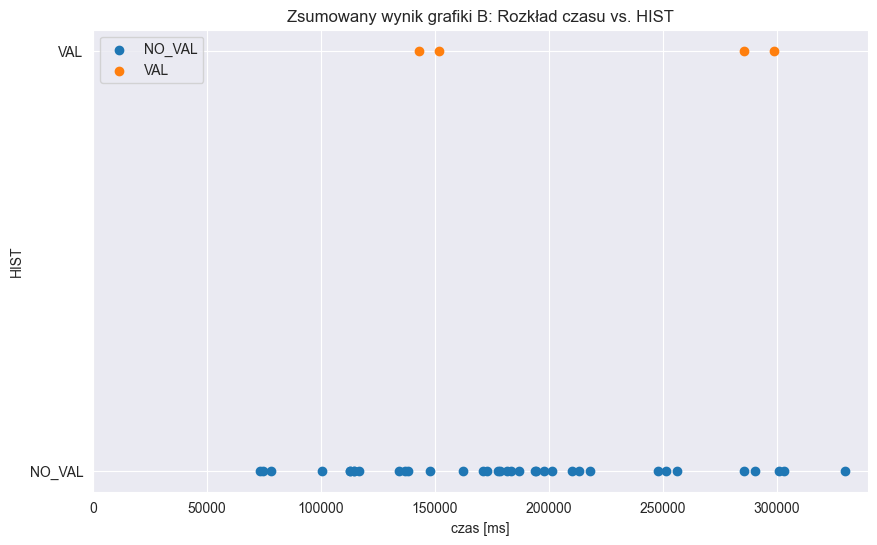

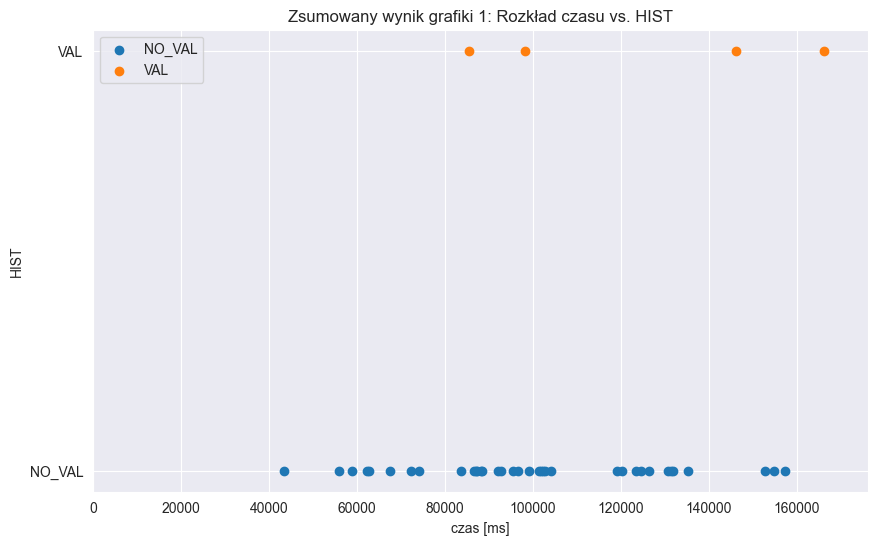

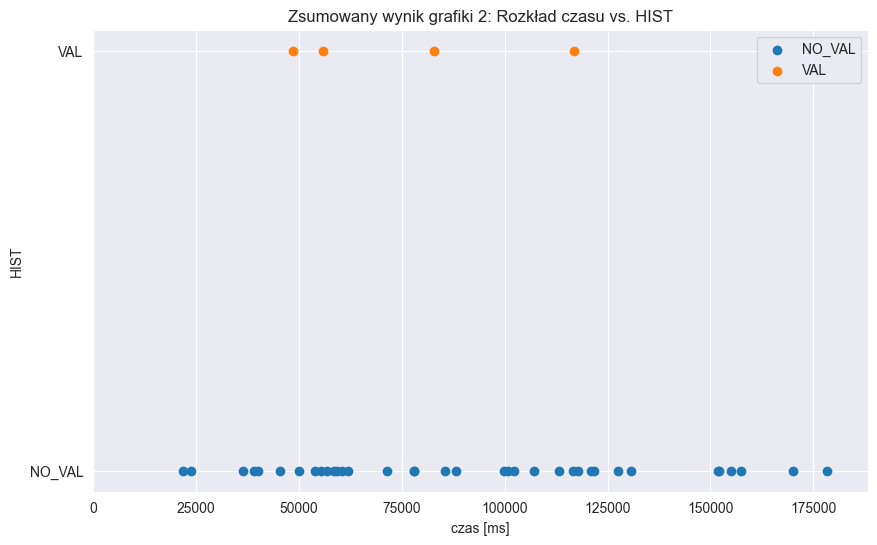

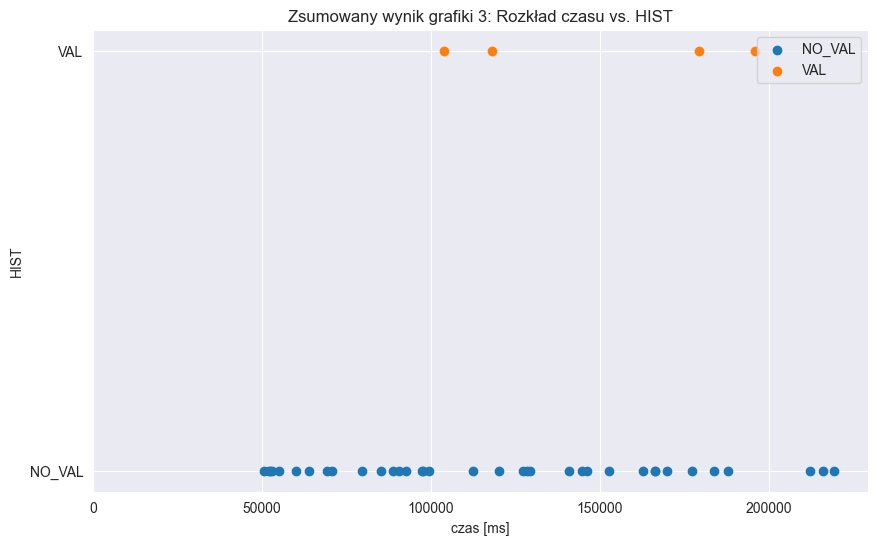

-------- Typ_uczenia ---------


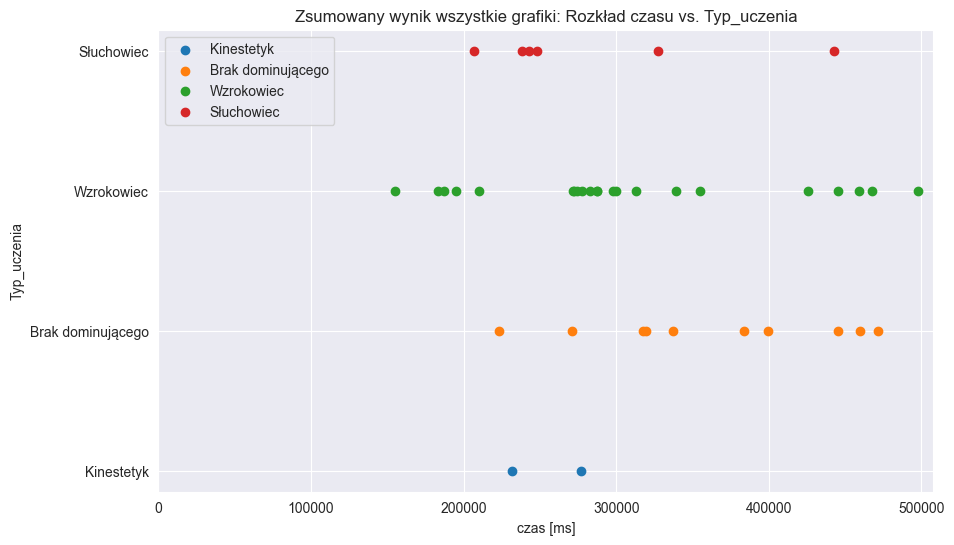

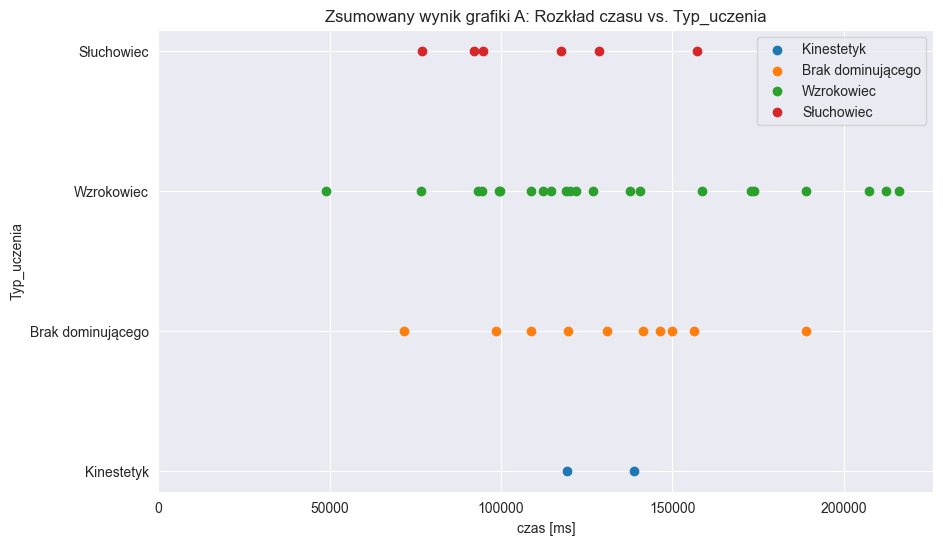

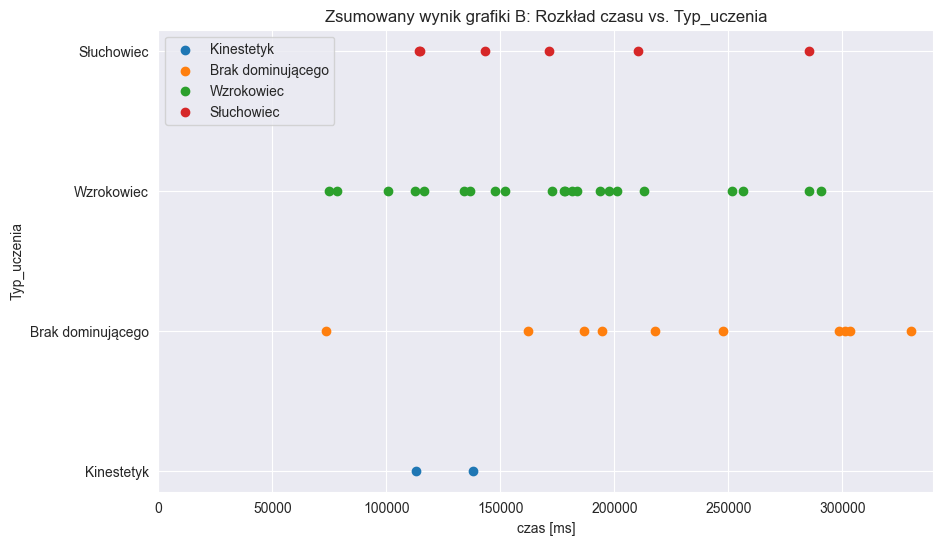

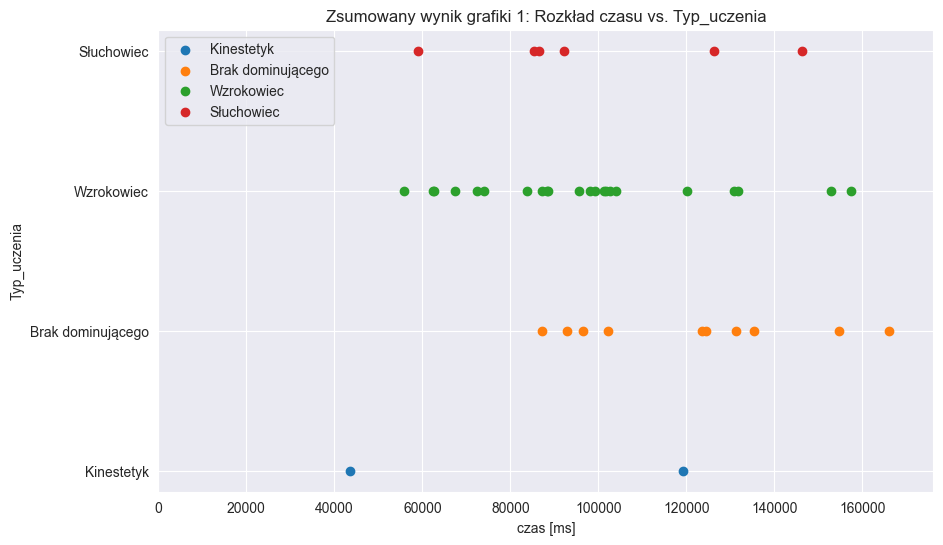

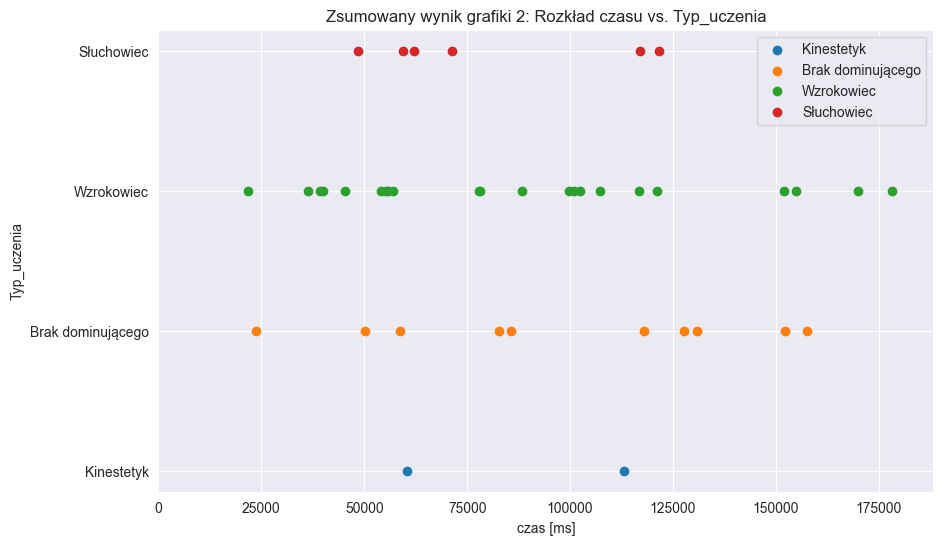

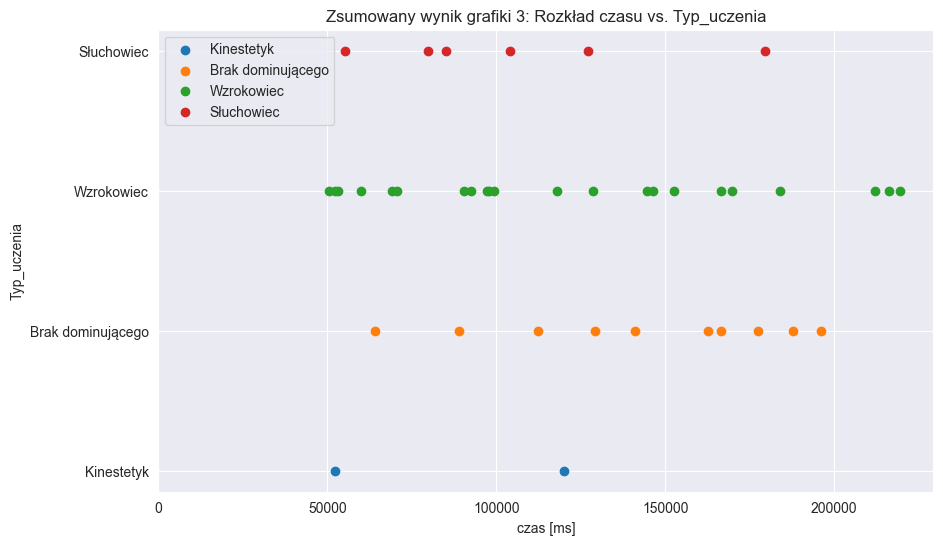

In [110]:
for col in columns:
    print('--------', col, '---------')
    plot_categorical_time_data(df_sumAll, col, names[1])
    plot_categorical_time_data(df_sumA, col, names[2])
    plot_categorical_time_data(df_sumB, col, names[3])
    plot_categorical_time_data(df_sum1, col, names[4])
    plot_categorical_time_data(df_sum2, col, names[5])
    plot_categorical_time_data(df_sum3, col, names[6])   